<a href="https://colab.research.google.com/github/dpb24/customer-churn/blob/main/notebooks/cell2cell_customer_churn_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction: Cell2Cell Dataset

In this project, we explore the [Cell2Cell Churn Dataset](https://www.kaggle.com/datasets/jpacse/datasets-for-churn-telecom/data) to understand customer churn behaviour and build three supervised machine learning models - Decision Tree, XGBoost, and a Neural Network implemented in TensorFlow - to predict churn risk. The analysis includes feature engineering, exploratory data analysis, model tuning, and evaluation, all designed to support data-driven customer retention strategies.

## 1 Imports
We import relevant Python packages for data manipulation, visualisation, preprocessing and modeling.

In [ ]:
# Operational packages
import pandas as pd
import numpy as np
import warnings
import pickle
import math
from datetime import datetime
from google.colab import files

# Statistical packages
import scipy.stats as stats
from scipy.stats import kendalltau
from sklearn.metrics import roc_auc_score
from scipy.stats import gaussian_kde

# Visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Machine Learning models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf

# Model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import plot_importance
from tensorflow.keras.callbacks import Callback
import shap

warnings.filterwarnings("ignore", category=FutureWarning)

## 2 Data Overview
### 2.1 Data Description
The Cell2Cell dataset contains anonymised, customer-level data from a major U.S. mobile network operator.

It was made available through the Teradata Center for Customer Relationship Management at [Duke University](https://www.fuqua.duke.edu/) and includes information on customer demographics, usage patterns, billing history, and service-related features.

According to the data description:$^{1}$

"Customers were selected as follows: mature customers (customers who were with the company for at least six months), were sampled during July, September, November, and December of 2001. For each customer, predictor variables were calculated based on the previous four months. Churn was then calculated based on whether the customer left the company during the period 31-60 days after the customer was originally sampled. The one-month treatment
lag between sampling and observed churn was for the practical concern that in any application, a few weeks would be needed to score the customer and implement any proactive actions. The actual percentage of customers who churn in a given month is approximately 1.8%. However, churners were over sampled when creating the Calibration sample to create a roughly 50-50 split between churners and non-churners."

### 2.2 Data Dictionary

| Column name               | Type                     | Description|
|---------------------------|--------------------------||
| `CustomerID` | nominal | customer identification number |
| `Churn` | binary |  whether the customer left the company during the period 31-60 days after sampling (Yes / No) |
| `ChildrenInHH` |binary| whether the customer has children in their household |
| `HandsetRefurbished` |binary| whether the customer's handset is refurbished |
| `HandsetWebCapable`  |binary| whether the customer's handset is internet-enabled |
| `TruckOwner` |binary| whether customer owns a truck |
| `RVOwner` |binary| whether customer owns a recreational vehicle |
| `BuysViaMailOrder` |binary| whether customer has purchased any products by mail order within 4-month period|
| `RespondsToMailOffers` |binary| whether customer repsonded to any mail offers within 4-month period |
| `OptOutMailings` |binary| whether customer opts out of marketing mailings|
| `NonUSTravel` |binary| whether customer travels outside of United States |
| `OwnsComputer` |binary| whether customer owns a computer |
| `HasCreditCard` |binary| whether customer has credit card |
| `NewCellphoneUser` |binary| whether customer is a new mobile user|
| `NotNewCellphoneUser` |binary| whether customer is not a new mobile user||
| `Homeownership` |binary| whether home ownership status of customer is known (Known/Unknown)|
| `OwnsMotorcycle` |binary | whether customer owns motorcycle|
| `MadeCallToRetentionTeam` |binary | whether customer phoned retention team|
| `ServiceArea` | nominal | the communications service area of the customer's home (eg. NYCQUE512) |
| `PrizmCode` |nominal | Potential Rating Index for Zip Markets (Suburban / Town / Rural / Other) |
| `Occupation` |nominal | occupation (Professional / Crafts / Self / Retired / Homemaker / Clerical / Student / Other)|
| `MaritalStatus` |nominal | whether customer is married (Yes / No / Unknown)|
| `IncomeGroup` |ordinal | customer's income group (0 - 9)|
| `CreditRating` |ordinal | customer's credit rating (1-Highest / 2-High / 3-Good / 4-Medium / 5-Low / 6-VeryLow / 7-Lowest) |
| `UniqueSubs` |discrete| number of mobile subscriptions associated with the customer |
| `ActiveSubs` |discrete| number of active mobile subscriptions associated with the customer|
| `Handsets` |discrete| number of handsets issued to the customer |
| `HandsetModels` |discrete|  number of models issued to the customer |
| `MonthsInService` |discrete| number of months the customer has been with the mobile provider |
| `CurrentEquipmentDays` |discrete| number of days the customer has had their current mobile(s)|
| `AgeHH1` |discrete| customer's age |
| `AgeHH2` |discrete| second household member's age |
| `RetentionCalls` |discrete| number of phonecalls the retention team have made to the customer |
| `RetentionOffersAccepted` |discrete| number of retention offers the customer accepted during the last 4 months |
| `ReferralsMadeBySubscriber` |discrete| number of referrals the customer has made |
| `AdjustmentsToCreditRating` |discrete | number of adjustments to customer's credit rating during 4-month period |
| `MonthlyRevenue` | continuous | total monthly bill for customer (average) (USD)|
| `TotalRecurringCharge` | continuous | cost of customer's monthly plan (USD) |
| `MonthlyMinutes` | continuous | mean number of minutes of use per month |
| `DirectorAssistedCalls` | continuous| mean number of director assisted calls per month |
| `OverageMinutes` | continuous | mean minutes over allowance per month |
| `RoamingCalls` |continuous | mean number of roaming calls per month |
| `PercChangeMinutes`  |continuous | mean percentage change in minutes (%)|
| `PercChangeRevenues`  |continuous | mean percentage change in revenue (%)|
| `DroppedCalls` |continuous | mean number of dropped calls per month |
| `BlockedCalls` |continuous | mean number of blocked calls per month |
| `UnansweredCalls` |continuous| mean number of unanswered calls per month |
| `CustomerCareCalls` |continuous| mean number of calls to customer service center per month |
| `ThreewayCalls` |continuous| mean number of threeway calls per month |
| `ReceivedCalls`  |continuous| mean number of calls received per month |
| `OutboundCalls` |continuous| mean number of outbound calls per month |
| `InboundCalls` |continuous| mean number of inbound calls per month |
| `PeakCallsInOut` |continuous| mean number of peak calls per month |
| `OffPeakCallsInOut` |continuous| mean number of off-peak calls per month |
| `DroppedBlockedCalls` |continuous| mean number of dropped blocked calls per month|
| `CallForwardingCalls` |continuous| mean number of call forwarding calls per month|
| `CallWaitingCalls` |continuous| mean number of call waiting calls per month|
| `HandsetPrice` | continuous | price of handset (USD)|


All binary categorical variables are encoded as Yes/No unless otherwise specified.

## 3 Data Loading & Initial Checks

We download and load the two Cell2Cell datasets into pandas DataFrames, assigning them to the variables **cell2cell_df** and **cell2cellholdout_df**, respectively.

In [ ]:
# Upload token to Kaggle
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download datasets from Kaggle and unzip
!kaggle datasets download -d jpacse/datasets-for-churn-telecom
!unzip datasets-for-churn-telecom.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/jpacse/datasets-for-churn-telecom
License(s): unknown
  0% 0.00/3.92M [00:00<?, ?B/s]
100% 3.92M/3.92M [00:00<00:00, 168MB/s]
Archive:  datasets-for-churn-telecom.zip
  inflating: cell2cellholdout.csv    
  inflating: cell2celltrain.csv      


In [ ]:
# Import datasets from CSV files
cell2cell_df = pd.read_csv('cell2celltrain.csv')
cell2cellholdout_df = pd.read_csv('cell2cellholdout.csv')

In [ ]:
# Display first 5 rows of the 'train' data
cell2cell_df.head(5)

CustomerID Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0     3000002   Yes           24.00           219.0                  22.0   
1     3000010   Yes           16.99            10.0                  17.0   
2     3000014    No           38.00             8.0                  38.0   
3     3000022    No           82.28          1312.0                  75.0   
4     3000026   Yes           17.14             0.0                  17.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25             0.0           0.0             -157.0   
1                   0.00             0.0           0.0               -4.0   
2                   0.00             0.0           0.0               -2.0   
3                   1.24             0.0           0.0              157.0   
4                   0.00             0.0           0.0                0.0   

   PercChangeRevenues  ...  ReferralsMadeBySubscriber  IncomeGroup  \
0               -19.0  ...                          0            4   
1                 0.0  ...                          0            5   
2                 0.0  ...                          0            6   
3                 8.1  ...                          0            6   
4                -0.2  ...                          0            9   

   OwnsMotorcycle  AdjustmentsToCreditRating  HandsetPrice  \
0              No                          0            30   
1              No                          0            30   
2              No                          0       Unknown   
3              No                          0            10   
4              No                          1            10   

   MadeCallToRetentionTeam  CreditRating  PrizmCode    Occupation  \
0                      Yes     1-Highest   Suburban  Professional   
1                       No      4-Medium   Suburban  Professional   
2                       No        3-Good       Town        Crafts   
3                       No      4-Medium      Other         Other   
4                       No     1-Highest      Other  Professional   

   MaritalStatus  
0             No  
1            Yes  
2            Yes  
3             No  
4            Yes  

[5 rows x 58 columns]

In [ ]:
# Check basic info of the 'train' data
cell2cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

In [ ]:
# Get descriptive stats of the 'train' data
cell2cell_df.describe()

CustomerID  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
count  5.104700e+04    50891.000000    50891.000000          50891.000000   
mean   3.201957e+06       58.834492      525.653416             46.830088   
std    1.169056e+05       44.507336      529.871063             23.848871   
min    3.000002e+06       -6.170000        0.000000            -11.000000   
25%    3.100632e+06       33.610000      158.000000             30.000000   
50%    3.201534e+06       48.460000      366.000000             45.000000   
75%    3.305376e+06       71.065000      723.000000             60.000000   
max    3.399994e+06     1223.380000     7359.000000            400.000000   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
count           50891.000000    50891.000000  50891.000000       50680.000000   
mean                0.895229       40.027785      1.236244         -11.547908   
std                 2.228546       96.588076      9.818294         257.514772   
min                 0.000000        0.000000      0.000000       -3875.000000   
25%                 0.000000        0.000000      0.000000         -83.000000   
50%                 0.250000        3.000000      0.000000          -5.000000   
75%                 0.990000       41.000000      0.300000          66.000000   
max               159.390000     4321.000000   1112.400000        5192.000000   

       PercChangeRevenues  DroppedCalls  ...      Handsets  HandsetModels  \
count        50680.000000  51047.000000  ...  51046.000000   51046.000000   
mean            -1.191985      6.011489  ...      1.805646       1.558751   
std             39.574915      9.043955  ...      1.331173       0.905932   
min          -1107.700000      0.000000  ...      1.000000       1.000000   
25%             -7.100000      0.700000  ...      1.000000       1.000000   
50%             -0.300000      3.000000  ...      1.000000       1.000000   
75%              1.600000      7.700000  ...      2.000000       2.000000   
max           2483.500000    221.700000  ...     24.000000      15.000000   

       CurrentEquipmentDays        AgeHH1        AgeHH2  RetentionCalls  \
count          51046.000000  50138.000000  50138.000000    51047.000000   
mean             380.545841     31.338127     21.144142        0.037201   
std              253.801982     22.094635     23.931368        0.206483   
min               -5.000000      0.000000      0.000000        0.000000   
25%              205.000000      0.000000      0.000000        0.000000   
50%              329.000000     36.000000      0.000000        0.000000   
75%              515.000000     48.000000     42.000000        0.000000   
max             1812.000000     99.000000     99.000000        4.000000   

       RetentionOffersAccepted  ReferralsMadeBySubscriber   IncomeGroup  \
count             51047.000000               51047.000000  51047.000000   
mean                  0.018277                   0.052070      4.324524   
std                   0.142458                   0.307592      3.138236   
min                   0.000000                   0.000000      0.000000   
25%                   0.000000                   0.000000      0.000000   
50%                   0.000000                   0.000000      5.000000   
75%                   0.000000                   0.000000      7.000000   
max                   3.000000                  35.000000      9.000000   

       AdjustmentsToCreditRating  
count               51047.000000  
mean                    0.053911  
std                     0.383147  
min                     0.000000  
25%                     0.000000  
50%                     0.000000  
75%                     0.000000  
max                    25.000000  

[8 rows x 35 columns]

In [ ]:
# Check size of 'train' dataset
cell2cell_df.shape

(51047, 58)

In [ ]:
# Check number of unique CustomerIDs
cell2cell_df['CustomerID'].nunique()

51047

The dataset **cell2cell_df** contains **51,047** rows and **58** columns. The dataset includes **56** predictor variables, **1** target variable (`Churn`), and **1** unique identifier (`CustomerID`).

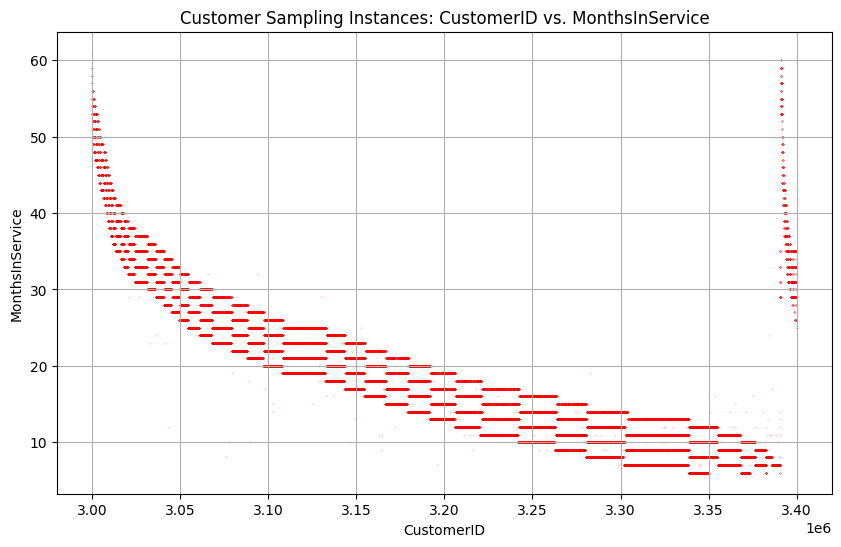

In [ ]:
# Plot Scatter graph of CustomerID vs MonthsInService
plt.figure(figsize=(10, 6))
plt.scatter(
    cell2cell_df['CustomerID'],
    cell2cell_df['MonthsInService'],
    c='red',
    s=0.01,
)

plt.title('Customer Sampling Instances: CustomerID vs. MonthsInService')
plt.xlabel('CustomerID')
plt.ylabel('MonthsInService')
plt.grid(True)
plt.savefig('customer_sampling.png', dpi=300)
plt.show()

The plot suggests that each customer is represented by up to four separate records, likely corresponding to sampling in July, September, November, and December. This indicates that `CustomerID` identifies a unique sampling instance, rather than a unique customer.

In [ ]:
# Check class balance of 'train' dataset
total_customers = cell2cell_df.shape[0]
churners = cell2cell_df['Churn'].value_counts()['Yes']
nonchurners = cell2cell_df['Churn'].value_counts()['No']
print(f'{churners} churners     ({(churners/total_customers*100):.2f}%)')
print(f'{nonchurners} non-churners ({(nonchurners/total_customers*100):.2f}%)')

14711 churners     (28.82%)
36336 non-churners (71.18%)


Due to oversampling, the dataset **cell2cell_df** is relatively balanced, with churners comprising **28.82%** of the total sample. This stands in contrast to the reported true churn rate of approximately **1.8%** in the broader customer population.$^{1}$

In [ ]:
# Display the first 5 rows of the 'holdout' dataset
cell2cellholdout_df.head()

CustomerID  Churn  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
0     3000006    NaN           57.49           483.0                  37.0   
1     3000018    NaN           55.23           570.0                  72.0   
2     3000034    NaN           97.34          1039.0                  50.0   
3     3000070    NaN           35.59           153.0                  30.0   
4     3000074    NaN           55.27          1213.0                  50.0   

   DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
0                   0.25            23.0           0.0              532.0   
1                   0.00             0.0           0.0               38.0   
2                   4.95           420.0           0.0              198.0   
3                   0.00            16.0           0.0               30.0   
4                   0.74             0.0           1.3              169.0   

   PercChangeRevenues  ...  ReferralsMadeBySubscriber  IncomeGroup  \
0                51.0  ...                          0            5   
1                 0.0  ...                          0            6   
2                23.3  ...                          0            4   
3                 7.3  ...                          0            4   
4                 1.0  ...                          0            3   

   OwnsMotorcycle  AdjustmentsToCreditRating  HandsetPrice  \
0              No                          1           150   
1              No                          2            80   
2              No                          3            10   
3              No                          1           200   
4              No                          0            10   

   MadeCallToRetentionTeam  CreditRating  PrizmCode    Occupation  \
0                       No         5-Low      Other         Other   
1                       No     1-Highest      Other  Professional   
2                       No        3-Good   Suburban        Crafts   
3                       No     1-Highest      Other         Other   
4                       No     1-Highest   Suburban         Other   

   MaritalStatus  
0             No  
1             No  
2            Yes  
3             No  
4             No  

[5 rows x 58 columns]

The dataset **cells2cellholdout_df** does not include values for the target variable (`Churn`) and will therefore be excluded from this analysis.

### 4 Data Cleaning


We check for missing values.

In [ ]:
# Check for missing values
cell2cell_df.isna().sum().sort_values(ascending=False).head(15)

AgeHH1                   909
AgeHH2                   909
PercChangeRevenues       367
PercChangeMinutes        367
DirectorAssistedCalls    156
TotalRecurringCharge     156
RoamingCalls             156
OverageMinutes           156
MonthlyRevenue           156
MonthlyMinutes           156
ServiceArea               24
Handsets                   1
HandsetModels              1
CurrentEquipmentDays       1
DroppedCalls               0
dtype: int64

In [ ]:
# Drop rows with missing values
subset_cell2cell_df = cell2cell_df.dropna()

# check size of dataset
subset_cell2cell_df.shape

(49752, 58)

In [ ]:
# Count MaritalStatus categories by value
subset_cell2cell_df['MaritalStatus'].value_counts()

MaritalStatus
Unknown    18649
Yes        18506
No         12597
Name: count, dtype: int64

Due to the high proportion of 'Unknown' values in the `MaritalStatus` field, we retain these entries in the dataset to preserve the overall sample size and distribution.

We check for duplicate entries and remove if necessary.

In [ ]:
# Check for duplicate rows
subset_cell2cell_df.duplicated().sum()

np.int64(0)

We check for duplicate columns and remove if necessary.

In [ ]:
# Check for duplicate columns
subset_cell2cell_df.columns[subset_cell2cell_df.T.duplicated()]

Index([], dtype='object')

We check the data types of the columns.

In [ ]:
# Check data types of columns
subset_cell2cell_df.dtypes

CustomerID                     int64
Churn                         object
MonthlyRevenue               float64
MonthlyMinutes               float64
TotalRecurringCharge         float64
DirectorAssistedCalls        float64
OverageMinutes               float64
RoamingCalls                 float64
PercChangeMinutes            float64
PercChangeRevenues           float64
DroppedCalls                 float64
BlockedCalls                 float64
UnansweredCalls              float64
CustomerCareCalls            float64
ThreewayCalls                float64
ReceivedCalls                float64
OutboundCalls                float64
InboundCalls                 float64
PeakCallsInOut               float64
OffPeakCallsInOut            float64
DroppedBlockedCalls          float64
CallForwardingCalls          float64
CallWaitingCalls             float64
MonthsInService                int64
UniqueSubs                     int64
ActiveSubs                     int64
ServiceArea                   object
Handsets                     float64
HandsetModels                float64
CurrentEquipmentDays         float64
AgeHH1                       float64
AgeHH2                       float64
ChildrenInHH                  object
HandsetRefurbished            object
HandsetWebCapable             object
TruckOwner                    object
RVOwner                       object
Homeownership                 object
BuysViaMailOrder              object
RespondsToMailOffers          object
OptOutMailings                object
NonUSTravel                   object
OwnsComputer                  object
HasCreditCard                 object
RetentionCalls                 int64
RetentionOffersAccepted        int64
NewCellphoneUser              object
NotNewCellphoneUser           object
ReferralsMadeBySubscriber      int64
IncomeGroup                    int64
OwnsMotorcycle                object
AdjustmentsToCreditRating      int64
HandsetPrice                  object
MadeCallToRetentionTeam       object
CreditRating                  object
PrizmCode                     object
Occupation                    object
MaritalStatus                 object
dtype: object

We convert the following columns from *float64* to *int64* to reflect their nature as discrete, whole-number values: `Handsets`; `HandsetModels`; `CurrentEquipmentDays`; `AgeHH1`; `AgeHH2`.

In [ ]:
# Create a deep copy of the DataFrame
subset2_cell2cell_df = subset_cell2cell_df.copy()

# Convert columns from float64 to int64
cols = ['Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2']
subset2_cell2cell_df[cols] = subset2_cell2cell_df[cols].astype('int64')

In [ ]:
# Check values of AgeHH1 & AgeHH2
count_agehh1_zero = (subset2_cell2cell_df['AgeHH1'] == 0).sum()
count_agehh2_zero = (subset2_cell2cell_df['AgeHH2'] == 0).sum()
minimum_agehh1 = subset2_cell2cell_df[subset2_cell2cell_df['AgeHH1'] != 0]['AgeHH1'].min()
minimum_agehh2 = subset2_cell2cell_df[subset2_cell2cell_df['AgeHH2'] != 0]['AgeHH2'].min()
print(f"Number of entries with AgeHH1 equal to 0: {count_agehh1_zero} of {subset2_cell2cell_df.shape[0]}")
print(f"Number of entries with AgeHH2 equal to 0: {count_agehh2_zero} of {subset2_cell2cell_df.shape[0]}")
print(f"Minimum non-zero AgeHH1 is: {minimum_agehh1}")
print(f"Minimum non-zero AgeHH2 is: {minimum_agehh2}")

Number of entries with AgeHH1 equal to 0: 13808 of 49752
Number of entries with AgeHH2 equal to 0: 25877 of 49752
Minimum non-zero AgeHH1 is: 18
Minimum non-zero AgeHH2 is: 18


We observe that a large proportion of the dataset contains `AgeHH1` and/or `AgeHH2` values equal to zero. This likely indicates that the customer has not disclosed their age, or in the case of `AgeHH2`, that the household consists of a single person.

We create two flags - `AgeHH1MissingFlag` and `AgeHH2MissingFlag` - to preserve this potentially informative pattern.

In [ ]:
# Flag missing data
subset2_cell2cell_df['AgeHH1MissingFlag'] = (subset2_cell2cell_df['AgeHH1'] == 0).astype(int)
subset2_cell2cell_df['AgeHH2MissingFlag'] = (subset2_cell2cell_df['AgeHH2'] == 0).astype(int)

# Create copy of dataframe
subset3_cell2cell_df = subset2_cell2cell_df.copy()

In [ ]:
# Check values of HandsetPrice
subset3_cell2cell_df.groupby('HandsetPrice')['HandsetModels'].agg(
    CustomerCount='count',
    AvgHandsetModels='mean'
      ).sort_values(by='AvgHandsetModels').reset_index()

HandsetPrice  CustomerCount  AvgHandsetModels
0       Unknown          28263          1.006899
1            60           1730          2.117341
2            30           7147          2.135162
3           150           4024          2.152087
4           200           1227          2.392828
5            80           1901          2.409784
6           130           2043          2.426334
7            10           1869          2.492242
8           100           1209          2.717949
9            40            240          2.937500
10          250             20          3.350000
11          400             45          3.688889
12          180              9          3.777778
13          500              7          4.000000
14          300             12          4.583333
15          240              6          5.833333

We observe that a majority of the `HandsetPrice` values in the dataset are labeled as 'Unknown', typically corresponding to customers who have only one handset model and have not undergone an upgrade.

We create a binary flag, `HandsetPriceUnknownFlag`, to indicate entries with unknown handset prices. For analytical purposes, we replace 'Unknown' values in the `HandsetPrice` variable with 0 to enable quantitative analysis

In [ ]:
# Flag missing data
subset3_cell2cell_df['HandsetPriceUnknownFlag'] = (subset3_cell2cell_df['HandsetPrice'] == 'Unknown').astype(int)

# Replace 'Unknown' HandsetPrice with 0
subset4_cell2cell_df = subset3_cell2cell_df.copy()
subset4_cell2cell_df['HandsetPrice'] = subset4_cell2cell_df['HandsetPrice'].replace('Unknown', '0')

# Convert HandsetPrice to numeric
subset4_cell2cell_df['HandsetPrice'] = pd.to_numeric(subset4_cell2cell_df['HandsetPrice'])

We rename the `Occupation` label 'Self' as 'Self-Employed'.

In [ ]:
# Replace Occupation label 'Self' with 'Self-Employed'
subset5_cell2cell_df = subset4_cell2cell_df.copy()
subset5_cell2cell_df.loc[subset5_cell2cell_df['Occupation'] == 'Self', 'Occupation'] = 'Self-Employed'

We examine the distributions of `ActiveSubs` and `UniqueSubs` to identify potential outliers or anomalous customers.

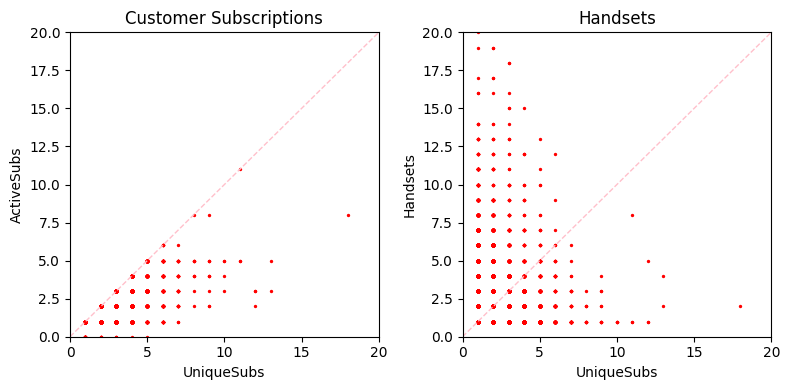

In [ ]:
# Plot Scatter graph of UniqueSubs vs. ActiveSubs
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
line_vals = np.linspace(0, 20, 100)
plt.plot(line_vals, line_vals, color='pink', linestyle='--', linewidth=1, label='ActiveSubs = UniqueSubs')
plt.scatter(
    subset5_cell2cell_df['UniqueSubs'],
    subset5_cell2cell_df['ActiveSubs'],
    c='red',
    s=2,
)
plt.xlabel('UniqueSubs')
plt.ylabel('ActiveSubs')
plt.title('Customer Subscriptions')
plt.xlim(0,20)
plt.ylim(0,20)

# Plot Scatter graph of UniqueSubs vs. Handsets
plt.subplot(1, 2, 2)
line_vals = np.linspace(0, 20, 100)
plt.plot(line_vals, line_vals, color='pink', linestyle='--', linewidth=1)
plt.scatter(
    subset5_cell2cell_df['UniqueSubs'],
    subset5_cell2cell_df['Handsets'],
    c='red',
    s=2,
)
plt.xlabel('UniqueSubs')
plt.ylabel('Handsets')
plt.title('Handsets')
plt.xlim(0,20)
plt.ylim(0,20)
plt.tight_layout()
plt.show()


# Create boxplots of ActiveSubs and UniqueSubs
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.boxplot(x = 'ActiveSubs', data = subset5_cell2cell_df, color="pink")
plt.title('')
plt.xlabel('ActiveSubs')
plt.subplot(1, 2, 2)
sns.boxplot(x = 'UniqueSubs', data = subset5_cell2cell_df, color="pink")
plt.title('')
plt.xlabel('UniqueSubs')
plt.tight_layout()
plt.suptitle('Boxplots to Identify Outliers in ActiveSubs and UniqueSubs', fontsize=16, y=1.02)
plt.show()

The scatterplot confirms that `UniqueSubs` is always greater than or equal to `ActiveSubs`, as expected. However, it is somewhat surprising that, for some customers, the number of `Handsets` is less than the number of `UniqueSubs`. This may indicate cases where customers are using SIM-only plans or have not acquired all handsets through the provider.

Boxplots of the subscription data reveal a small number of extreme outliers — for example, one customer with **196** unique mobile subscriptions, **53** of which are active. To reduce the influence of such atypical cases on subsequent analysis, we apply interquartile range (IQR) filtering and remove rows where `UniqueSubs` falls outside the IQR bounds.

In [ ]:
# Filter out UniqueSubs rows with outliers
percentile25 = subset5_cell2cell_df['UniqueSubs'].quantile(0.25)
percentile75 = subset5_cell2cell_df['UniqueSubs'].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
subset6_cell2cell_df = subset5_cell2cell_df[
    (subset5_cell2cell_df['UniqueSubs'] >= lower_limit) &
    (subset5_cell2cell_df['UniqueSubs'] <= upper_limit)
]

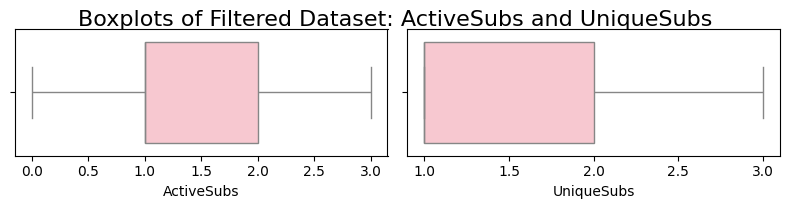

In [ ]:
# Create boxplots of continuous numerical variables
plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1)
sns.boxplot(x = 'ActiveSubs', data = subset6_cell2cell_df, color="pink")
plt.title('')
plt.xlabel('ActiveSubs')
plt.subplot(1, 2, 2)
sns.boxplot(x = 'UniqueSubs', data = subset6_cell2cell_df, color="pink")
plt.title('')
plt.xlabel('UniqueSubs')
plt.tight_layout()
plt.suptitle('Boxplots of Filtered Dataset: ActiveSubs and UniqueSubs', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Create copy of cleaned dataframe
cleaned_df=subset6_cell2cell_df.copy()

## 5 Exploratory Feature Assessment

### 5.1 Binary categorical variables



We convert all binary variables, including the target variable `Churn`, into numerical format (1/0).

In [ ]:
# Map Yes/No to 1/0
yes_no_columns = [
    'Churn', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable',
    'TruckOwner', 'RVOwner', 'BuysViaMailOrder', 'RespondsToMailOffers',
    'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
    'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam'
]
cleaned_df[yes_no_columns] = cleaned_df[yes_no_columns].replace({'Yes': 1, 'No': 0})

# Map Known/Unknown to 1/0
cleaned_df['Homeownership'] = cleaned_df['Homeownership'].map({'Known': 1, 'Unknown': 0})

We plot the churn rate for each binary variable.

In [ ]:
# List of all binary variables
binary_cols = ['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'BuysViaMailOrder',
               'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
               'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'Homeownership', 'AgeHH1MissingFlag',
               'AgeHH2MissingFlag', 'HandsetPriceUnknownFlag']

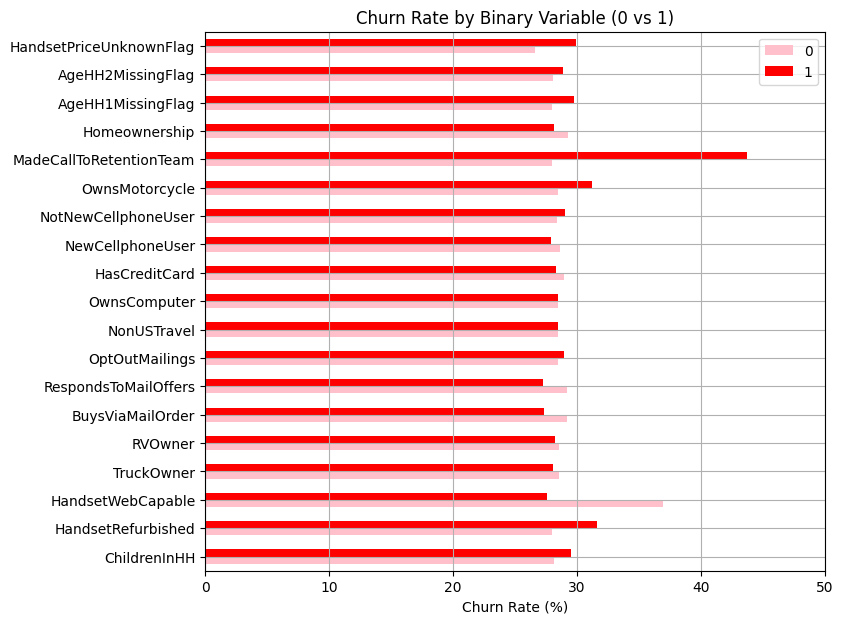

0          1
ChildrenInHH             28.156785  29.496834
HandsetRefurbished       27.987817  31.590117
HandsetWebCapable        36.917486  27.571788
TruckOwner               28.573631  28.094237
RVOwner                  28.503655  28.253644
BuysViaMailOrder         29.163242  27.304843
RespondsToMailOffers     29.219050  27.290118
OptOutMailings           28.476176  28.947368
NonUSTravel              28.486161  28.435324
OwnsComputer             28.480250  28.496425
HasCreditCard            28.948945  28.270900
NewCellphoneUser         28.621625  27.904968
NotNewCellphoneUser      28.394347  29.050623
OwnsMotorcycle           28.446144  31.211180
MadeCallToRetentionTeam  27.971727  43.689942
Homeownership            29.226509  28.127505
AgeHH1MissingFlag        28.004509  29.722451
AgeHH2MissingFlag        28.037751  28.889864
HandsetPriceUnknownFlag  26.611378  29.894683

In [ ]:
# Calculate churn rate
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

# Plot churn rates
churn_df = pd.DataFrame(churn_rates).T
churn_df.columns = ['0', '1']

churn_df.plot(kind='barh', figsize=(8, 7), legend=True, color=['pink', 'red'])
plt.xlim(0,50)
plt.title('Churn Rate by Binary Variable (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.grid(True)
plt.savefig('base_features_binary_flags.png', dpi=300)
plt.show()
churn_df

We observe the following associations between binary categorical features and customer churn:

 * **Retention-Contact Churners**: Customers who have contacted the Retention  Team are **13.7%** more likely to churn than those who have not.

 * **Legacy Device Churners:** Customers with an older, non-web-capable mobile are **9.4%** more likely to churn than those using a web-capable smartphone (`HandsetWebCapable`). Similarly, customers who own a refurbished handset (`HandsetRefurbished`) are **3.6%** more likely to churn that those with a new handset.

 * **Low-Disclosure Churners**: Customers with missing or unknown values in `HandsetPriceUnknown`, `AgeHH1MissingFlag`, `AgeHH2MissingFlag`, or `Homeownership` exhibit an increased propensity to churn, with up to a **3%** higher churn rate compared to customers with complete data.

 * **Churn-Prone Motorcyclists:** Perhaps surprisingly, customers who own a motorcycle are **2.8%** more likely to churn than those who do not.

 * **Engaged Loyalists:** Customers who respond to mail offers (`RespondsToMailOffers`) or buy via mail order (`BuysViaMailOrder`) are **~2%** less likely to churn.

 * **Family Household Churners:** Customers with children in the household (`ChildrenInHH`) are **1.3%** more likely to churn than those without.

 * **First-Time Users:** New users are **0.7%** more likely to churn than seasoned adopters, although there is some unexplained inconsistency in the data between `NewCellphoneUser` and `NotNewCellphoneUser`.

Features such as `HasCreditCard`, `OwnsComputer`, `NonUSTravel`, `OptOutMailings`, `RVOwner`, and `TruckOwner` show little to no meaningful correlation with churn.

### 5.2 Nominal categorical variables

We generate bar plots to examine the distribution of the nominal categorical features `PrizmCode`, `Occupation`, and `MaritalStatus`.

In [ ]:
# Define function for ChurnRate
def ChurnRateByVar(var):
  return cleaned_df.groupby(var)['Churn'].agg(
      ChurnRate=lambda x: x.mean() * 100,
      CustomerCount='count'
      ).reset_index()

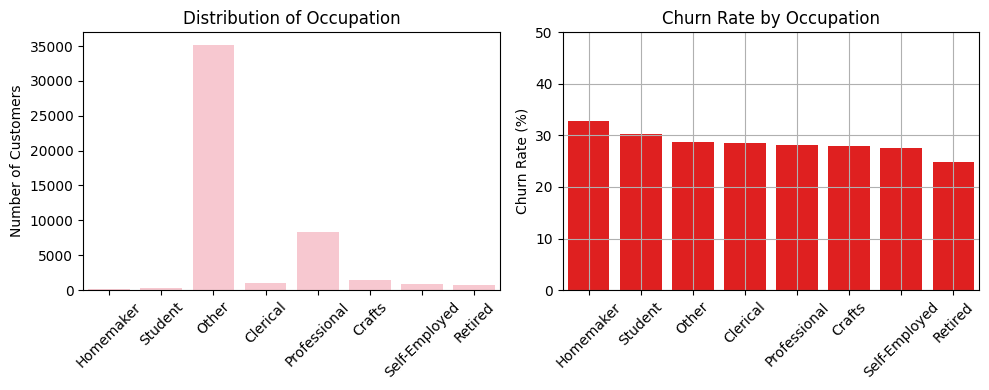

In [ ]:
# Define function for nominal categorical plots
def PlotChurnRate_NomCatVar(var):
  ChurnRateByVar_df = ChurnRateByVar(var)
  plt.figure(figsize=(10, 4))
  plt.subplot(1,2,1)
  ax = sns.barplot(
      x=var,
      y='CustomerCount',
      data=ChurnRateByVar_df.sort_values(by='ChurnRate', ascending=False),
      color='Pink'
      )
  plt.xlabel('')
  plt.xticks(rotation=45)
  plt.ylabel('Number of Customers')
  plt.title(f'Distribution of {var}')

  # Plot ChurnRate
  plt.subplot(1,2,2)
  ax = sns.barplot(
      x=var,
      y="ChurnRate",
      data=ChurnRateByVar_df.sort_values(by='ChurnRate', ascending=False),
      color='Red'
      )
  plt.ylabel('Churn Rate (%)')
  plt.xticks(rotation=45)
  ax.set_ylim(0, 50)
  plt.xlabel('')
  plt.title(f'Churn Rate by {var}')
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(f'base_features_{var}.png', dpi=300)
  plt.show()

PlotChurnRate_NomCatVar('PrizmCode')
PlotChurnRate_NomCatVar('Occupation')
PlotChurnRate_NomCatVar('MaritalStatus')

We observe the following associations between nominal categorical features and customer churn:

* **Surburban Stayers vs Rural Switchers:** Customers classified by the `PrizmCode` as living in *Suburban* areas exhibit a lower propensity to churn (**27.90%**) compared to *Rural* customers (**31.33%**).

* **Retired Loyalists:** Customers whose `Occupation` is recorded as *Retired* exhibit a lower than average churn rate (**24.86%**).

* **Married Movers:** Married customers exhibit a slightly higher propensity to churn (**29.88%**) compared to unmarried customers (**26.69%**).

A significant caveat is that, for all three features, a large proportion of customers fall into the *Other* (`PrizmCode` and `Occupation`) or *Unknown* (`MaritalStatus) categories, which limits the interpretability and predictive utility of these observed correlations.

In [ ]:
# Check cardinality of 'ServiceArea'
print(cleaned_df['ServiceArea'].nunique())

# Check that first 6 characters of ServiceArea are alphabetic
print(cleaned_df['ServiceArea'].str[:6].str.isalpha().all())

# Check that last 3 characters of ServiceArea are numeric
print(cleaned_df['ServiceArea'].str[6:9].str.isdigit().all())

739
True
True


We observe that `ServiceArea` consistently follows an alphanumeric format comprising a six-letter prefix and a three-digit suffix. Given its high cardinality, it may be advantageous to decompose this variable to reduce dimensionality and enhance interpretability.

#### 5.3 Ordinal categorical variables

We generate bar plots and heat maps to examine the distribution of the ordinal categorical features `CreditRating` and `MonthlyRevenue`, and their correlation with customer churn.

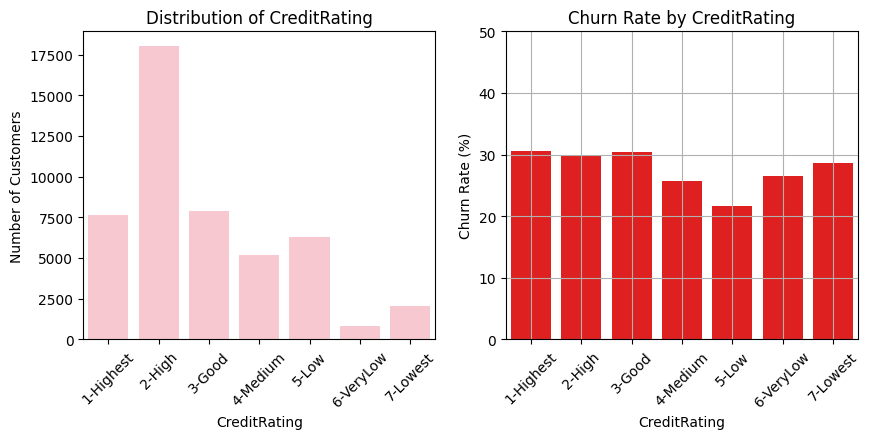

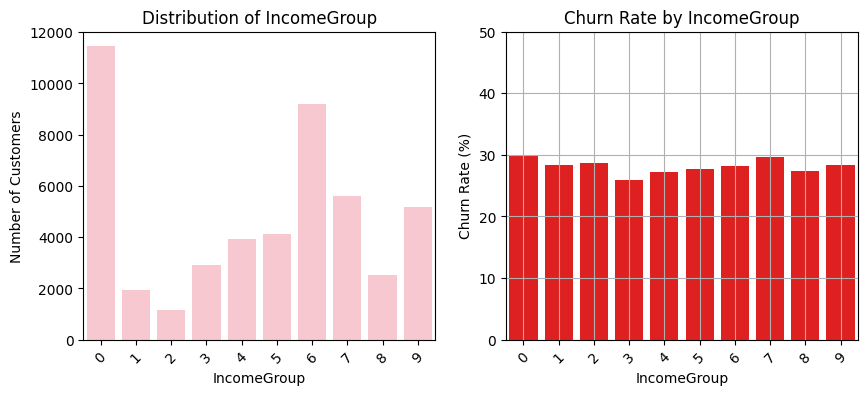

In [ ]:
# Define function for barplots
def PlotChurnRateNom(var):
  ChurnRateByVar_df = ChurnRateByVar(var)

  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  sns.barplot(x=var, y='CustomerCount', data=ChurnRateByVar_df, color='Pink')
  plt.title(f'Distribution of {var}')
  plt.ylabel('Number of Customers')
  plt.xlabel(var)
  plt.xticks(rotation=45)

  plt.subplot(1, 2, 2)
  sns.barplot(x=var, y='ChurnRate', data=ChurnRateByVar_df, color='Red')
  plt.title(f'Churn Rate by {var}')
  plt.ylabel('Churn Rate (%)')
  plt.xlabel(var)
  plt.xticks(rotation=45)
  plt.grid(True)
  plt.ylim(0,50)

  plt.show()

# Create barplots
PlotChurnRateNom('CreditRating')
PlotChurnRateNom('IncomeGroup')

In [ ]:
# Plot heatmap
heatmap_data = cleaned_df.pivot_table(
    index='CreditRating',
    columns='IncomeGroup',
    values='Churn',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Churn Rate'})
plt.title("Churn Rate by Income Group and Credit Rating")
plt.xlabel("Income Group")
plt.ylabel("Credit Rating")
plt.show()

We infer that the `IncomeGroup` variable ranges from 0 (Highest income) to 9 (Lowest income), based on its observed relationship with other variables such as `HandsetPrice` and `MonthlyRevenue`. Based on this assumption, we observe the following patterns:

* **High-Expectation Churners:** customers with higher `CreditRating` ranking (from 3-Good to 1-Highest) exhibit a higher propensity to churn (**~30%**). This may reflect increased expectations of service quality and a greater ease or willingness to switch providers.

* **Financially Anchored Loyalists:** Conversely, customers with low `CreditRating` (5-Low) who fall into the medium to high income groups (`IncomeGroup` 1 – 5) display a lower propensity to churn (**17** - **20%**). This may suggest that while these individuals have sufficient disposable income, limited access to credit reduces their flexibility to change providers.

### 5.4 Discrete numerical variables

We plot normalised distributions of discrete numerical features segmented by churn status.

In [ ]:
# List discrete numerical variables
discrete_num_vars = ['MonthsInService', 'CurrentEquipmentDays', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels',
                     'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'AdjustmentsToCreditRating']

In [ ]:
# Define function to plot churn rate by discrete numerical variable
def PlotChurnRateDiscrete(var, xmin=0, xmax=None, ymax=50):
  """
  Plot churn rate for discrete variable

  Parameters:
  - var: str, the name of the variable
  - xmax: float, upper limit for x-axis (var)
  - ymax: float, upper limit for y-axis (churn rate)
  """
  churnrate_var_df = ChurnRateByVar(var)
  plt.plot(churnrate_var_df[var], churnrate_var_df['ChurnRate'], marker='.', linestyle='-', color='Pink', markerfacecolor='Red', markeredgecolor='Red')
  plt.xlabel(var)
  plt.xlim(xmin, xmax)
  plt.ylim(0,ymax)
  plt.ylabel('Churn Rate (%)')
  plt.grid(True)

In [ ]:
# Define function to plot normalised distribution
def PlotNormDist(var, xmax, xmin=0, bins=50):
  """
  Plot normalised distribution for a variable split by Churn status.

  Parameters:
  - var: str, the name of the variable to plot
  - xmax: float, upper limit for x-axis
  - bins: int, number of histogram bins
  """
  var_churn = cleaned_df.loc[(cleaned_df['Churn'] == 1), var].dropna()
  var_nochurn = cleaned_df.loc[(cleaned_df['Churn'] == 0), var].dropna()
  bins = np.linspace(xmin, xmax, bins)
  hist_churn, _ = np.histogram(var_churn, bins=bins, density=True)
  hist_nochurn, _ = np.histogram(var_nochurn, bins=bins, density=True)
  plt.bar(bins[:-1], hist_churn, width=np.diff(bins), color='red', alpha=0.6, label='Churners')
  plt.bar(bins[:-1], -hist_nochurn, width=np.diff(bins), color='pink', alpha=0.6, label='Non-Churners')
  plt.xlim(xmin, xmax)
  plt.xlabel(var)
  plt.ylabel('Density')
  plt.legend()
  plt.axhline(0, color='black', linewidth=0.8)

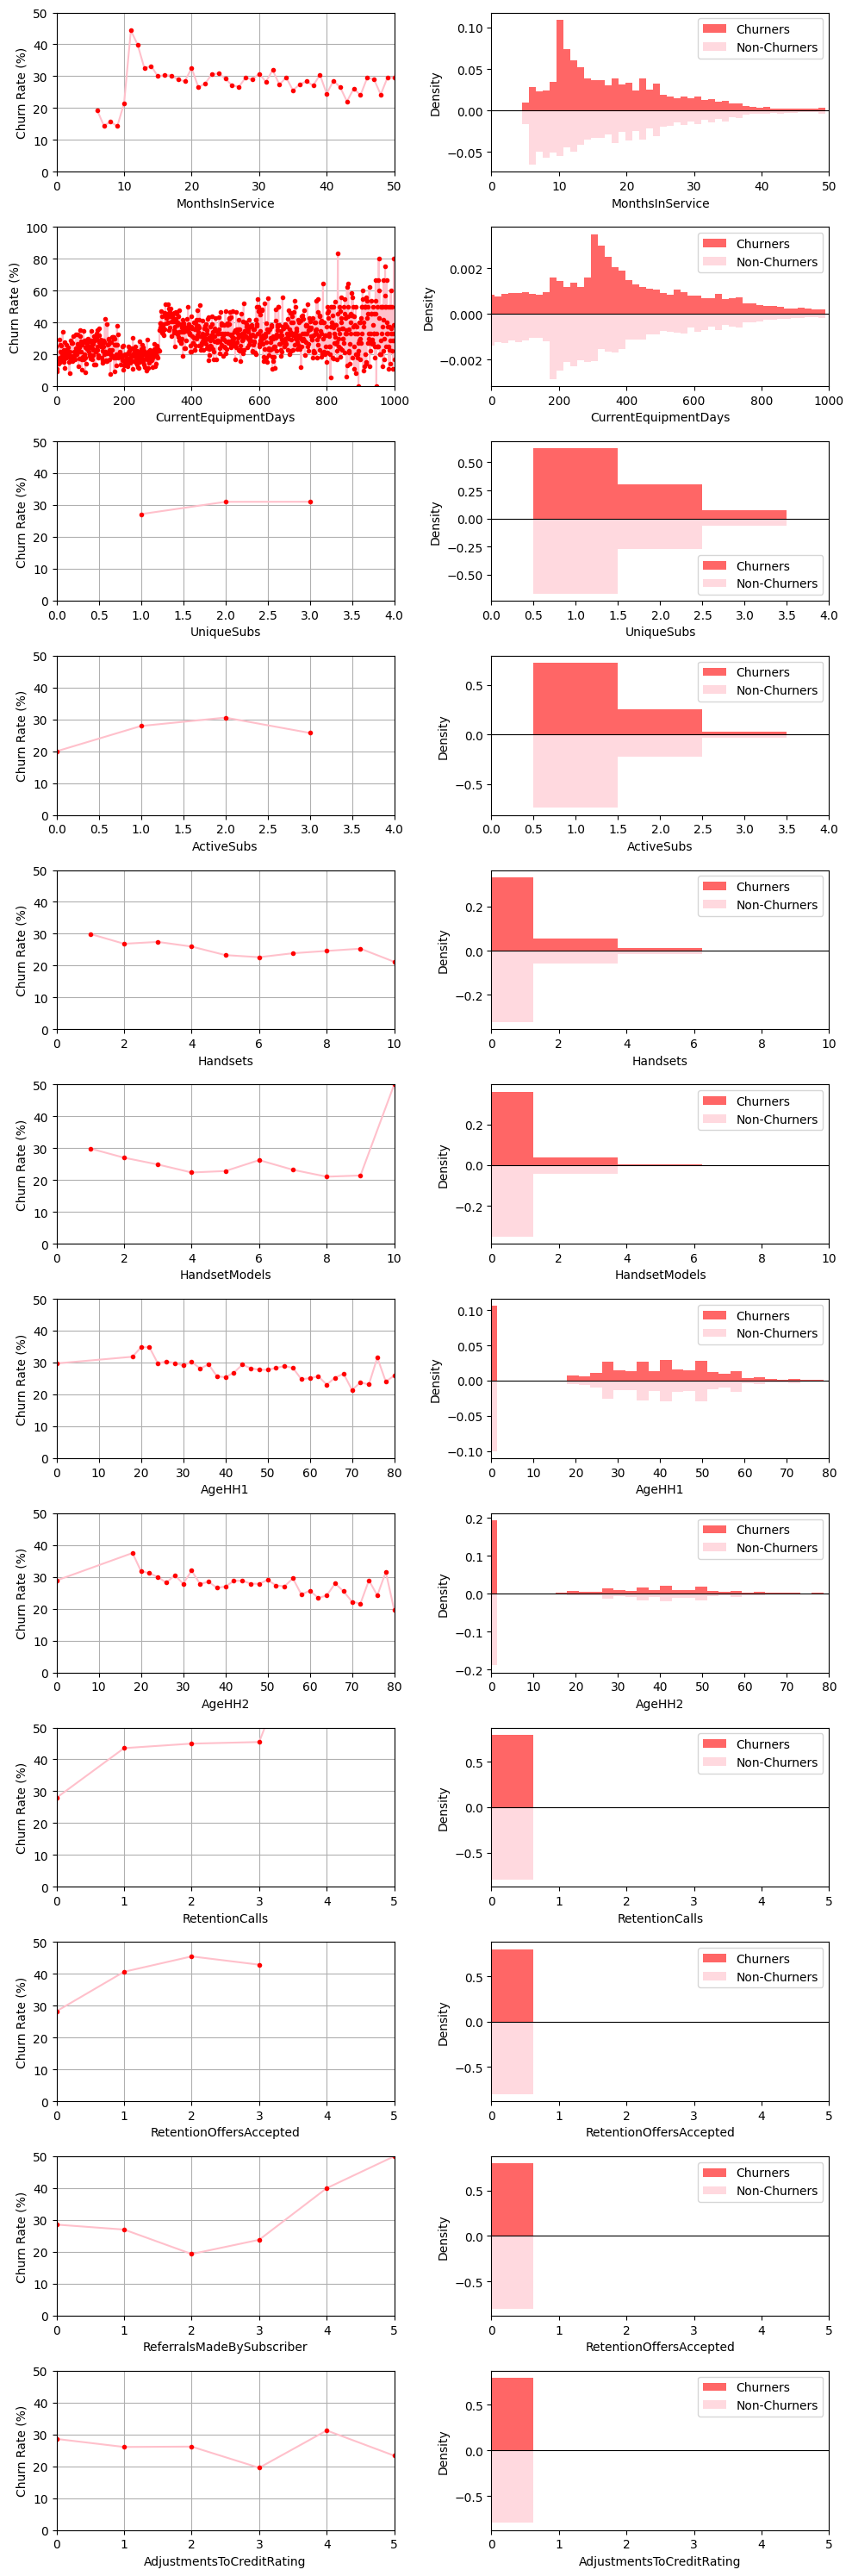

In [ ]:
# Plot Churn Rates for all variables
plt.figure(figsize=(10, 30))
plt.subplot(12, 2, 1)
PlotChurnRateDiscrete('MonthsInService', xmax=50)
plt.subplot(12, 2, 2)
PlotNormDist('MonthsInService', xmax=50)

plt.subplot(12, 2, 3)
PlotChurnRateDiscrete('CurrentEquipmentDays', xmax=1000, ymax=100)
plt.subplot(12, 2, 4)
PlotNormDist('CurrentEquipmentDays', xmax=1000)

plt.subplot(12, 2, 5)
PlotChurnRateDiscrete('UniqueSubs', xmax=4)
plt.subplot(12, 2, 6)
PlotNormDist('UniqueSubs', xmax=4, bins=5)

plt.subplot(12, 2, 7)
PlotChurnRateDiscrete('ActiveSubs', xmax=4)
plt.subplot(12, 2, 8)
PlotNormDist('ActiveSubs', xmax=4, bins=5)

plt.subplot(12, 2, 9)
PlotChurnRateDiscrete('Handsets', xmax=10)
plt.subplot(12, 2, 10)
PlotNormDist('Handsets', xmax=10, bins=5)

plt.subplot(12, 2, 11)
PlotChurnRateDiscrete('HandsetModels', xmax=10)
plt.subplot(12, 2, 12)
PlotNormDist('HandsetModels', xmax=10, bins=5)

plt.subplot(12, 2, 13)
PlotChurnRateDiscrete('AgeHH1', xmax=80)
plt.subplot(12, 2, 14)
PlotNormDist('AgeHH1', xmax=80, bins=30)

plt.subplot(12, 2, 15)
PlotChurnRateDiscrete('AgeHH2', xmax=80)
plt.subplot(12, 2, 16)
PlotNormDist('AgeHH2', xmax=80, bins=30)

plt.subplot(12, 2, 17)
PlotChurnRateDiscrete('RetentionCalls', xmax=5)
plt.subplot(12, 2, 18)
PlotNormDist('RetentionCalls', xmax=5, bins=5)

plt.subplot(12, 2, 19)
PlotChurnRateDiscrete('RetentionOffersAccepted', xmax=5)
plt.subplot(12, 2, 20)
PlotNormDist('RetentionOffersAccepted', xmax=5, bins=5)

plt.subplot(12, 2, 21)
PlotChurnRateDiscrete('ReferralsMadeBySubscriber', xmax=5)
plt.subplot(12, 2, 22)
PlotNormDist('RetentionOffersAccepted', xmax=5, bins=5)

plt.subplot(12, 2, 23)
PlotChurnRateDiscrete('AdjustmentsToCreditRating', xmax=5)
plt.subplot(12, 2, 24)
PlotNormDist('AdjustmentsToCreditRating', xmax=5, bins=5)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate AUC & Kendall's Tau-b for discrete variables
Table_Variables_Discrete = []
for var in discrete_num_vars:
  tau, p_value = kendalltau(cleaned_df[var], cleaned_df['Churn'])
  auc = roc_auc_score(y_true=cleaned_df['Churn'], y_score=cleaned_df[var])
  Table_Variables_Discrete.append({'Variable': var, 'AUC': round(auc,3), 'KendallsTau-b': round(tau,3), 'p-value_KendallsTau-b': round(p_value,3)})

Table_Variables_Discrete_df = pd.DataFrame(Table_Variables_Discrete)
Table_Variables_Discrete_df

Variable    AUC  KendallsTau-b  p-value_KendallsTau-b
0             MonthsInService  0.525          0.033                  0.000
1        CurrentEquipmentDays  0.575          0.095                  0.000
2                  UniqueSubs  0.521          0.039                  0.000
3                  ActiveSubs  0.509          0.019                  0.000
4                    Handsets  0.478         -0.036                  0.000
5               HandsetModels  0.476         -0.041                  0.000
6                      AgeHH1  0.482         -0.024                  0.000
7                      AgeHH2  0.490         -0.014                  0.000
8              RetentionCalls  0.512          0.062                  0.000
9     RetentionOffersAccepted  0.505          0.036                  0.000
10  ReferralsMadeBySubscriber  0.498         -0.009                  0.045
11  AdjustmentsToCreditRating  0.497         -0.012                  0.006

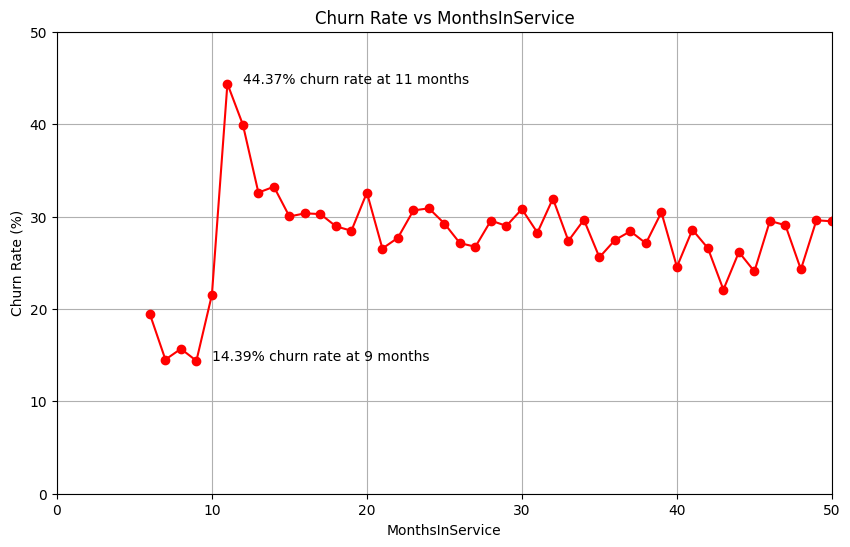

Mean tenure for customers who have churned:     19.03 months
Mean tenure for customers who have not churned: 18.61 months


In [ ]:
# Plot Churn Rate by MonthsInService
churnrate_MonthsInService_df = ChurnRateByVar('MonthsInService')
plt.figure(figsize=(10, 6))
plt.plot(churnrate_MonthsInService_df['MonthsInService'], churnrate_MonthsInService_df['ChurnRate'], marker='o', linestyle='-', color='Red')
plt.xlabel('MonthsInService')
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate vs MonthsInService')
plt.grid(True)

peak_idx = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)]['ChurnRate'].idxmax()
peak_month = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)].loc[peak_idx, 'MonthsInService']
peak_value = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)].loc[peak_idx, 'ChurnRate']
trough_idx = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)]['ChurnRate'].idxmin()
trough_month = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)].loc[trough_idx, 'MonthsInService']
trough_value = churnrate_MonthsInService_df[(churnrate_MonthsInService_df['MonthsInService'] < 50)].loc[trough_idx, 'ChurnRate']
plt.annotate(f'{peak_value:.2f}% churn rate at {peak_month} months',
             xy=(peak_month + 1, peak_value))
plt.annotate(f'{trough_value:.2f}% churn rate at {trough_month} months',
             xy=(trough_month + 1, trough_value))
plt.show()

# Statistics for customer tenure
print(f"Mean tenure for customers who have churned:     {round(cleaned_df[(cleaned_df['Churn'] == 1)]['MonthsInService'].mean(),2)} months")
print(f"Mean tenure for customers who have not churned: {round(cleaned_df[(cleaned_df['Churn'] == 0)]['MonthsInService'].mean(),2)} months")

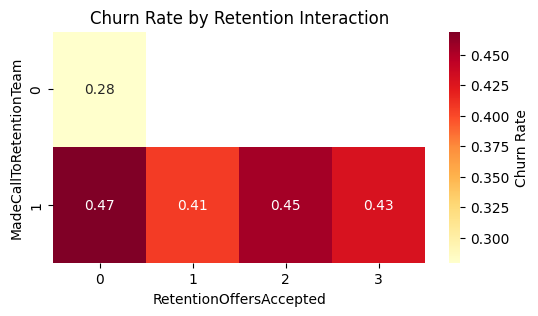

Number of customers who call the Retention Team:       1561 (3.25%)
Number of customers 'contacted' by the Retention Team: 1561 (3.25%)


In [ ]:
# Plot heatmap of Churn Rate by IncomeGroup and CreditRating
heatmap_data = cleaned_df.pivot_table(
    index='MadeCallToRetentionTeam',
    columns='RetentionOffersAccepted',
    values='Churn',
    aggfunc='mean'
)

plt.figure(figsize=(6, 3))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Churn Rate'})
plt.title("Churn Rate by Retention Interaction")
plt.xlabel("RetentionOffersAccepted")
plt.ylabel("MadeCallToRetentionTeam")
plt.show()

# Statistics for customers who churn
cleaned_df[(cleaned_df['Churn'] == 1)].groupby('RetentionOffersAccepted')[['MonthsInService', 'UniqueSubs']].mean()

# Calculate statistics for calls made/received by Retention Team
number_customers_who_call_RT = cleaned_df['MadeCallToRetentionTeam'].sum()
number_customers_contacted_by_RT = (cleaned_df['RetentionCalls'] > 0).sum()
number_customers = cleaned_df.shape[0]

print(f'Number of customers who call the Retention Team:       {number_customers_who_call_RT} ({round(number_customers_who_call_RT/number_customers*100, 2)}%)')
print(f"Number of customers 'contacted' by the Retention Team: {number_customers_contacted_by_RT} ({round(number_customers_contacted_by_RT/number_customers*100, 2)}%)")

We observe the following relationships between discrete base features and customer churn:

* **Contract-Cycle Churners:** Customers with 11 months of tenure (`MonthsInService`) show a sharp churn spike of **44.37%**, likely aligning with the expiry of standard 12-month contracts. This marks a critical window for targeted retention efforts, as these customers may be evaluating renewal or switching options.

* **Upgrade-Deprived Deserters:** Longer tenure does not guarantee retention — churn rate begins to rise again beyond 16 months, particularly for customers who have not received upgrades. These individuals may feel underserved or excluded from upgrade incentives. In contrast, customers with multiple handsets (`Handsets`) and multiple handset models (`HandsetModels`) — a proxy for prior upgrades — are slightly less likely to churn, suggesting that periodic handset refreshes can strengthen retention.

* **Multi-Line Leavers vs Dormant Account Holders:** Customers with multiple subscriptions (`UniqueSubs`) are marginally more likely to churn — perhaps due to higher costs, complexity, or managing plans for others. But conversely, the small subset of customers with zero active subscriptions (`ActiveSubs`) exhibit a surprisingly low churn rate of **20.00%** likely reflecting dormant accounts.

* **Churn-Prone Young Adults vs Retired Loyalists:** Churn rate is highest (**34.8%**) among adults aged 20-22 and declines steadily with age (`AgeHH1`), suggesting that older customers are more stable or satisfied. A similar but weaker trend is observed for the second household member's age (`AgeHH2`).

* **Retention-Contact Churners:** Customers who engage with the Retention Team exhibit significantly elevated churn rates - particularly those who decline rentention offers, with churn rising to **46.87%**. While offer acceptance is associated with longer tenure, the effect appears to be often temporary rather than preventive: churners who accepted three offers remained with the provider for an average of **30.33** months, compared to **18.96** months for those who accepted none. This pattern suggests that retention interventions may delay, but do not ultimately avert, customer departure.

* **Indifferent Referrers:** Customers who refer others (`ReferralsMadeBySubscriber`) are slightly less likely to churn, but the effect is weak. The act of referring may reflect satisfaction but doesn't strongly predict loyalty.

* **Financially Anchored Loyalists:** Customers with credit rating adjustments (`AdjustmentsToCreditRating`) exhibit a marginally lower propensity to churn.

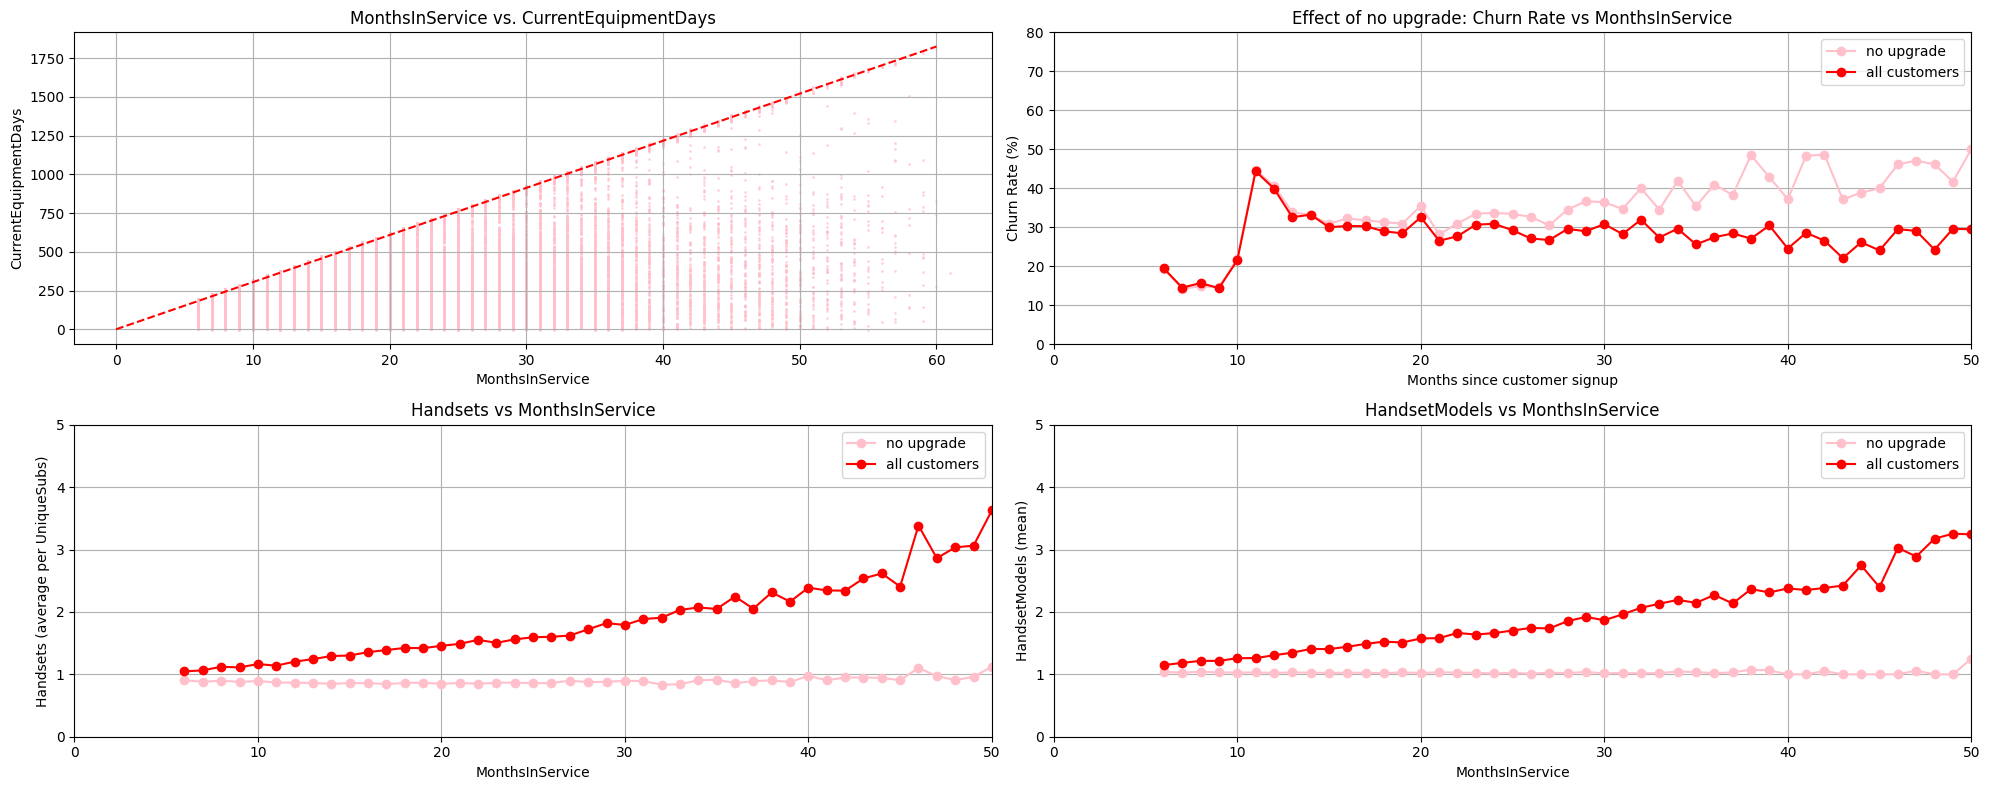

In [ ]:
# Plot Scatter graph of MonthsInService vs. CurrentEquipmentDays
plt.figure(figsize=(20, 8))
plt.subplot(2,2,1)
plt.scatter(
    cleaned_df['MonthsInService'],
    cleaned_df['CurrentEquipmentDays'],
    c='pink',
    alpha=0.6,
    s=1,
)

x_vals = np.linspace(0, 60, 500)
y_vals = x_vals * (365 / 12)
plt.plot(x_vals, y_vals, 'r--',)

plt.title('MonthsInService vs. CurrentEquipmentDays')
plt.xlabel('MonthsInService')
plt.ylabel('CurrentEquipmentDays')
plt.grid(True)

# Mask to identify customers who have not received an upgrade
mask = np.isclose(cleaned_df['CurrentEquipmentDays'] * 12 / 365, cleaned_df['MonthsInService'], atol=1)

churnrate_MonthsInService_noupgrade_df = cleaned_df[mask].groupby('MonthsInService')['Churn'].agg(
    ChurnRate=lambda x: x.mean() * 100,
    CustomerCount='count'
    ).reset_index()

# Plot Churn Rate by MonthsInService
plt.subplot(2,2,2)
plt.plot(
    churnrate_MonthsInService_noupgrade_df['MonthsInService'],
    churnrate_MonthsInService_noupgrade_df['ChurnRate'],
    marker='o',
    linestyle='-',
    color='Pink',
    label='no upgrade'
    )
plt.plot(
    churnrate_MonthsInService_df['MonthsInService'],
    churnrate_MonthsInService_df['ChurnRate'],
    marker='o',
    linestyle='-',
    color='Red',
    label='all customers'
    )
plt.xlabel('Months since customer signup')
plt.xlim(0, 50)
plt.ylim(0, 80)
plt.ylabel('Churn Rate (%)')
plt.title('Effect of no upgrade: Churn Rate vs MonthsInService')
plt.grid(True)
plt.legend()



# Plot of Handsets per subscription vs. MonthsInService
mask = np.isclose(cleaned_df['CurrentEquipmentDays'] * 12 / 365, cleaned_df['MonthsInService'], atol=1)
cleaned_df['HandsetsPerUniqueSubs'] = cleaned_df['Handsets'] / cleaned_df['UniqueSubs']

handsets_allcustomers_df = cleaned_df.groupby('MonthsInService')['HandsetsPerUniqueSubs'].agg(
    AverageHandsets='mean'
    ).reset_index()

handsets_noupgrade_df = cleaned_df[mask].groupby('MonthsInService')['HandsetsPerUniqueSubs'].agg(
    AverageHandsets='mean'
    ).reset_index()

handsets_upgraded_df = cleaned_df[~mask].groupby('MonthsInService')['HandsetsPerUniqueSubs'].agg(
    AverageHandsets='mean'
    ).reset_index()

plt.subplot(2,2,3)
plt.plot(
    handsets_noupgrade_df['MonthsInService'],
    handsets_noupgrade_df['AverageHandsets'],
    marker='o',
    linestyle='-',
    color='Pink',
    label='no upgrade'
    )
plt.plot(
    handsets_allcustomers_df['MonthsInService'],
    handsets_allcustomers_df['AverageHandsets'],
    marker='o',
    linestyle='-',
    color='Red',
    label='all customers'
    )

plt.xlabel('MonthsInService')
plt.xlim(0, 50)
plt.ylim(0, 5)
plt.ylabel('Handsets (average per UniqueSubs)')
plt.title('Handsets vs MonthsInService')
plt.grid(True)
plt.legend()

# Plot of HandsetModels vs. MonthsInService
mask = np.isclose(cleaned_df['CurrentEquipmentDays'] * 12 / 365, cleaned_df['MonthsInService'], atol=1)

handsetmodels_allcustomers_df = cleaned_df.groupby('MonthsInService')['HandsetModels'].agg(
    AverageHandsets='mean'
    ).reset_index()

handsetmodels_noupgrade_df = cleaned_df[mask].groupby('MonthsInService')['HandsetModels'].agg(
    AverageHandsets='mean'
    ).reset_index()

handsetmodels_upgraded_df = cleaned_df[~mask].groupby('MonthsInService')['HandsetModels'].agg(
    AverageHandsets='mean'
    ).reset_index()

plt.subplot(2,2,4)
plt.plot(
    handsetmodels_noupgrade_df['MonthsInService'],
    handsetmodels_noupgrade_df['AverageHandsets'],
    marker='o',
    linestyle='-',
    color='Pink',
    label='no upgrade'
    )
plt.plot(
    handsetmodels_allcustomers_df['MonthsInService'],
    handsetmodels_allcustomers_df['AverageHandsets'],
    marker='o',
    linestyle='-',
    color='Red',
    label='all customers'
    )

plt.xlabel('MonthsInService')
plt.xlim(0, 50)
plt.ylim(0, 5)
plt.ylabel('HandsetModels (mean)')
plt.title('HandsetModels vs MonthsInService')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

Additionally, we observe that the number of handsets registered to each customer (`Handsets`) is always greater than zero, suggesting that no customers are on SIM-only contracts - all appear to have acquired devices through the provider. Both `Handsets` and `HandsetModels` tend to increase with tenure, consistent with periodic upgrades. However, a small subset of customers show fewer registered handsets than active mobile subscritpions (`UniqueSubs`), which may point to data inconsistencies or shared device usage.

Only a small proportion of customers (**3.25%**) have contact with the Retention Team. The identical statistics for `MadeCallToRetentionTeam` and cases where `RetentionCalls` > 0 suggest that all contact is customer-initiated, indicating a lack of proactive outreach by the Retention Team. This likely explains the elevated churn propensity among these customers, as their engagement with the team reflects pre-existing intentions to leave the service.

### 5.5 Continuous numerical variables

We generate boxplots and mirrored Kernel Density Estimate (KDE) plots to visualise the distribution of continuous numerical variables and compare them across churn classes.

In [ ]:
# List continuous numerical variables
cont_num_cols = ['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls',
                 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
                 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
                 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
                 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls',
                 'CallWaitingCalls', 'HandsetPrice']

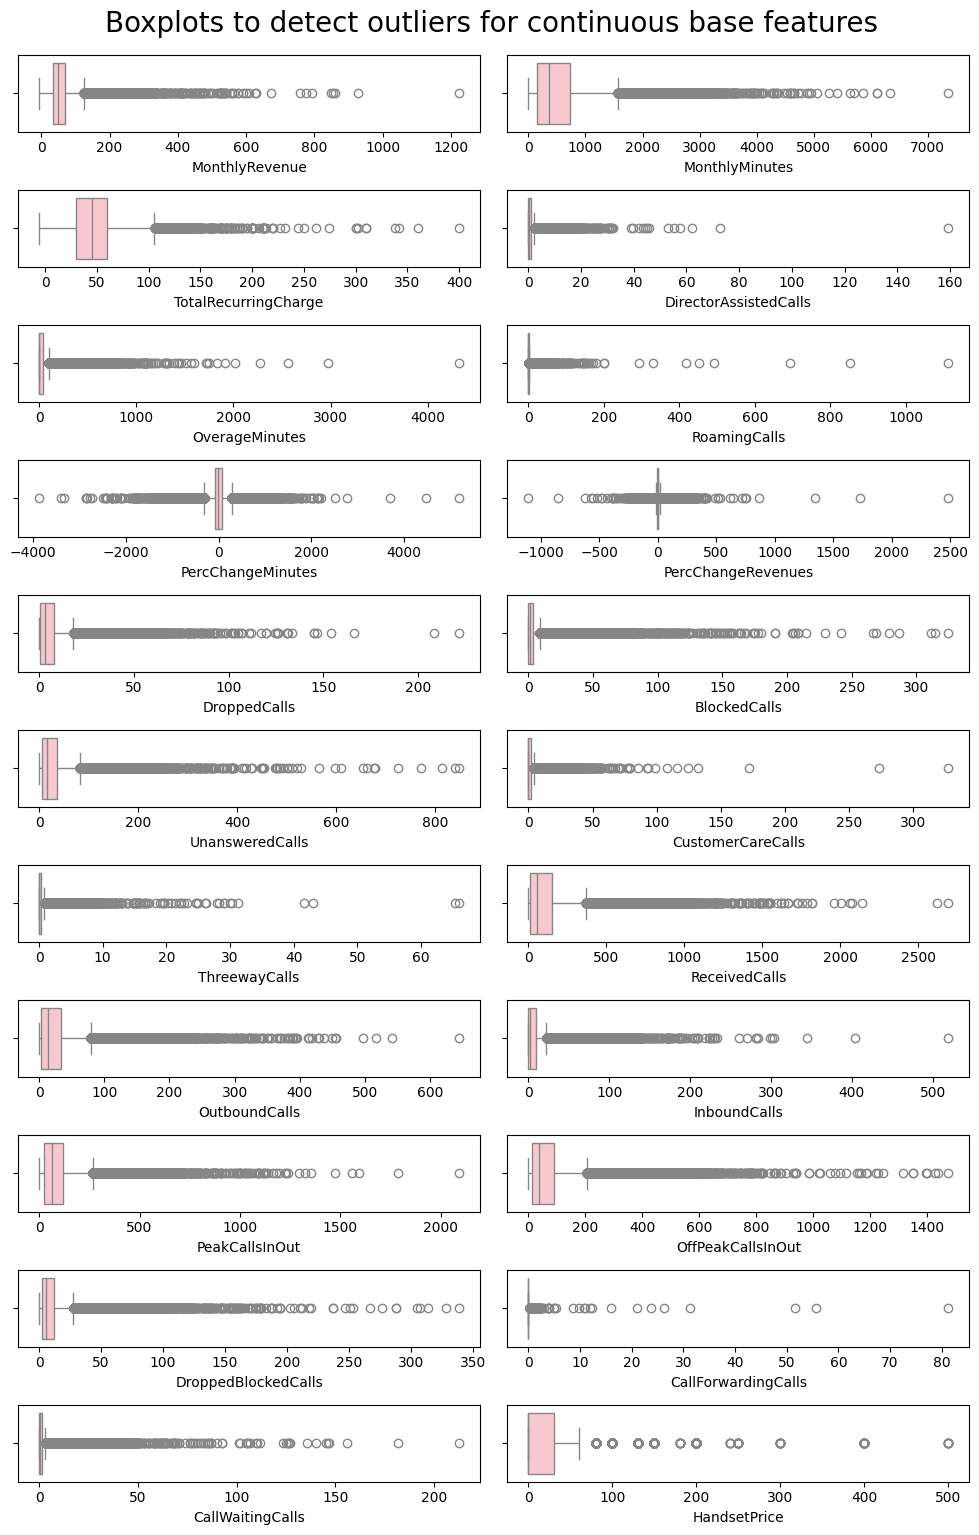

In [ ]:
# Create boxplots
plt.figure(figsize=(10, 15))
i=1
for var in cont_num_cols:
  plt.subplot(11, 2, i)
  sns.boxplot(x = var,
            data = cleaned_df,
            color="pink")
  plt.title('')
  plt.xlabel(var)
  i = i+1
plt.tight_layout()
plt.suptitle('Boxplots to detect outliers for continuous base features', fontsize=20, y=1.02)
plt.show()

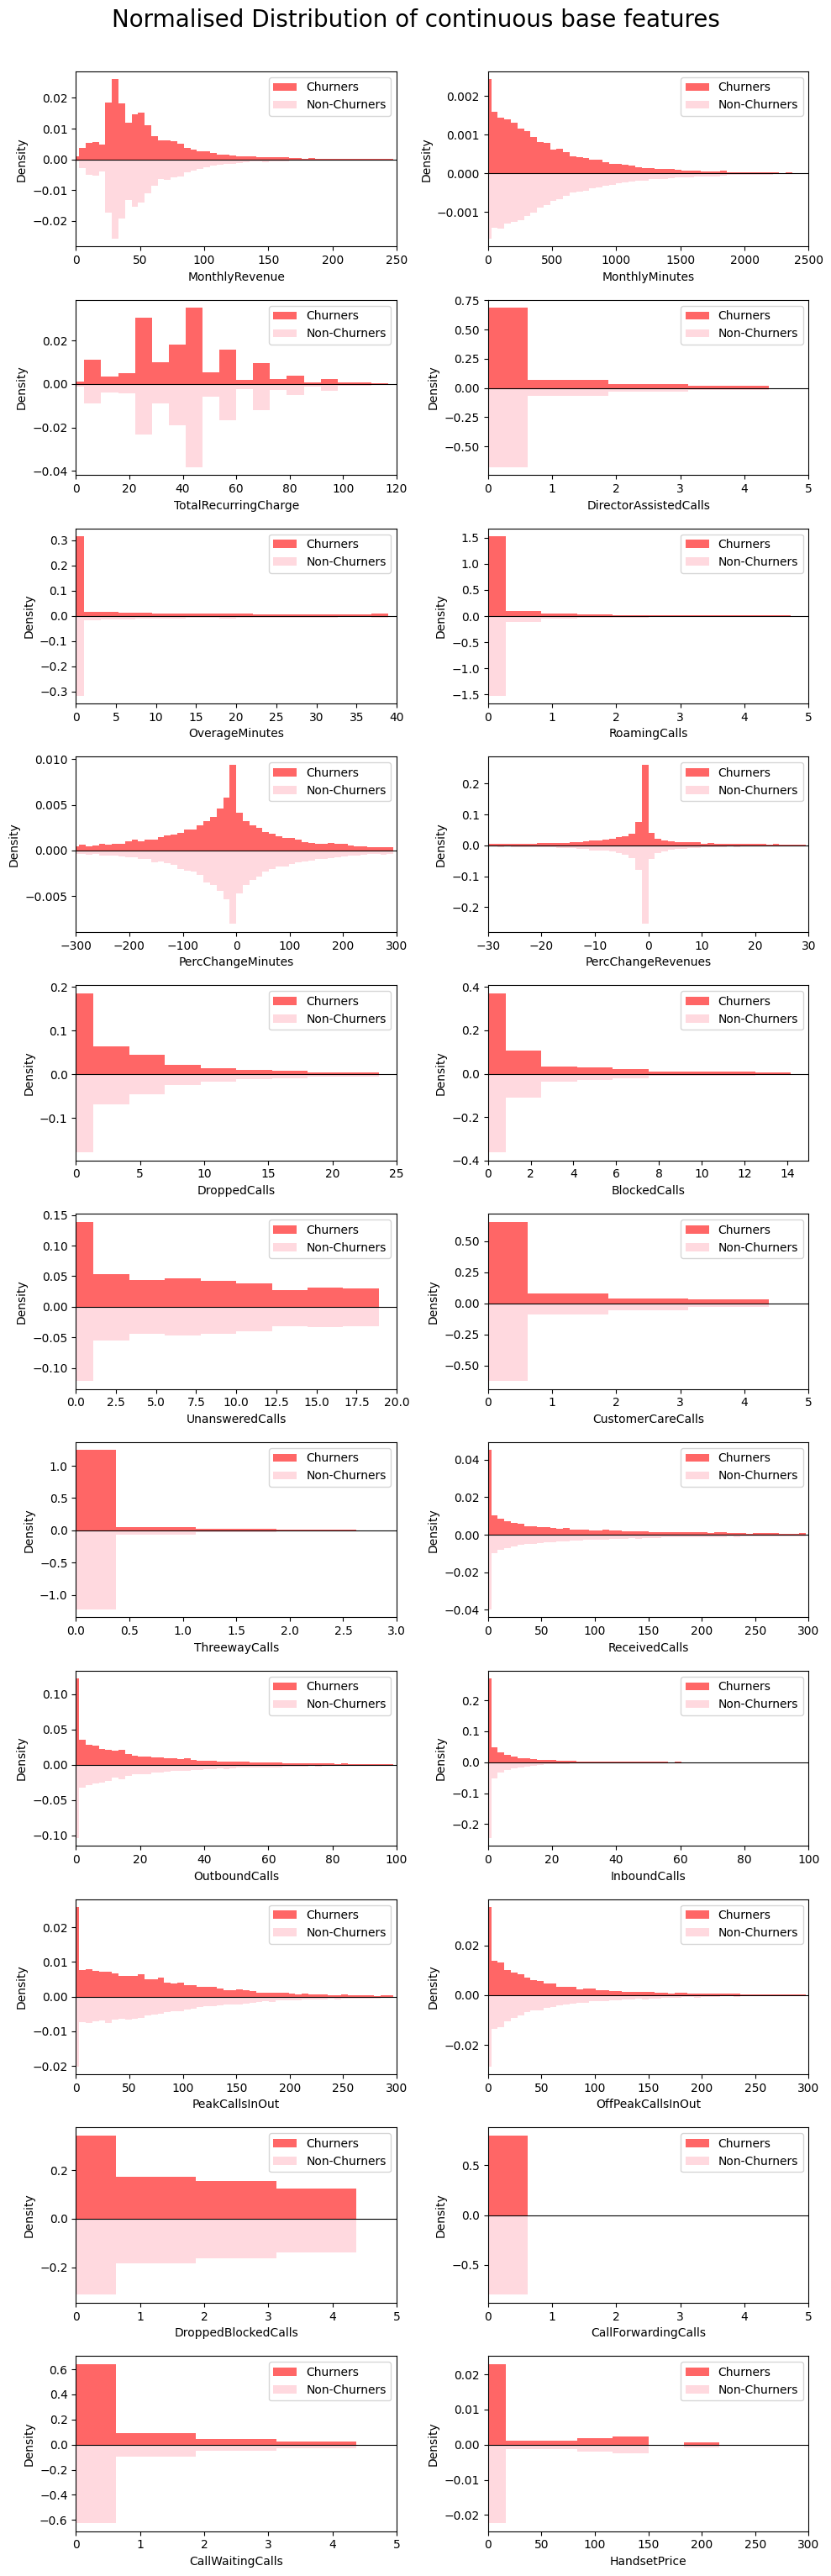

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(11, 2, 1)
PlotNormDist('MonthlyRevenue', xmax=250)
plt.subplot(11, 2, 2)
PlotNormDist('MonthlyMinutes', xmax=2500)
plt.subplot(11, 2, 3)
PlotNormDist('TotalRecurringCharge', xmax=120, bins=20)
plt.subplot(11, 2, 4)
PlotNormDist('DirectorAssistedCalls', xmax=5, bins=5)
plt.subplot(11, 2, 5)
PlotNormDist('OverageMinutes', xmax=40, bins=20)
plt.subplot(11, 2, 6)
PlotNormDist('RoamingCalls', xmax=5, bins=10)
plt.subplot(11, 2, 7)
PlotNormDist('PercChangeMinutes', xmax=300, xmin=-300)
plt.subplot(11, 2, 8)
PlotNormDist('PercChangeRevenues', xmax=30, xmin=-30)
plt.subplot(11, 2, 9)
PlotNormDist('DroppedCalls', xmax=25, bins=10)
plt.subplot(11, 2, 10)
PlotNormDist('BlockedCalls', xmax=15, bins=10)
plt.subplot(11, 2, 11)
PlotNormDist('UnansweredCalls', xmax=20, bins=10)
plt.subplot(11, 2, 12)
PlotNormDist('CustomerCareCalls', xmax=5, bins=5)
plt.subplot(11, 2, 13)
PlotNormDist('ThreewayCalls', xmax=3, bins=5)
plt.subplot(11, 2, 14)
PlotNormDist('ReceivedCalls', xmax=300)
plt.subplot(11, 2, 15)
PlotNormDist('OutboundCalls', xmax=100)
plt.subplot(11, 2, 16)
PlotNormDist('InboundCalls', xmax=100)
plt.subplot(11, 2, 17)
PlotNormDist('PeakCallsInOut', xmax=300)
plt.subplot(11, 2, 18)
PlotNormDist('OffPeakCallsInOut', xmax=300)
plt.subplot(11, 2, 19)
PlotNormDist('DroppedBlockedCalls', xmax=5, bins=5)
plt.subplot(11, 2, 20)
PlotNormDist('CallForwardingCalls', xmax=5, bins=5)
plt.subplot(11, 2, 21)
PlotNormDist('CallWaitingCalls', xmax=5, bins=5)
plt.subplot(11, 2, 22)
PlotNormDist('HandsetPrice', xmax=300, bins=10)
plt.tight_layout()
plt.suptitle('Normalised Distribution of continuous base features', fontsize=20, y=1.02)
plt.show()

In [ ]:
# Calculate AUC and averages
Table_Variables_Continuous=[]
for var in cont_num_cols:
  auc = roc_auc_score(y_true=cleaned_df['Churn'], y_score=cleaned_df[var])
  churner_mean = cleaned_df[(cleaned_df['Churn']==1)][var].mean()
  nonchurner_mean = cleaned_df[(cleaned_df['Churn']==0)][var].mean()
  Table_Variables_Continuous.append({'Variable': var, 'AUC': round(auc,3), 'Mean (churner)': round(churner_mean,2), 'Mean (non-churner)': round(nonchurner_mean,2)})
Table_Variables_Continuous_df = pd.DataFrame(Table_Variables_Continuous)
Table_Variables_Continuous_df

Variable    AUC  Mean (churner)  Mean (non-churner)
0          MonthlyRevenue  0.485           57.92               59.06
1          MonthlyMinutes  0.460          482.37              542.36
2    TotalRecurringCharge  0.458           44.72               47.78
3   DirectorAssistedCalls  0.486            0.82                0.92
4          OverageMinutes  0.512           41.94               38.71
5            RoamingCalls  0.500            1.40                1.15
6       PercChangeMinutes  0.469          -24.79               -6.34
7      PercChangeRevenues  0.497           -0.37               -1.43
8            DroppedCalls  0.485            5.79                6.11
9            BlockedCalls  0.490            3.98                4.13
10        UnansweredCalls  0.472           26.47               29.06
11      CustomerCareCalls  0.469            1.60                2.02
12          ThreewayCalls  0.485            0.25                0.32
13          ReceivedCalls  0.470          104.42              118.73
14          OutboundCalls  0.471           23.30               25.92
15           InboundCalls  0.465            7.08                8.43
16         PeakCallsInOut  0.470           83.42               92.78
17      OffPeakCallsInOut  0.465           61.34               70.41
18    DroppedBlockedCalls  0.484            9.83               10.31
19    CallForwardingCalls  0.499            0.01                0.01
20       CallWaitingCalls  0.478            1.59                1.92
21           HandsetPrice  0.481           33.04               36.30

We observe the following customer profiles based on continuous numerical features and their association with churn:

* **Chatty Non-Churners:** Non-churners use approximately **60** more minutes per month (`MonthlyMinutes`) than churners and consistently exhibit higher call volumes across multiple categories — `ReceivedCalls`, `OutboundCalls`, `InboundCalls`, `PeakCallsInOut`, and `OffPeakCallsInOut` - indicating stronger service dependence and greater overall engagement.

* **Exiting Decliners:** Churners exhibit an average reduction of **24.79%** in monthly minutes (`PercChangeMinute`) in the month preceding churn. Notably, non-churners also show a decrease, averaging **6.34%**, which may reflect a broader shift towards increased web usage and warrants further investigation.

* **Budget-Conscious Churners:** Churners typically spend an average of **\$1.20** less on their monthly bill (`MonthlyRevenue`) and subscribe to cheaper tariffs (`TotalRecurringCharge`), paying on average **\$3** less than non-churners. But, in contrast, churners accumulate approximately **3** more out-of-allowance minutes (`OverageMinutes`) than non-churners, potentially indicating a mismatch between their usage and service plan that could lead to customer dissatisfaction.

* **Engaged Loyalists:** Non-churning customers place, on average, **one** additional call to Customer Care (`CustomerCareCalls`) every **2.5** months compared to churners, potentially reflecting proactive support-seeking behavior or effective service recovery.

* **Valued Device Users:** Non-churners tend to own slightly more expensive handsets (`HandsetPrice`), with an average of **\$36.30** compared to **\$33.04** among churners.

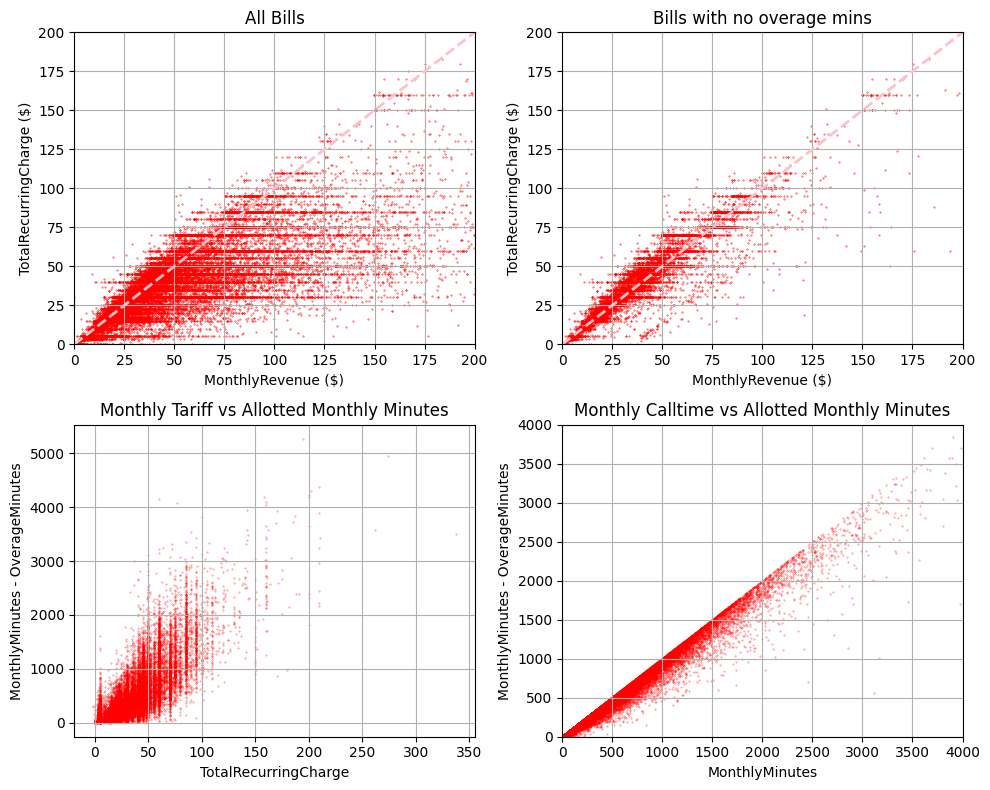

In [ ]:
# Plot Scatter graph of MonthlyRevenue vs. TotalRecurringCharge
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.scatter(
    (cleaned_df['MonthlyRevenue']       / cleaned_df['UniqueSubs']),
    (cleaned_df['TotalRecurringCharge'] / cleaned_df['UniqueSubs']),
    c='red',
    s=0.1,
)
line_vals = np.linspace(0, 400, 100)
plt.plot(line_vals, line_vals, color='pink', linestyle='--', linewidth=2, label='MonthlyRevenue = TotalRecurringCharge')
plt.title('All Bills')
plt.xlabel('MonthlyRevenue ($)')
plt.ylabel('TotalRecurringCharge ($)')
plt.xlim(0,200)
plt.ylim(0,200)
plt.grid(True)

plt.subplot(2,2,2)
mask = (cleaned_df['OverageMinutes'] == 0)
plt.scatter(
    (cleaned_df[mask]['MonthlyRevenue']       / cleaned_df[mask]['UniqueSubs']),
    (cleaned_df[mask]['TotalRecurringCharge'] / cleaned_df[mask]['UniqueSubs']),
    c='red',
    s=0.1,
)
line_vals = np.linspace(0, 400, 100)
plt.plot(line_vals, line_vals, color='pink', linestyle='--', linewidth=2, label='MonthlyRevenue = TotalRecurringCharge')
plt.title('Bills with no overage mins')
plt.xlabel('MonthlyRevenue ($)')
plt.ylabel('TotalRecurringCharge ($)')
plt.xlim(0,200)
plt.ylim(0,200)
plt.grid(True)

# Plot Scatter graphs
mask = (cleaned_df['OverageMinutes'] > 0)
plt.subplot(2,2,3)
plt.scatter(
    (cleaned_df[mask]['TotalRecurringCharge'] / cleaned_df[mask]['UniqueSubs']),
    ((cleaned_df[mask]['MonthlyMinutes'] - cleaned_df[mask]['OverageMinutes']) / cleaned_df[mask]['UniqueSubs']),
    c='red',
    alpha=0.6,
    s=0.1,
)
plt.title('Monthly Tariff vs Allotted Monthly Minutes')
plt.xlabel('TotalRecurringCharge')
plt.ylabel('MonthlyMinutes - OverageMinutes')
plt.grid(True)


plt.subplot(2,2,4)
plt.scatter(
    (cleaned_df['MonthlyMinutes'] / cleaned_df['UniqueSubs']),
    ((cleaned_df['MonthlyMinutes'] - cleaned_df['OverageMinutes']) / cleaned_df['UniqueSubs']),
    c='red',
    alpha=0.6,
    s=0.1,
)
plt.xlim(0,4000)
plt.ylim(0,4000)
plt.title('Monthly Calltime vs Allotted Monthly Minutes')
plt.xlabel('MonthlyMinutes')
plt.ylabel('MonthlyMinutes - OverageMinutes')
plt.grid(True)
plt.tight_layout()
plt.show()

We observe that monthly bills (`MonthlyRevenue`) are generally, though not always, higher than the base service plan tariff (`TotalRecurringCharge`), primarily driven by customers exceeding their allotted monthly minutes.

However, this relationship is not straightforward. There appears to be no simple correlation between the number of allotted monthly minutes (calculated as `MonthlyMinutes` minus `OverageMinutes`) and the monthly tariff (`TotalRecurringCharge`). The service plan pricing structure is evidently complex, likely influenced by multiple factors such as insurance fees, device upgrade models, data allowances, discounts, and possibly carried-over debt, which may account for observed discrepancies.

## 6 Feature Engineering

Previous research has shown that customer churn in the telecoms sector is driven by a complex interplay of factors including service plans, usage patterns, customer interactions and customer demographics.$^{5}$

We first transform relevant base features, and then systematically explore each of these categories to engineer new features that may better capture predictive signals.

### 6.1 Base Feature Transformation

We transform the ordinal categorical base feature `CreditRating` (ranging from '1-Highest' to '7-Lowest') into numeric values.

In [ ]:
# Extract first digit of CreditRating and convert datatype to integer
cleaned_df['CreditRating_numeric'] = cleaned_df['CreditRating'].str.extract(r'^(\d)').astype(int)

We decompose the nominal categorical base feature `ServiceArea` into three components - `Region`, `LocalArea`, and `AreaCode` (corresponding to the U.S. telephone area code). We visualise churn rates by `AreaCode`, utilising geospatial data sourced from the [Colorado Geospatial Portal](https://geodata.colorado.gov/datasets/esri%3A%3Ausa-telephone-area-code-boundaries-1/about).

In [ ]:
# Transform feature ServiceArea
cleaned_df[['Region', 'LocalArea', 'AreaCode']] = cleaned_df['ServiceArea'].str.extract(r'([A-Z]{3})([A-Z]{3})(\d+)')

In [ ]:
# Calculate Churn Rate for AreaCode
churnrate_AreaCode_df = ChurnRateByVar('AreaCode')

In [ ]:
# Download USA Telephone Area Code Boundaries data from Colorado Geospatial Portal
geojson_url = 'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Telephone_Area_Codes/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson'
USAreaCode_gdf = gpd.read_file(geojson_url)

In [ ]:
# Merge with geospatial data
churn_AreaCode_gdf = USAreaCode_gdf.merge(
    churnrate_AreaCode_df,
    how='inner',
    left_on='AREA_CODE',
    right_on='AreaCode'
).drop(columns=['AREA_CODE'])

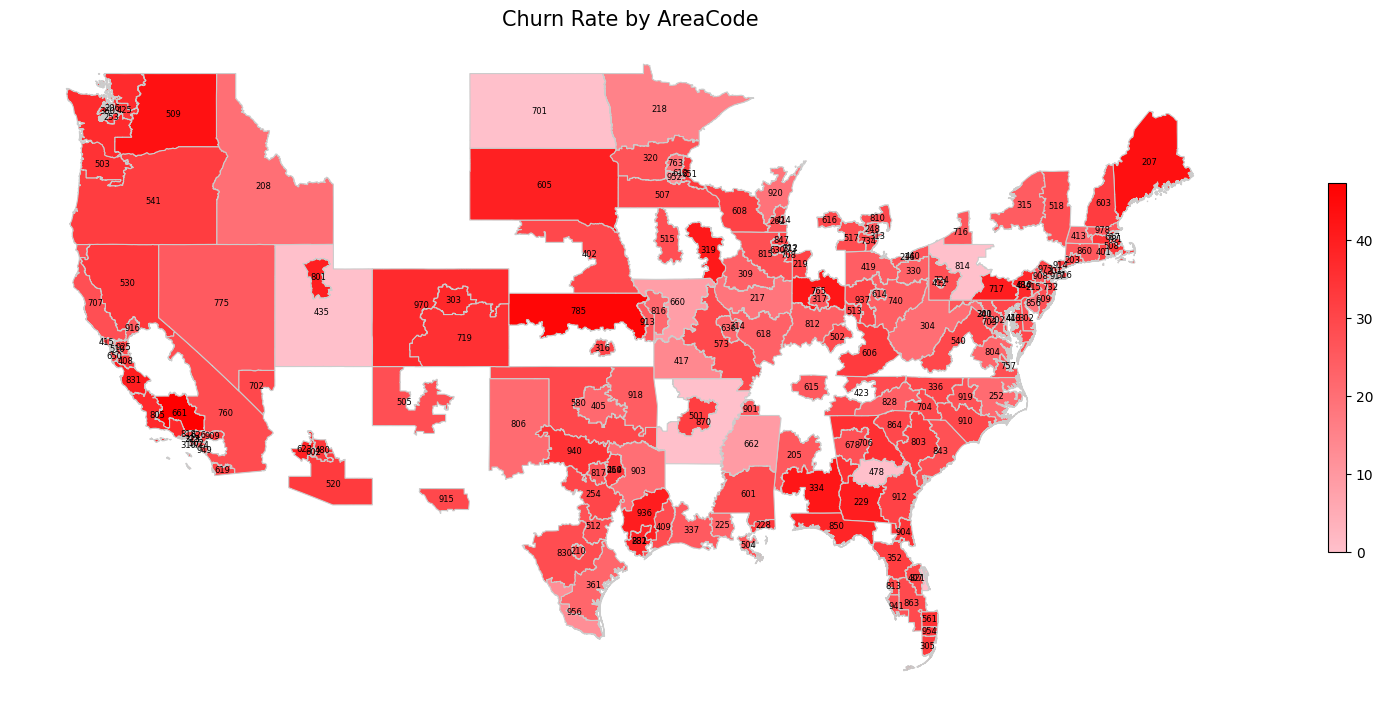

In [ ]:
# Plot choropleth map
plot_gdf = churn_AreaCode_gdf[~churn_AreaCode_gdf['STATE'].isin(['HI', 'AK'])]
red_pink_cmap = LinearSegmentedColormap.from_list('RedPink', ['pink', 'red'])
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
plot_gdf.plot(
    column='ChurnRate',
    cmap=red_pink_cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'shrink': 0.3}
)
for idx, row in plot_gdf.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    x, y = row['geometry'].centroid.coords[0]
    ax.text(x, y, f"{row['AreaCode']}", fontsize=6, ha='center', va='center')
ax.set_title('Churn Rate by AreaCode', fontdict={'fontsize': '15', 'fontweight' : '3'})
ax.axis('off')
plt.show()

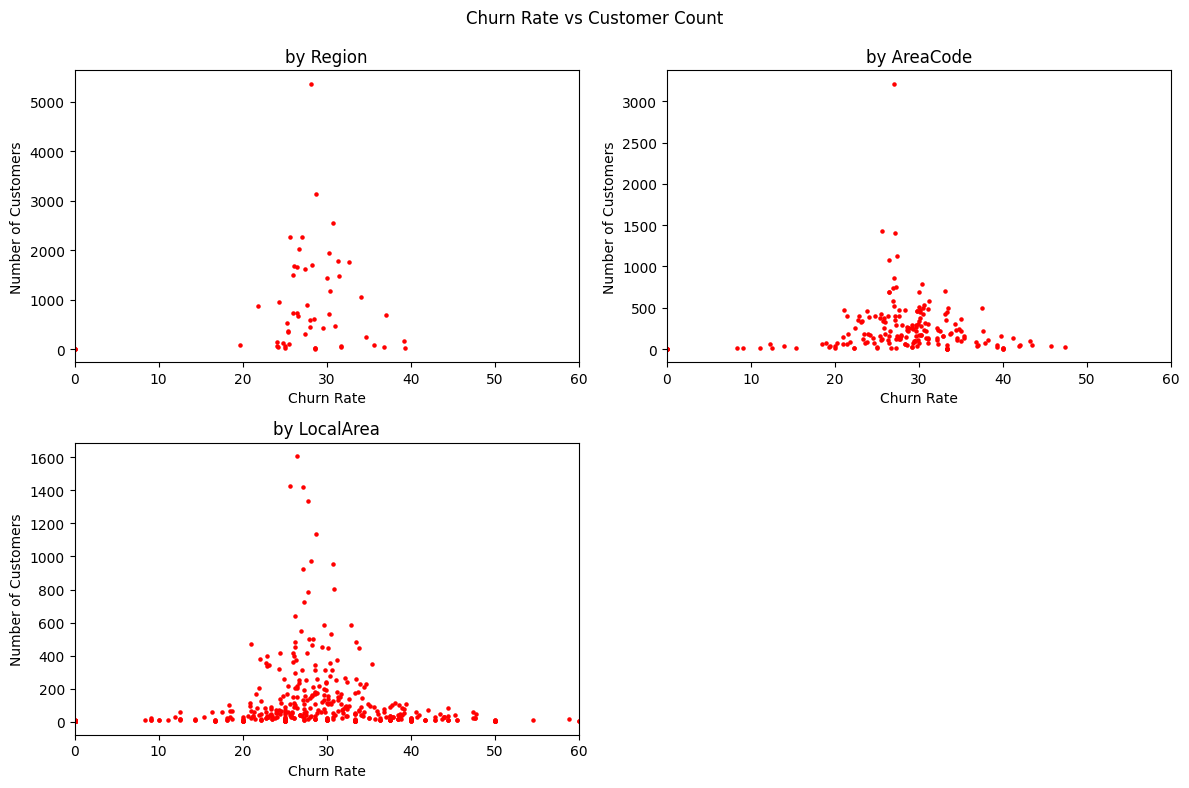

In [ ]:
# Calculate churn rate for other features
churnrate_Region_df = ChurnRateByVar('Region')
churnrate_LocalArea_df = ChurnRateByVar('LocalArea')

# Create scatter plots
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.scatter(
    churnrate_Region_df['ChurnRate'],
    churnrate_Region_df['CustomerCount'],
    color='red',
    s=5
    )
plt.xlim(0,60)
plt.title('by Region')
plt.xlabel('Churn Rate')
plt.ylabel('Number of Customers')

plt.subplot(2,2,2)
plt.scatter(
    churnrate_AreaCode_df['ChurnRate'],
    churnrate_AreaCode_df['CustomerCount'],
    color='red',
    s=5
    )
plt.xlim(0,60)
plt.title('by AreaCode')
plt.xlabel('Churn Rate')
plt.ylabel('Number of Customers')

plt.subplot(2,2,3)
plt.scatter(
    churnrate_LocalArea_df['ChurnRate'],
    churnrate_LocalArea_df['CustomerCount'],
    color='red',
    s=5
    )
plt.xlim(0,60)
plt.title('by LocalArea')
plt.xlabel('Churn Rate')
plt.ylabel('Number of Customers')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Churn Rate vs Customer Count")
plt.show()

In [ ]:
# Define function for Cramer's V
def CramersV(var):
  contingency = pd.crosstab(cleaned_df[var], cleaned_df['Churn'])

  if contingency.empty or contingency.shape[0] < 2 or contingency.shape[1] < 2:
    return None, None

  chi2, p, dof, expected = stats.chi2_contingency(contingency)
  n = contingency.sum().sum()
  cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
  return cramers_v, p

In [ ]:
# Calculate Cramer's V for transformed features
new_nom_cat_cols = ['Region', 'LocalArea', 'AreaCode']

Table_Variables_nominal = []
for var in new_nom_cat_cols:
  cramers_v, p_value = CramersV(var)
  Table_Variables_nominal.append({'Variable': var, 'CramersV': round(cramers_v,3), 'p-value_CramersV': round(p_value,3)})
Table_Variables_nominal_df = pd.DataFrame(Table_Variables_nominal)
Table_Variables_nominal_df


Variable  CramersV  p-value_CramersV
0     Region     0.061               0.0
1  LocalArea     0.119               0.0
2   AreaCode     0.086               0.0

We observe that *Cramér’s V* is highest for `LocalArea`, likely due to its finer geographical granularity.

### 6.2 Feature Construction

### 6.2.1 Service Plan

We create the following new features:
* `CurrentEquipmentMonths`:  The age of the customer's current mobile handset expressed in months.
* `NoWeb_CurrentEquipmentMonths`: An interaction term representing equipment age for customers who have a phone that is not web-enabled.
* `HandsetPrice_Binned`: binned version of handset price.

We also create the following binary flags:
* `ContractExpiryFlag`: Customer tenure of 11-12 months, indicating proximity to contract expiration.
* `NoUpgradeFlag`: Customer has not received a handset upgrade during their tenure.
* `CurrentEquipmentOneYearFlag`: Customer's handset is between 10 and 12 months old.
* `CurrentEquipmentOneYearFlagv2`: Customer's handset is exactly 11 months old.
* `MissingHandsetFlag`: Number of unique subscriptions exceeds the number of handsets registered, suggesting discrepancies.
* `ReplacementHandsetFlag`: Customer has received a replacement handset.
* `NonWebHandsetRegretFlag`: Customer holds a non-web-enabled handset aged 3 to 4 months.

In [ ]:
# Create new features
cleaned_df['CurrentEquipmentMonths'] = (cleaned_df['CurrentEquipmentDays'] * 12 / 365).round(0).astype(int)
cleaned_df['NoWeb_CurrentEquipmentMonths'] = cleaned_df['CurrentEquipmentMonths'] * (1 - cleaned_df['HandsetWebCapable'])

In [ ]:
# Create binary flags
cleaned_df['ContractExpiryFlag'] = ((cleaned_df['MonthsInService'] > 10) & (cleaned_df['MonthsInService'] < 13)).astype(int)
cleaned_df['NoUpgradeFlag'] = (cleaned_df['HandsetModels'] == 1).astype(int)
cleaned_df['CurrentEquipmentOneYearFlag'] = (cleaned_df['CurrentEquipmentMonths'] == 11).astype(int)
cleaned_df['CurrentEquipmentOneYearFlagv2'] = ((cleaned_df['CurrentEquipmentMonths'] >= 10) & (cleaned_df['CurrentEquipmentMonths'] <= 12)).astype(int)
cleaned_df['MissingHandsetFlag'] = (cleaned_df['UniqueSubs'] > cleaned_df['Handsets']).astype(int)
cleaned_df['ReplacementHandsetFlag'] = (cleaned_df['Handsets'] / cleaned_df['UniqueSubs'] > cleaned_df['HandsetModels']).astype(int)
cleaned_df['NonWebHandsetRegretFlag'] = ((cleaned_df['NoWeb_CurrentEquipmentMonths'] >= 3) & (cleaned_df['NoWeb_CurrentEquipmentMonths'] <= 4)).astype(int)


In [ ]:
# Create binned version of HandsetPrice
def bin_HandsetPrice(price):
    if pd.isna(price):
        return "Missing"
    elif price == 0:
        return "Unknown"
    elif price <=50:
        return "0-50"
    elif price <=100:
        return "51-100"
    elif price <=150:
        return "101-150"
    else:
        return "151+"

cleaned_df['HandsetPrice_Binned'] = cleaned_df['HandsetPrice'].apply(bin_HandsetPrice)

In [ ]:
# Plot Churn Rate for NoWeb_CurrentEquipmentMonths
plt.figure(figsize=(10, 4))
churnrate_NoWeb_CurrentEquipmentMonths_df = ChurnRateByVar('NoWeb_CurrentEquipmentMonths')
churnrate_CurrentEquipmentMonths_df = ChurnRateByVar('CurrentEquipmentMonths')
plt.subplot(1,2,1)
plt.plot(
    churnrate_CurrentEquipmentMonths_df['CurrentEquipmentMonths'],
    churnrate_CurrentEquipmentMonths_df['ChurnRate'],
    marker='o',
    linestyle='-',
    color='Pink',
    label='All handsets'
    )
plt.plot(
    churnrate_NoWeb_CurrentEquipmentMonths_df['NoWeb_CurrentEquipmentMonths'],
    churnrate_NoWeb_CurrentEquipmentMonths_df['ChurnRate'],
    marker='o',
    linestyle='-',
    color='Red',
    label='NonWebCapable handsets'
    )
plt.xlim(0,50)
plt.ylim(0,70)
plt.xlabel('CurrentEquipmentMonths')
plt.ylabel('Churn Rate (%)')
plt.legend()
plt.title('Handsets: NonWebCapable vs All')
plt.grid(True)

# Plot bar chart of HandsetPrice_Binned
churnrate_HandsetPrice_Binned_df = ChurnRateByVar('HandsetPrice_Binned')
plt.subplot(1,2,2)
ordered_bins = ['Unknown', '0-50', '51-100', '101-150', '151+']
churnrate_HandsetPrice_Binned_df['HandsetPrice_Binned'] = pd.Categorical(
    churnrate_HandsetPrice_Binned_df['HandsetPrice_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_HandsetPrice_Binned_df = churnrate_HandsetPrice_Binned_df.sort_values('HandsetPrice_Binned')
colors = ['pink' if x == 'Unknown' else 'red' for x in churnrate_HandsetPrice_Binned_df['HandsetPrice_Binned']]
sns.barplot(
    x='HandsetPrice_Binned',
    y='ChurnRate',
    data=churnrate_HandsetPrice_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by Handset Price')
plt.ylabel('Churn Rate (%)')
plt.xlabel('Handset Price (Binned)')
plt.grid(True)
plt.tight_layout()
plt.show()

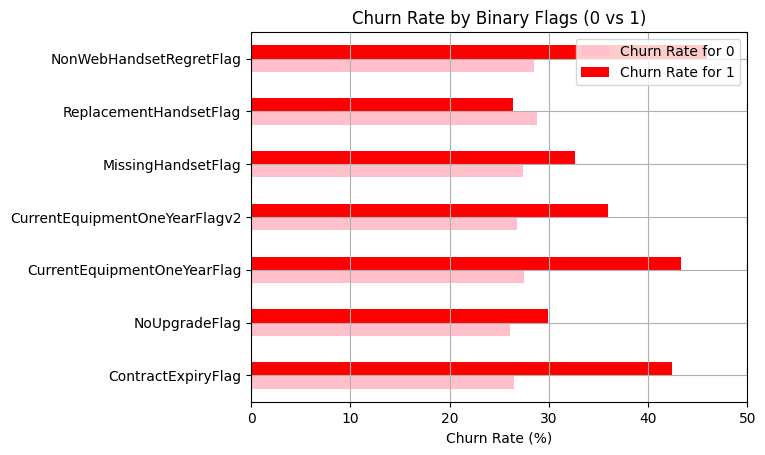

Churn Rate for 0  Churn Rate for 1
ContractExpiryFlag                    26.492164         42.465295
NoUpgradeFlag                         26.131411         29.883261
CurrentEquipmentOneYearFlag           27.538482         43.278916
CurrentEquipmentOneYearFlagv2         26.803044         35.951867
MissingHandsetFlag                    27.403859         32.594746
ReplacementHandsetFlag                28.761135         26.399717
NonWebHandsetRegretFlag               28.461089         45.901639

In [ ]:
# Plot churn rate for binary flags
binary_cols = ['ContractExpiryFlag', 'NoUpgradeFlag', 'CurrentEquipmentOneYearFlag', 'CurrentEquipmentOneYearFlagv2',
               'MissingHandsetFlag', 'ReplacementHandsetFlag', 'NonWebHandsetRegretFlag']
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

churn_df = pd.DataFrame(churn_rates).T  # Transpose to get flags as rows
churn_df.columns = ['Churn Rate for 0', 'Churn Rate for 1']

churn_df.plot(kind='barh', color=['pink', 'red'])
plt.title('Churn Rate by Binary Flags (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.xlim(0, 50)
plt.grid(True)
plt.show()

churn_df

In [ ]:
churnrate_HandsetPrice_Binned_df

HandsetPrice_Binned  ChurnRate  CustomerCount
4             Unknown  29.894683          27346
0                0-50  26.457349           8886
3              51-100  27.337508           4631
1             101-150  26.063830           5828
2                151+  27.551020           1274

Consistent with earlier analysis, we observe the following patterns:

* **Contract-Cycle Churners:** Customers approaching the end of their 12-month contract (identified by the `ContractExpiryFlag`) exhibit a markedly elevated churn rate of **42.5%**, compared to **26.5%** for those at other stages of tenure. This spike likely reflects planned switching behaviour aligned with contract renewal windows.

* **Upgrade-Deprived Deserters:** Customers who have not received a device upgrade (`NoUpgradeFlag`) show a higher churn propensity of **29.9%**, versus **26.1%** for those who have upgraded. The effect is more pronounced for those whose current equipment is exactly 11 months old (`CurrentEquipmentOneYearFlag`), where churn peaks at **43.3%**.

* **Legacy Device Churners:** Customers using non-web-capable devices are especially prone to churn. As previously noted, churn reaches **45.9%** for those whose non-web-capable handsets are 3-4 months old (`NonWebHandsetRegretFlag`), suggesting early regret or unmet expectations related to limited handset functionality.

### 6.2.2 Usage pattern

We create the following new feature, including binned versions where appropriate:
* `MobileTotalCalls`: The average number of calls a customer attempts or receives per month per subscription, including both successful and unsuccessful connections.

* `AvCallDuration`: The average duration (in minutes) of calls a customer makes or receives.

* `PropActiveSubs`: The proportion of a customer's subscriptions that are active.

* `ServiceQualityIndicator`: The proportion of dropped calls (`DroppedCalls`) relative to total call activity.

We also create a set of binary flags to capture potentially meaningful usage patterns associated with churn:

* `NoActiveSubsFlag`: indicates customers with no active subscriptions.
* `ZeroCallsFlag`: flags customers who neither make nor receive calls.
* `ZeroMonthlyMinutesFlag`: flags customers who make zero minutes of calls per month.
* `ZeroOverageMinutesFlag`: identifies customers who are not utilising all of their allotted monthly minutes.
* `ReducedMinutesFlag`: identifies customers who have reduced their monthly minute use by 70% or more.

In [ ]:
# Create new features
cleaned_df['MobileTotalCalls'] = (cleaned_df['ReceivedCalls'] + cleaned_df['OutboundCalls'] + cleaned_df['UnansweredCalls'] +
                            cleaned_df['BlockedCalls'] + cleaned_df['DroppedBlockedCalls'])/cleaned_df['UniqueSubs']
cleaned_df['AvCallDuration'] = cleaned_df['MonthlyMinutes'] / (cleaned_df['ReceivedCalls'] + cleaned_df['OutboundCalls'])
cleaned_df['PropActiveSubs'] = (cleaned_df['ActiveSubs'])/cleaned_df['UniqueSubs']
cleaned_df['ServiceQualityIndicator'] = np.where(
    cleaned_df['MobileTotalCalls'] > 0,
    cleaned_df['DroppedCalls'] / (cleaned_df['MobileTotalCalls'] * cleaned_df['UniqueSubs']) * 100,
    np.nan
)

In [ ]:
# Create binary flags
cleaned_df['NoActiveSubsFlag'] = (cleaned_df['ActiveSubs'] == 0).astype(int)
cleaned_df['ZeroCallsFlag'] = (cleaned_df['MobileTotalCalls'] == 0).astype(int)
cleaned_df['ZeroMonthlyMinutesFlag'] = (cleaned_df['MonthlyMinutes'] <= 0).astype(int)
cleaned_df['ZeroOverageMinutesFlag'] = (cleaned_df['OverageMinutes'] <= 0).astype(int)
cleaned_df['ReducedMinutesFlag'] = (cleaned_df['PercChangeMinutes'] < -70).astype(int)

In [ ]:
# Create binned version of MobileTotalCalls
def bin_MobileTotalCalls(val):
    if val == 0:
        return '0'
    elif val < 100:
        return '1-99'
    elif val < 500:
        return '100-499'
    else:
        return '500+'

cleaned_df['MobileTotalCalls_Binned'] = cleaned_df['MobileTotalCalls'].apply(bin_MobileTotalCalls)

In [ ]:
# Create binned version of AvCallDuration
def bin_AvCallDuration(val):
    if val == 0:
        return '0.0'
    elif val < 10:
        return '0.1-9.9'
    elif val < 20:
        return '10.0-19.9'
    elif val < 30:
        return '20.0-29.9'
    else:
        return '30.0+'

cleaned_df['AvCallDuration_Binned'] = cleaned_df['AvCallDuration'].apply(bin_AvCallDuration)

In [ ]:
# Create binned version of PropActiveSubs
def bin_PropActiveSubs(prop):
    if prop == 0:
        return '0.0'
    elif prop < 0.5:
        return '0.1 - 0.49'
    elif prop < 1:
        return '0.5 - 0.99'
    else:
        return '1.0'
cleaned_df['PropActiveSubs_Binned'] = cleaned_df['PropActiveSubs'].apply(bin_PropActiveSubs)

In [ ]:
# Create binned version of ServiceQualityIndicator
def bin_service_quality(val):
    if pd.isna(val):
        return 'NA'
    elif val < 5:
        return 'Good'
    elif val < 10:
        return 'Fair'
    else:
        return 'Poor'
cleaned_df['ServiceQuality_Binned'] = cleaned_df['ServiceQualityIndicator'].apply(bin_service_quality)

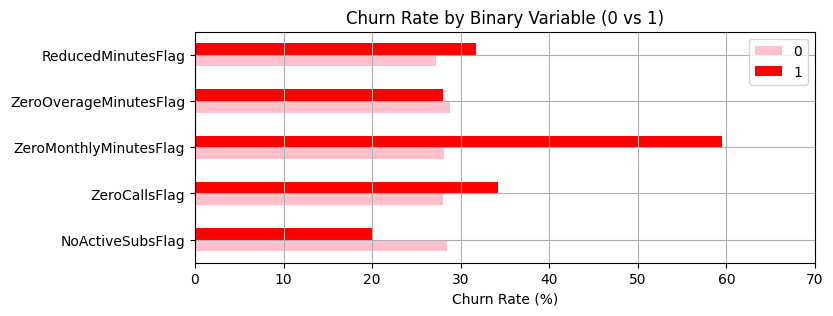

In [ ]:
# Plot histogram of MobileTotalCalls
plt.figure(figsize=(10, 16))
plt.subplot(4,2,1)
PlotNormDist('MobileTotalCalls', xmax=200)
plt.title('Normalised Distribution of MobileTotalCalls by Churn status')

# Plot bar chart of TotalCalls_Binned
churnrate_MobileTotalCalls_Binned_df = ChurnRateByVar('MobileTotalCalls_Binned')
ordered_bins = ['0', '1-99', '100-499', '500+']
churnrate_MobileTotalCalls_Binned_df['MobileTotalCalls_Binned'] = pd.Categorical(
    churnrate_MobileTotalCalls_Binned_df['MobileTotalCalls_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_MobileTotalCalls_Binned_df = churnrate_MobileTotalCalls_Binned_df.sort_values('MobileTotalCalls_Binned')
plt.subplot(4,2,2)
sns.barplot(
    x='MobileTotalCalls_Binned',
    y='ChurnRate',
    data=churnrate_MobileTotalCalls_Binned_df,
    color='Red'
)
plt.ylim(0,50)
plt.title('Churn Rate by MobileTotalCalls_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('MobileTotalCalls_Binned')
plt.grid(True)

# Plot histogram of AvCallDuration
plt.subplot(4,2,3)
PlotNormDist('AvCallDuration', xmax=20)
plt.title('Normalised Distribution of AvCallDuration by Churn status')

# Plot bar chart of AvCallDuration_Binned
churnrate_AvCallDuration_Binned_df = ChurnRateByVar('AvCallDuration_Binned')
ordered_bins = ['0.0', '0.1-9.9', '10.0-19.9', '20.0-29.9', '30.0+']
churnrate_AvCallDuration_Binned_df['AvCallDuration_Binned'] = pd.Categorical(
    churnrate_AvCallDuration_Binned_df['AvCallDuration_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_AvCallDuration_Binned_df = churnrate_AvCallDuration_Binned_df.sort_values('AvCallDuration_Binned')
colors = ['pink' if x == '0.0' else 'red' for x in churnrate_AvCallDuration_Binned_df['AvCallDuration_Binned']]
plt.subplot(4,2,4)
sns.barplot(
    x='AvCallDuration_Binned',
    y='ChurnRate',
    data=churnrate_AvCallDuration_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by AvCallDuration_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('AvCallDuration_Binned')
plt.grid(True)

# Plot Churn Rate by PropActiveSubs
churnrate_PropActiveSubs_df = ChurnRateByVar('PropActiveSubs')
plt.subplot(4,2,5)
plt.plot(
    churnrate_PropActiveSubs_df['PropActiveSubs'],
    churnrate_PropActiveSubs_df['ChurnRate'],
    marker='o',
    linestyle='-',
    color='Red')
plt.ylim(0,50)
plt.xlabel('PropActiveSubs')
plt.ylabel('Churn Rate (%)')
plt.title('Churn Rate by PropActiveSubs')
plt.grid(True)

# Plot Churn Rate by PropActiveSubs_Binned
churnrate_PropActiveSubs_Binned_df = ChurnRateByVar('PropActiveSubs_Binned')
ordered_bins = ['0.0', '0.1 - 0.49', '0.5 - 0.99', '1.0']
churnrate_PropActiveSubs_Binned_df['PropActiveSubs_Binned'] = pd.Categorical(
    churnrate_PropActiveSubs_Binned_df['PropActiveSubs_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_PropActiveSubs_Binned_df = churnrate_PropActiveSubs_Binned_df.sort_values('PropActiveSubs_Binned')
colors = ['pink' if x == '0.0' else 'red' for x in churnrate_PropActiveSubs_Binned_df['PropActiveSubs_Binned']]
plt.subplot(4,2,6)
sns.barplot(
    x='PropActiveSubs_Binned',
    y='ChurnRate',
    data=churnrate_PropActiveSubs_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by PropActiveSubs_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('PropActiveSubs_Binned')
plt.grid(True)

# Plot histogram
plt.subplot(4,2,7)
PlotNormDist('ServiceQualityIndicator', xmax=20, bins=30)
plt.title('Normalised Distribution of ServiceQualityIndicator by Churn status')

# Calculate Churn Rate
churnrate_ServiceQuality_Binned_df = ChurnRateByVar('ServiceQuality_Binned')

# Plot bar chart of binned feature
ordered_bins = ['NA', 'Good', 'Fair', 'Poor']
churnrate_ServiceQuality_Binned_df['ServiceQuality_Binned'] = pd.Categorical(
    churnrate_ServiceQuality_Binned_df['ServiceQuality_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_ServiceQuality_Binned_df = churnrate_ServiceQuality_Binned_df.sort_values('ServiceQuality_Binned')
colors = ['pink' if x == 'NA' else 'red' for x in churnrate_ServiceQuality_Binned_df['ServiceQuality_Binned']]
plt.subplot(4,2,8)
sns.barplot(
    x='ServiceQuality_Binned',
    y='ChurnRate',
    data=churnrate_ServiceQuality_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by Service Quality')
plt.ylabel('Churn Rate (%)')
plt.xlabel('ServiceQuality_Binned')
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot churn rate for binary flags
binary_cols = ['NoActiveSubsFlag', 'ZeroCallsFlag', 'ZeroMonthlyMinutesFlag', 'ZeroOverageMinutesFlag',
               'ReducedMinutesFlag']
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

churn_df = pd.DataFrame(churn_rates).T
churn_df.columns = ['0', '1']
churn_df.plot(kind='barh', figsize=(8, 3), legend=True, color=['pink', 'red'])
plt.title('Churn Rate by Binary Variable (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.xlim(0,70)
plt.grid(True)
plt.show()

In [ ]:
churnrate_MobileTotalCalls_Binned_df

MobileTotalCalls_Binned  ChurnRate  CustomerCount
0                       0  34.170591           3822
1                    1-99  29.388543          23305
2                 100-499  26.941176          17850
3                    500+  23.360107           2988

In [ ]:
churnrate_AvCallDuration_Binned_df

AvCallDuration_Binned  ChurnRate  CustomerCount
0                   0.0  41.176471             17
1               0.1-9.9  27.872050          35889
2             10.0-19.9  28.233479           3889
3             20.0-29.9  29.527208           1121
4                 30.0+  31.536388           7049

In [ ]:
churnrate_PropActiveSubs_Binned_df

PropActiveSubs_Binned  ChurnRate  CustomerCount
0                   0.0  20.000000             35
1            0.1 - 0.49  38.391225            547
2            0.5 - 0.99  33.544719           4573
3                   1.0  27.822939          42810

In [ ]:
churnrate_ServiceQuality_Binned_df

ServiceQuality_Binned  ChurnRate  CustomerCount
2                    NA  34.170591           3822
1                  Good  27.072293          30570
0                  Fair  29.189633           8527
3                  Poor  31.529925           5046

In [ ]:
churn_df

0          1
NoActiveSubsFlag        28.489464  20.000000
ZeroCallsFlag           27.990848  34.170591
ZeroMonthlyMinutesFlag  28.068285  59.463722
ZeroOverageMinutesFlag  28.840763  28.058571
ReducedMinutesFlag      27.260439  31.706208

Consistent with earlier findings, we observe the following patterns:

*	**Chatty Non-Churners:** Customers with higher call volumes exhibit a lower propensity to churn - from **34.1%** among those with zero call activity to **23.4%** among those making at least 500 calls per month per mobile subscription.

* **Budget-Consiocus Churners:** In contrast, customers who make longer calls are more likely to churn - with churn increasing from **27.8%** for those averaging under 10 minutes to **31.5%** for those averaging over 30 minutes. This trend may reflect cost sensitivity, with longer calls potentially incurring additional charges through overage minutes, leading to dissatisfaction and higher churn. An exception is a very small subset of customers with an average call duration of zero minutes, who exhibit an elevated churn rate of **41.2%**.

*	**Multi-Line Leavers vs Dormant Account Holders:** A small subset of customers with no active subscriptions — likely representing dormant accounts — exhibit a notably low churn rate (**20.0%**). Among other customers, churn decreases from **38.4%** to **27.8%** as the proportion of active subscriptions rises from below half to full activity.

*	**Exiting Decliners:** Customers with no recorded call minutes per month (`ZeroMonthlyMinutesFlag`) exhibit a markedly elevated risk of churn (**59.4%**). A related flag (`ZeroCallsFlag`) show a less extreme but still elevated churn rate (**34.2%**).

* **Service-Disrupted Churners:** Customers experiencing fewer than 5% dropped calls exhibit a churn rate of **27.1%**, while those with more than 10% dropped calls show a substantially higher churn rate of **31.5%**. The new `LocalArea` feature may further capture geographic variation in this effect.

### 6.2.3 Billing and Payments

We create the following new features with binned versions where appropriate:
* `MobileMonthlyBill`: customer's average monthly bill per mobile subscription.
* `MobileMonthlyTariff`: customer's monthly tariff per mobile subscription.
* `MonthlyTariffHandsetRatio`: ratio of customer's monthly tariff per mobile subscription and handset price.
* `CostPerMin`: effective cost per minute of mobile use.
* `CostPerOverageMin`: effective cost per minute of calls not included in tariff.

We also create the following binary flags to capture potentially meaningful bill and tariff anomalies associated with churn:

* `NoMonthlyTariffFlag`: identifies small subset of customers who pay no monthly tariff.
* `LowMonthlyBillFlag`: identifies customers whose bill is less than $25.
* `IncreasedBillFlag`: flags customers who have experienced a 20% or greater increase in their monthly bill.
* `AnomalousBillFlag`: identifies customers with a 20% or greater increase in their monthly bill despite a decrease in monthly minutes.

In [ ]:
# Create new features
cleaned_df['MobileMonthlyBill'] = cleaned_df['MonthlyRevenue']/(cleaned_df['UniqueSubs'])
cleaned_df['MobileMonthlyTariff'] = cleaned_df['TotalRecurringCharge']/(cleaned_df['UniqueSubs'])
cleaned_df['MonthlyTariffHandsetRatio'] = np.where(
    cleaned_df['HandsetPrice'] > 0,
    cleaned_df['TotalRecurringCharge'] / (cleaned_df['HandsetPrice']*cleaned_df['UniqueSubs']),
    np.nan
)
cleaned_df['CostPerMin'] = np.where(
    cleaned_df['MonthlyMinutes'] > 0,
    cleaned_df['MonthlyRevenue'] / cleaned_df['MonthlyMinutes'],
    np.nan
)
cleaned_df['CostPerOverageMin'] = np.where(
    (cleaned_df['OverageMinutes'] > 0),
    (cleaned_df['MonthlyRevenue'] - cleaned_df['TotalRecurringCharge']) / cleaned_df['OverageMinutes'],
    np.nan
)

In [ ]:
# Create binary flags
cleaned_df['NoMonthlyTariffFlag'] = (cleaned_df['MobileMonthlyTariff'] <= 0).astype(int)
cleaned_df['LowMonthlyBillFlag'] = (cleaned_df['MobileMonthlyBill'] < 25).astype(int)
cleaned_df['IncreasedBillFlag'] = (cleaned_df['PercChangeRevenues'] > 20).astype(int)
cleaned_df['AnomalousBillFlag'] = cleaned_df['IncreasedBillFlag'] * (cleaned_df['PercChangeMinutes'] < 0).astype(int)

In [ ]:
# Create binned version of MobileMonthlyBill
def bin_MobileMonthlyBill(bill):
    if pd.isna(bill):
        return 'Missing'
    elif bill < 25:
        return '<25'
    elif bill < 50:
        return '25-50'
    elif bill < 75:
        return '50-75'
    elif bill < 100:
        return '75-100'
    elif bill < 150:
        return '100-150'
    else:
        return '150+'

cleaned_df['MobileMonthlyBill_Binned'] = cleaned_df['MobileMonthlyBill'].apply(bin_MobileMonthlyBill)

In [ ]:
# Create binned version of MobileMonthlyTariff
def bin_MobileMonthlyTariff(tariff):
    if tariff == 0:
        return 'NoTariff'
    elif tariff < 25:
        return '0-25'
    elif tariff < 50:
        return '25–50'
    elif tariff < 75:
        return '50–75'
    else:
        return '75+'

cleaned_df['MobileMonthlyTariff_Binned'] = cleaned_df['MobileMonthlyTariff'].apply(bin_MobileMonthlyTariff)

In [ ]:
# Create binned version of MonthlyTariffHandsetRatio
def bin_MonthlyTariffHandsetRatio(ratio):
    if pd.isna(ratio):
        return 'NA'
    elif ratio < 0.3:
        return '0.0-0.3'
    elif ratio < 2:
        return '0.3-2.0'
    else:
        return '2.0+'

cleaned_df['MonthlyTariffHandsetRatio_Binned'] = cleaned_df['MonthlyTariffHandsetRatio'].apply(bin_MonthlyTariffHandsetRatio)

In [ ]:
# Create binned version of CostPerMin
def bin_CostPerMin(cost):
    if pd.isna(cost):
        return 'NA'
    elif cost < 0.1:
        return '0.0-0.1'
    elif cost < 0.2:
        return '0.1-0.2'
    elif cost < 0.3:
        return '0.2-0.3'
    else:
        return '0.3+'

cleaned_df['CostPerMin_Binned'] = cleaned_df['CostPerMin'].apply(bin_CostPerMin)

In [ ]:
# Create binned version of CostPerOverageMin
def bin_CostPerOverageMin(cost):
    if pd.isna(cost):
        return 'NA'
    elif cost < 0:
        return '< 0'
    elif cost < 0.3:
        return '0.0-0.3'
    else:
        return '0.3+'

cleaned_df['CostPerOverageMin_Binned'] = cleaned_df['CostPerOverageMin'].apply(bin_CostPerOverageMin)

<Figure size 400x400 with 0 Axes>

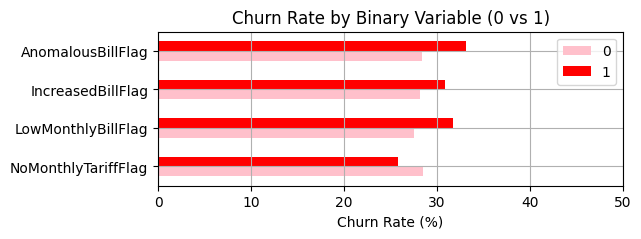

In [ ]:
# Create bar plot for MobileMonthlyBill_Binned
plt.figure(figsize=(10, 16))
churnrate_MobileMonthlyBill_Binned_df = ChurnRateByVar('MobileMonthlyBill_Binned')
ordered_bins = ['<25', '25-50', '50-75', '75-100', '100-150', '150+']
churnrate_MobileMonthlyBill_Binned_df['MobileMonthlyBill_Binned'] = pd.Categorical(
    churnrate_MobileMonthlyBill_Binned_df['MobileMonthlyBill_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_MobileMonthlyBill_Binned_df = churnrate_MobileMonthlyBill_Binned_df.sort_values('MobileMonthlyBill_Binned')
plt.subplot(4,2,1)
sns.barplot(
    x='MobileMonthlyBill_Binned',
    y='ChurnRate',
    data=churnrate_MobileMonthlyBill_Binned_df,
    color='Red'
)
plt.ylim(0,50)
plt.title('Churn Rate by MobileMonthlyBill_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('MobileMonthlyBill_Binned')
plt.grid(True)

# Plot bar chart for MobileMonthlyTariff_Binned
churnrate_MobileMonthlyTariff_Binned_df = ChurnRateByVar('MobileMonthlyTariff_Binned')
ordered_bins = ['NoTariff', '0-25', '25–50', '50–75', '75+']
churnrate_MobileMonthlyTariff_Binned_df['MobileMonthlyTariff_Binned'] = pd.Categorical(
    churnrate_MobileMonthlyTariff_Binned_df['MobileMonthlyTariff_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_MobileMonthlyTariff_Binned_df = churnrate_MobileMonthlyTariff_Binned_df.sort_values('MobileMonthlyTariff_Binned')
colors = ['pink' if x == 'NoTariff' else 'red' for x in churnrate_MobileMonthlyTariff_Binned_df['MobileMonthlyTariff_Binned']]
plt.subplot(4,2,2)
sns.barplot(
    x='MobileMonthlyTariff_Binned',
    y='ChurnRate',
    data=churnrate_MobileMonthlyTariff_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by MobileMonthlyTariff_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('MobileMonthlyTariff_Binned')
plt.grid(True)

# Plot histogram of MonthlyTariffHandsetRatio_Binned
plt.subplot(4,2,3)
PlotNormDist('MonthlyTariffHandsetRatio', xmax=5, bins=5)
plt.title('Normalised Distribution of MonthlyTariffHandsetRatio')

# Plot bar chart of MonthlyTariffHandsetRatio_Binned
churnrate_MonthlyTariffHandsetRatio_Binned_df = ChurnRateByVar('MonthlyTariffHandsetRatio_Binned')
plt.subplot(4,2,4)
ordered_bins = ['NA', '0.0-0.3', '0.3-2.0', '2.0+']
churnrate_MonthlyTariffHandsetRatio_Binned_df['MonthlyTariffHandsetRatio_Binned'] = pd.Categorical(
    churnrate_MonthlyTariffHandsetRatio_Binned_df['MonthlyTariffHandsetRatio_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_MonthlyTariffHandsetRatio_Binned_df = churnrate_MonthlyTariffHandsetRatio_Binned_df.sort_values('MonthlyTariffHandsetRatio_Binned')
colors = ['pink' if x == 'NA' else 'red' for x in churnrate_MonthlyTariffHandsetRatio_Binned_df['MonthlyTariffHandsetRatio_Binned']]
sns.barplot(
    x='MonthlyTariffHandsetRatio_Binned',
    y='ChurnRate',
    data=churnrate_MonthlyTariffHandsetRatio_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by MonthlyTariffHandsetRatio')
plt.ylabel('Churn Rate (%)')
plt.xlabel('MonthlyTariffHandsetRatio_Binned')
plt.tight_layout()
plt.grid(True)

# Plot histogram of CostPerMin
plt.subplot(4,2,5)
PlotNormDist('CostPerMin', xmax=1)
plt.title('Normalised Distribution of CostPerMin by Churn status')

# Plot Churn Rate of CostPerMin
churnrate_CostPerMin_Binned_df = ChurnRateByVar('CostPerMin_Binned')
plt.subplot(4,2,6)
ordered_bins = ['NA', '0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3+']
churnrate_CostPerMin_Binned_df['CostPerMin_Binned'] = pd.Categorical(
    churnrate_CostPerMin_Binned_df['CostPerMin_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_CostPerMin_Binned_df = churnrate_CostPerMin_Binned_df.sort_values('CostPerMin_Binned')
colors = ['pink' if x == 'NA' else 'red' for x in churnrate_CostPerMin_Binned_df['CostPerMin_Binned']]
sns.barplot(
    x='CostPerMin_Binned',
    y='ChurnRate',
    data=churnrate_CostPerMin_Binned_df,
    palette=colors
)
plt.ylim(0,60)
plt.title('Churn Rate by CostPerMin')
plt.ylabel('Churn Rate (%)')
plt.xlabel('CostPerMin_Binned')
plt.grid(True)

# Plot histogram of CostPerOverageMin
plt.subplot(4,2,7)
PlotNormDist('CostPerOverageMin', xmax=1, xmin=-0.5)
plt.title('Normalised Distribution of CostPerOverageMin by Churn status')

# Plot Churn Rate of CostPerOverageMin
churnrate_CostPerOverageMin_Binned_df = ChurnRateByVar('CostPerOverageMin_Binned')
plt.subplot(4,2,8)
ordered_bins = ['NA', '< 0', '0.0-0.3', '0.3+']
churnrate_CostPerOverageMin_Binned_df['CostPerOverageMin_Binned'] = pd.Categorical(
    churnrate_CostPerOverageMin_Binned_df['CostPerOverageMin_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_CostPerOverageMin_Binned_df = churnrate_CostPerOverageMin_Binned_df.sort_values('CostPerOverageMin_Binned')
colors = ['pink' if x == 'NA' else 'red' for x in churnrate_CostPerOverageMin_Binned_df['CostPerOverageMin_Binned']]
sns.barplot(
    x='CostPerOverageMin_Binned',
    y='ChurnRate',
    data=churnrate_CostPerOverageMin_Binned_df,
    palette=colors
)
plt.ylim(0,60)
plt.title('Churn Rate by CostPerOverageMin')
plt.ylabel('Churn Rate (%)')
plt.xlabel('CostPerOverageMin_Binned')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot churn rate for binary flags
plt.figure(figsize=(4, 4))
binary_cols = ['NoMonthlyTariffFlag', 'LowMonthlyBillFlag', 'IncreasedBillFlag', 'AnomalousBillFlag']
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

churn_df = pd.DataFrame(churn_rates).T
churn_df.columns = ['0', '1']
churn_df.plot(kind='barh', figsize=(6, 2), legend=True, color=['pink', 'red'])
plt.title('Churn Rate by Binary Variable (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.xlim(0,50)
plt.grid(True)
plt.show()

In [ ]:
churnrate_MobileMonthlyTariff_Binned_df

MobileMonthlyTariff_Binned  ChurnRate  CustomerCount
4                   NoTariff  26.086957            115
0                       0-25  32.082362          12870
1                      25–50  28.340302          22004
2                      50–75  25.787122           9846
3                        75+  23.258786           3130

In [ ]:
churnrate_MobileMonthlyBill_Binned_df

MobileMonthlyBill_Binned  ChurnRate  CustomerCount
5                      <25  31.688654          11370
2                    25-50  27.697588          19814
3                    50-75  27.431991           9190
4                   75-100  26.629470           3943
0                  100-150  26.935887           2402
1                     150+  28.330658           1246

In [ ]:
churnrate_MonthlyTariffHandsetRatio_Binned_df

MonthlyTariffHandsetRatio_Binned  ChurnRate  CustomerCount
3                               NA  29.894683          27346
0                          0.0-0.3  28.641271           4909
1                          0.3-2.0  26.676307          13139
2                             2.0+  22.403734           2571

In [ ]:
churnrate_CostPerMin_Binned_df

CostPerMin_Binned  ChurnRate  CustomerCount
4                NA  59.463722            634
0           0.0-0.1  24.614264          15101
1           0.1-0.2  28.217001          17493
2           0.2-0.3  30.227779           5839
3              0.3+  32.220724           8898

In [ ]:
churnrate_CostPerOverageMin_Binned_df

CostPerOverageMin_Binned  ChurnRate  CustomerCount
3                       NA  28.058571          21922
2                      < 0  25.398962           5201
0                  0.0-0.3  28.332434           7412
1                     0.3+  30.454207          13430

In [ ]:
churn_df

0          1
NoMonthlyTariffFlag  28.489915  25.833333
LowMonthlyBillFlag   27.487362  31.688654
IncreasedBillFlag    28.206443  30.826919
AnomalousBillFlag    28.422965  33.065811

We observe the following patterns:

*	**Budget-Conscious Churners:**
 * There is a monotonic relationship between monthly tariff (`MobileMonthlyTariff`) and churn with customers on the lowest tariffs (< \$25) exhibiting the highest churn rate (**32.1%**), while those on the highest tariffs (\$75+) show the lowest (**23.3%**). An exception to this trend is the customers with no tariff, who have a churn rate of **26.1%**.

  * In contrast, the relationship between monthly bills (`MobileMonthlyBill`) and churn is less clear. However customers with monthly bills less than $25 (`LowMonthlyBillFlag`) exhibit a distinctly elevated churn rate (**31.7%**).
  
   * Customers who have experienced a 20% or greater increase in their monthly bill (`IncreasedBillFlag`) also show an elevated propensity to churn (**30.8%**) which is even higher for customers who have also decreased their usage (`AnomalousBillFlag`).

 * Customers with higher costs per minute (`CostPerMin`) show an increased propensity to churn, rising from **24.6%** in the lowest cost band to **32.2%** in the highest. An exception to this trend is a small subset of customers who average zero minutes of calls per month; this group exhibits a markedly elevated churn rate of **59.4%**.

  * Similarly, customers with higher costs per minute outside their call plan (`CostPerOverageMin`) exhibit an increased likelihood of churn, rising from **25.4%** for customers on discounted overage rates to **30.5%** for the highest charges. An exception are the customers who make no calls in excess of their monthly allowance.

* **Value-misaligned churners:** Somewhat unexpectedly, customers with a more expensive handset relative to their monthly tariff (`MonthlyTariffHandsetRatio`) appear more likely to churn. This trend may be explained if handset costs are not bundled into the monthly tariff but are instead paid upfront — potentially resulting in customer dissatisfaction, as premium hardware paired with budget-level service may create a perceived value mismatch, increasing the likelihood of churn at contract renewal.

### 6.2.4 Customer interactions

We create a set of binary flags to capture potentially meaningful customer behaviours and retention interaction associated with churn:

* `CustomerCareEngagementFlag`: identify customers who contact Customer Care at least once every two months
* `MadeReferralFlag`: flag customers who have made at least one referral.
* `RetentionCallNoOfferAcceptedFlag`: identify customers who contacted the Retention Team but did not accept an offer.
* `RetentionCallContractExpiryFlag`: flag customers who accepted an offer and have been subscribed for 19 months

Using these flags, we also construct two composite features:
* `EngagementScore`, which aggregates multiple binary indicators of customer engagement; and
* `MissingInfoScore`, which quantifies the extent of missing or undisclosed customer information, capturing behavioural patterns that may correlate with churn propensity.

In [ ]:
# Create binary flags
cleaned_df['CustomerCareEngagementFlag'] = (cleaned_df['CustomerCareCalls'] >= 0.5).astype(int)
cleaned_df['MadeReferralFlag'] = (cleaned_df['ReferralsMadeBySubscriber'] > 0).astype(int)
cleaned_df['RetentionCallNoOfferAcceptedFlag'] = (cleaned_df['MadeCallToRetentionTeam'] *
 ((cleaned_df['RetentionOffersAccepted'] ==0).astype(int)))
cleaned_df['RetentionCallContractExpiryFlag'] = ((cleaned_df['RetentionOffersAccepted'] != 0).astype(int) *
 (cleaned_df['MonthsInService'] >= 19).astype(int))

In [ ]:
# Create composite features
cleaned_df['EngagementScore'] = cleaned_df['RespondsToMailOffers'] + cleaned_df['CustomerCareEngagementFlag'] + cleaned_df['MadeReferralFlag']
cleaned_df['MissingInfoScore'] = cleaned_df['MaritalStatus'].isin(['Unknown']).astype(int) + cleaned_df['AgeHH1MissingFlag']

In [ ]:
# Plot bar chart of Churn Rate for EngagementScore
churnrate_EngagementScore_df = ChurnRateByVar('EngagementScore')
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
sns.barplot(x='EngagementScore', y='ChurnRate', data=churnrate_EngagementScore_df, color='Red')
plt.title(f'Churn Rate by EngagementScore')
plt.xlabel('EngagementScore')
plt.ylabel('Churn Rate (%)')
plt.ylim(0,50)
plt.grid(True)

# Plot bar chart of Churn Rate for MissingInfoScore
churnrate_MissingInfoScore_df = ChurnRateByVar('MissingInfoScore')
plt.subplot(1,2,2)
sns.barplot(x='MissingInfoScore', y='ChurnRate', data=churnrate_MissingInfoScore_df, color='Red')
plt.title(f'Churn Rate by MissingInfoScore')
plt.xlabel('MissingInfoScore')
plt.ylabel('Churn Rate (%)')
plt.ylim(0,50)
plt.grid(True)
plt.show()

# Plot churn rate for binary flags
binary_cols = ['CustomerCareEngagementFlag', 'MadeReferralFlag', 'RetentionCallNoOfferAcceptedFlag',
               'RetentionCallContractExpiryFlag']
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

churn_df = pd.DataFrame(churn_rates).T
churn_df.columns = ['0', '1']
churn_df.plot(kind='barh', figsize=(6, 2), legend=True, color=['pink', 'red'])
plt.title('Churn Rate by Binary Variable (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.xlim(0,50)
plt.grid(True)
plt.show()

In [ ]:
churnrate_EngagementScore_df

EngagementScore  ChurnRate  CustomerCount
0                0  31.799963          16217
1                1  27.241240          24830
2                2  25.354043           6567
3                3  21.652422            351

In [ ]:
churnrate_MissingInfoScore_df

MissingInfoScore  ChurnRate  CustomerCount
0                 0  27.650450          28448
1                 1  29.229765           7660
2                 2  29.999157          11857

In [ ]:
churn_df

0          1
CustomerCareEngagementFlag        30.283217  25.603079
MadeReferralFlag                  28.574555  26.649077
RetentionCallNoOfferAcceptedFlag  28.196659  46.875000
RetentionCallContractExpiryFlag   28.368241  39.250493

Consistent with earlier analysis, the new features capture the following patterns:

* **Retention-Contact Churners:**
  * Customers who contacted the Retention Team but did not accept a renewal offer (`RetentionCallNoOfferAcceptedFlag`) exhibit a high churn rate of **46.9%**.
  * Customers who contacted the Rention Team and are approaching expiry of their second contract (`RetentionCallContractExpiryFlag`) also show an elevated churn rate of **39.3%.

* **Low-Discloure Churners:**  Customers with the lowest `MissingInfoScore` (ie. those disclosing minimal information) have a churn rate of **30.0%**, compared to **27.6%** for those with higher disclosure. This may reflect lower engagement or trust, both associated with higher churn risk.

* **Engaged Loyalists:**
  * Customers who contact the Customer Care line at least once every two months (`CustomerCareEngagementFlag`) are less likely to churn, with a churn rate of **25.6%**, compared to **30.3** among less-engaged customers.
  * Likewise, customers with the highest `EngagementScore` show a significantly lower churn rate (**21.7%**) compared to those with the lowest engagement scores (**31.8%**).

* **Indifferent Referrers:** Customers who have made a referral exhibit only a marginal reduction in churn, from **28.6%** to **26.6**, suggesting limited impact on retention.

### 6.2.5 Customer demographics

We derive the following engineered features to capture customer demographics and behavioral stability relevant to churn:

* `HouseholdSizeEstimate`: An estimated household size derived using a heuristic based on the presence of a second adult (`AgeHH2`), the customer's `MaritalStatus`, and whether there `ChildrenInHH` is flagged. We assume cohabitation where applicable and estimate one child per household when children are present.

* `AgeHH1_Binned`: A binned categorical variable derived from the age of the primary account holder (`AgeHH1`).

* `CustomerInertiaIndex`: A composite index reflecting behavioural stability, constructed by aggregating binary indicators such as home ownership information and handset-related characteristics (eg., refurbished vs. non-refurbished, web-capable). Each component is weighted according to its observed correlation with churn.

* `InertiaAgeProduct`: An interaction term representing the product of a scaled version of `AgeHH1` and the `CustomerInertiaIndex`. This captures the compounding effect of demographic maturity and behavioral stability on churn propensity.

Based on earlier analysis, we construct a set of binary flags:

* `GoodCreditFlag`: indicates customers with a strong credit profile, defined as a `CreditRating` between 3 (Good) and 1 (Highest);

* `HighIncomeLowCreditFlag`: identifies customers with a poor `CreditRating` ("5 Low") but a medium-to-high `IncomeGroup` (1-5), suggesting potential credit-risk mismatches;

* `CreditRatingAdjFlag`: flags customers who have experienced a credit rating adjustment, indicating recent financial reassessment.

In [ ]:
# Create new features
cleaned_df['HouseholdSizeEstimate'] = np.maximum(
    1 + (cleaned_df['AgeHH2'] >= 18).astype(int),
    (cleaned_df['MaritalStatus'] == 'Yes').astype(int) * 2
) + cleaned_df['ChildrenInHH']
cleaned_df['CustomerInertiaIndex'] = (
    0.25 * cleaned_df['Homeownership'] +
    0.25 * cleaned_df['NewCellphoneUser'] +
    1.00 * cleaned_df['HandsetWebCapable'] +
    0.50 * (1 - cleaned_df['HandsetRefurbished'])
)
cleaned_df['InertiaAgeProduct'] = cleaned_df['CustomerInertiaIndex'] * cleaned_df['AgeHH1'] / 80

# Create binary flags
cleaned_df['GoodCreditFlag'] = (cleaned_df['CreditRating_numeric'].between(1, 3)).astype(int)
cleaned_df['HighIncomeLowCreditFlag'] = (
    (cleaned_df['CreditRating_numeric'].between(5, 6)) &
    (cleaned_df['IncomeGroup'].between(1, 5))
).astype(int)
cleaned_df['CreditRatingAdjFlag'] = (cleaned_df['AdjustmentsToCreditRating'] > 0).astype(int)


In [ ]:
# Create binned variable AgeHH1_Binned
def bin_age(age):
    if age == 0:
        return 'Unknown'
    elif age < 25:
        return '18-24'
    elif age < 35:
        return '25-34'
    elif age < 50:
        return '35-49'
    elif age < 65:
        return '50-64'
    else:
        return '65+'

cleaned_df['AgeHH1_Binned'] = cleaned_df['AgeHH1'].apply(bin_age)

In [ ]:
# Plot InertiaAgeProduct (binned)
def bin_product(product):
    if product == 0:
        return '0.0'
    elif product < 0.5:
        return '0.0-0.5'
    elif product < 0.8:
        return '0.5-0.8'
    elif product < 1.2:
        return '0.8-1.2'
    else:
        return '1.2+'

cleaned_df['InertiaAgeProduct_Binned'] = cleaned_df['InertiaAgeProduct'].apply(bin_product)

In [ ]:
# Plot bar chart of Churn Rate for HouseholdSizeEstimate
churnrate_HouseholdSizeEstimate_df = ChurnRateByVar('HouseholdSizeEstimate')
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
sns.barplot(x='HouseholdSizeEstimate', y='ChurnRate', data=churnrate_HouseholdSizeEstimate_df, color='Red')
plt.title(f'Churn Rate by HouseholdSizeEstimate')
plt.xlabel('HouseholdSizeEstimate')
plt.ylabel('Churn Rate (%)')
plt.ylim(0,50)
plt.grid(True)

# Plot bar chart of Churn Rate of AgeHH1_Binned
churnrate_AgeHH1_Binned_df = ChurnRateByVar('AgeHH1_Binned')
plt.subplot(2,2,2)
ordered_bins = ['Unknown', '18-24', '25-34', '35-49', '50-64', '65+']
churnrate_AgeHH1_Binned_df['AgeHH1_Binned'] = pd.Categorical(
    churnrate_AgeHH1_Binned_df['AgeHH1_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_AgeHH1_Binned_df = churnrate_AgeHH1_Binned_df.sort_values('AgeHH1_Binned')
colors = ['pink' if x == 'Unknown' else 'red' for x in churnrate_AgeHH1_Binned_df['AgeHH1_Binned']]
sns.barplot(
    x='AgeHH1_Binned',
    y='ChurnRate',
    data=churnrate_AgeHH1_Binned_df,
    palette=colors
)
plt.ylim(0,50)
plt.title('Churn Rate by AgeHH1_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('AgeHH1 (Binned)')
plt.grid(True)

# Plot bar chart of Churn Rate for HouseholdSizeEstimate
churnrate_CustomerInertiaIndex_df = ChurnRateByVar('CustomerInertiaIndex')
plt.subplot(2,2,3)
sns.barplot(x='CustomerInertiaIndex', y='ChurnRate', data=churnrate_CustomerInertiaIndex_df, color='Red')
plt.title(f'Churn Rate by CustomerInertiaIndex')
plt.xlabel('CustomerInertiaIndex')
plt.ylabel('Churn Rate (%)')
plt.ylim(0,50)
plt.grid(True)

# Plot bar chart of Churn Rate for InertiaAgeProduct_Binned
churnrate_InertiaAgeProduct_Binned_df = ChurnRateByVar('InertiaAgeProduct_Binned')
ordered_bins = ['0.0', '0.0-0.5', '0.5-0.8', '0.8-1.2', '1.2+']
churnrate_InertiaAgeProduct_Binned_df['InertiaAgeProduct_Binned'] = pd.Categorical(
    churnrate_InertiaAgeProduct_Binned_df['InertiaAgeProduct_Binned'],
    categories=ordered_bins,
    ordered=True
)
churnrate_InertiaAgeProduct_Binned_df = churnrate_InertiaAgeProduct_Binned_df.sort_values('InertiaAgeProduct_Binned')
plt.subplot(2,2,4)
sns.barplot(
    x='InertiaAgeProduct_Binned',
    y='ChurnRate',
    data=churnrate_InertiaAgeProduct_Binned_df,
    color='Red'
)
plt.ylim(0,50)
plt.title('Churn Rate by InertiaAgeProduct_Binned')
plt.ylabel('Churn Rate (%)')
plt.xlabel('InertiaAgeProduct_Binned')
plt.tight_layout()
plt.grid(True)
plt.show()

# Plot churn rate for binary flags
binary_cols = ['GoodCreditFlag', 'HighIncomeLowCreditFlag', 'CreditRatingAdjFlag']
churn_rates = {}
for var in binary_cols:
    churn_rates[var] = cleaned_df.groupby(var)['Churn'].mean()*100

churn_df = pd.DataFrame(churn_rates).T
churn_df.columns = ['0', '1']
churn_df.plot(kind='barh', figsize=(6, 2), legend=True, color=['pink', 'red'])
plt.title('Churn Rate by Binary Variable (0 vs 1)')
plt.xlabel('Churn Rate (%)')
plt.xlim(0,50)
plt.grid(True)
plt.show()

In [ ]:
churnrate_HouseholdSizeEstimate_df

HouseholdSizeEstimate  ChurnRate  CustomerCount
0                      1  28.967565          21890
1                      2  27.070958          15319
2                      3  29.509111          10756

In [ ]:
churnrate_AgeHH1_Binned_df

AgeHH1_Binned  ChurnRate  CustomerCount
5       Unknown  29.722451          13367
0         18-24  32.160194           1648
1         25-34  29.482072           8283
2         35-49  27.509100          13461
3         50-64  27.253647           9529
4           65+  24.865832           1677

In [ ]:
churnrate_CustomerInertiaIndex_df

CustomerInertiaIndex  ChurnRate  CustomerCount
0                  0.00  40.853659            164
1                  0.25  38.246269            536
2                  0.50  36.310223            851
3                  0.75  36.082893           2461
4                  1.00  34.529759           2201
5                  1.25  29.824047           3410
6                  1.50  28.508932          10972
7                  1.75  26.801851          22685
8                  2.00  25.784418           4685

In [ ]:
churnrate_InertiaAgeProduct_Binned_df

InertiaAgeProduct_Binned  ChurnRate  CustomerCount
0                      0.0  29.782479          13424
1                  0.0-0.5  34.484325           4402
2                  0.5-0.8  29.289697          10939
3                  0.8-1.2  26.207695          13828
4                     1.2+  24.534624           5372

In [ ]:
churn_df

0          1
GoodCreditFlag           24.375478  30.240519
HighIncomeLowCreditFlag  28.958938  19.733118
CreditRatingAdjFlag      28.591817  25.566531

Consistent with previous analysis, we observe the following patterns:

* **Churn-Prone Young Adults vs Retired Loyalists:** Customer age is inversely correlated with churn. Customers aged 18-24 exhibit the highest churn rate (**32.2%**), with a consistent decline observed across older age groups. The lowest churn rate (**24.9%**) is observed among customers aged 65 and above.

* **Customer Inertia:** Stability-related factors—such as homeownership and handset characteristics (eg., web-enabled handset, non-refurbished handset etc) collectively reduce churn propensity. Customers with the lowest `CustomerInertiaIndex` (0.0) exhibit a churn rate of **40.9%**, which decreases steadily to **25.8%** for those with the highest index (2.0). This effect is further moderated by age: when combined with customer age in an interaction term (`InertiaAgeProduct`), churn falls from **29.8%** to **24.5%** across the range of the interaction score.

* **High-Expectation Churners:** Customers with strong credit ratings (`GoodCreditFlag`) exhibit a higher propensity to churn (**30.2%**) compared with others (**24.4%**).

* **Financially Anchored Loyalists:**
  * In contrast, customers with poor credit rating but medium to high incomes (`HighIncomeLowCreditFlag`) show a markedly lower churn rate (**19.7%**) than their counterparts (**29.0%**).
  * Customers with a history of credit rating adjustments (`CreditRatingAdjFlag`) demonstrate a slightly lower churn rate (**25.6%**) relative to those without such adjustments (**28.6%**).

### 6.3 Ordinal Feature Encoding

We manually encode ordinal categorical features to preserve the inherent numeric order of their categories. The encoding of nominal categorical features is model-specific and will be performed at a later stage in the modelling pipeline.

In [ ]:
# Assign ordered numeric codes to HandsetPrice_Binned
bin_map = {
    'Missing' : 0,
    'Unknown' : 1,
    '0-50'    : 2,
    '51-100'  : 3,
    '101-150' : 4,
    '151+'    : 5,
}

cleaned_df['HandsetPrice_Binned_encoded'] = cleaned_df['HandsetPrice_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to ServiceQuality_Binned
bin_map = {
    'NA': 0,
    'Good': 1,
    'Fair': 2,
    'Poor': 3,
}
cleaned_df['ServiceQuality_Binned_encoded'] = cleaned_df['ServiceQuality_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to MobileMonthlyTariff_Binned
bin_map = {
    'NoTariff': 0,
    '0-25': 1,
    '25–50': 2,
    '50–75': 3,
    '75+': 4,
}
cleaned_df['MobileMonthlyTariff_Binned_encoded'] = cleaned_df['MobileMonthlyTariff_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to MobileMonthlyBill_Binned
bin_map = {
    '<25'   : 1,
    '25-50'  : 2,
    '50-75'  : 3,
    '75-100' : 4,
    '100-150': 5,
    '150+'   : 6
}
cleaned_df['MobileMonthlyBill_Binned_encoded'] = cleaned_df['MobileMonthlyBill_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to PropActiveSubs_Binned
bin_map = {
    '0.0'       : 0,
    '0.1 - 0.49': 1,
    '0.5 - 0.99': 2,
    '1.0'       : 3
}
cleaned_df['PropActiveSubs_Binned_encoded'] = cleaned_df['PropActiveSubs_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to MobileTotalCalls_Binned
bin_map = {
    '0' : 0,
    '1-99' : 1,
    '100-499' : 2,
    '500+' : 3
}

cleaned_df['MobileTotalCalls_Binned_encoded'] = cleaned_df['MobileTotalCalls_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to AvCallDuration_Binned
bin_map = {
    '0.0' : 0,
    '0.1-9.9' : 1,
    '10.0-19.9' : 2,
    '20.0-29.9' : 3,
    '30.0+' : 4
    }

cleaned_df['AvCallDuration_Binned_encoded'] = cleaned_df['AvCallDuration_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to AgeHH1_Binned
bin_map = {
    'Unknown': 0,
    '18-24': 1,
    '25-34': 2,
    '35-49': 3,
    '50-64': 4,
    '65+' : 5
}
cleaned_df['AgeHH1_Binned_encoded'] = cleaned_df['AgeHH1_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to MonthlyTariffHandsetRatio_Binned
bin_map = {
    'NA': 0,
    '0.0-0.3' : 1,
    '0.3-2.0' : 2,
    '2.0+' : 3
}
cleaned_df['MonthlyTariffHandsetRatio_Binned_encoded'] = cleaned_df['MonthlyTariffHandsetRatio_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to CostPerMin_Binned
bin_map = {
    'NA' : 0,
    '0.0-0.1' : 1,
    '0.1-0.2' : 2,
    '0.2-0.3' : 3,
    '0.3+' : 4
}
cleaned_df['CostPerMin_Binned_encoded'] = cleaned_df['CostPerMin_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to CostPerOverageMin_Binned
bin_map = {
    'NA' : 0,
    '< 0' : 1,
    '0.0-0.3' : 2,
    '0.3+' : 3
}
cleaned_df['CostPerOverageMin_Binned_encoded'] = cleaned_df['CostPerOverageMin_Binned'].map(bin_map)

In [ ]:
# Assign ordered numeric codes to InertiaAgeProduct_Binned
bin_map = {
    '0.0' : 0,
    '0.0-0.5' : 1,
    '0.5-0.8' : 2,
    '0.8-1.2' : 3,
    '1.2+' : 4
}
cleaned_df['InertiaAgeProduct_Binned_encoded'] = cleaned_df['InertiaAgeProduct_Binned'].map(bin_map)

## 7 Model Construction

We construct three machine learning models for customer churn classification, each offering complementary strengths:

* **Decision Tree (Baseline):** A simple, interpretable model that trains quickly and serves as a baseline to evaluate the added value of more sophisticated approaches.

* **XGBoost Ensemble:** A powerful and scalable implementation of gradient boosting, well-suited for structured data. This is our primary model for performance optimization and feature importance analysis.

* **Neural Network:** Introduced in later stages to evaluate nonlinear representations using a trimmed feature set. The model requires preprocessing steps such as feature scaling and outlier treatment, and offers an additional lens for understanding hidden churn patterns beyond tree-based ensembles.

### 7.1 Feature Selection

For the Single Decision Tree model, we retain features exhibiting a churn gap greater than **5.0%**, as they offer stronger predictive separation. We also exclude `LocalArea` due to its high cardinality (526 unique values), which would introduce excessive sparsity when one-hot encoded.

For the XGBoost model, we apply a more inclusive threshold, retaining features with a churn gap greater than **3.0%**, leveraging the model's ability to capture nonlinear interactions and handle moderately informative variables.

|Category | Feature | Type | Source | Encoding Status | Churn Gap | SDT | XGB |
|----|----|---|---|||||
| **Service Plan** ||||||
|| `HandsetWebCapable` | binary | base || 9.4% |x| x |
|| `HandsetRefurbished` | binary | base || 3.6% || x |
|| `NewCellphoneUser` | binary | base || 0.7% |||
|| `NotNewCellphoneUser` | binary | base || 0.7% |||
|| `ContractExpiryFlag` | binary | engineered || 16.0%|x|x|
|| `HandsetPriceUnknownFlag` | binary | engineered || 3.3% ||x|
|| `NoUpgradeFlag`| binary | engineered || 3.8% ||x|
|| `CurrentEquipmentOneYearFlag`| binary | engineered || 15.7% |x|x |
|| `CurrentEquipmentOneYearFlagv2`| binary | engineered || 9.2% |x| x|
|| `MissingHandsetFlag`| binary | engineered || 5.2% |x|x |
|| `ReplacementHandsetFlag`| binary | engineered || 2.4% ||
|| `NonWebHandsetRegretFlag`| binary | engineered || 17.4%|x |x |
|| `HandsetPrice_Binned_encoded` | ordinal | engineered | encoded | 1.1% |||
|| `MonthsInService` | discrete | base |||x|x|
|| `CurrentEquipmentMonths` | discrete | engineered ||||x|
| **Usage Pattern** |||||
|| `NoActiveSubsFlag` | binary | engineered || 8.5% | x|x |
|| `ZeroCallsFlag` | binary | engineered || 6.2% |x|x |
|| `ReducedMinutesFlag` | binary | engineered || 4.4% ||x|
|| `ZeroMonthlyMinutesFlag` | binary | engineered || 31.4% |x|x|
|| `ZeroOverageMinutesFlag` | binary | engineered || 0.8% |||
|| `AvCallDuration_Binned_encoded` | ordinal | engineered | encoded | 3.7% |x|x|
|| `PropActiveSubs_Binned_encoded` | ordinal | engineered | encoded | 10.6% |x|x|
|| `ServiceQuality_Binned_encoded` | ordinal | engineered | encoded | 4.5% |x|x|
|| `MobileTotalCalls_Binned_encoded` | ordinal | engineered | encoded |10.8% |x|x|
|| `PercChangeMinutes` | continuous | base ||| x|x|
|| `PercChangeRevenues` | continuous | base |||||
| **Billing and Payments** ||||||
|| `AnomalousBillFlag` | binary | engineered || 4.6% ||x|
|| `IncreasedBillFlag` | binary | engineered || 2.6% |||
|| `LowMonthlyBillFlag` | binary | engineered || 4.2% ||x|
|| `NoMonthlyTariffFlag` | binary | engineered || 2.7% |||
|| `CostPerMin_Binned_encoded` | ordinal | engineered | encoded | 7.6% | x|x|
|| `CostPerOverageMin_Binned_encoded` | ordinal | engineered | encoded | 5.1% | x|x|
|| `MobileMonthlyTariff_Binned_encoded`|  ordinal | engineered | encoded | 8.8% |x|x|
|| `MobileMonthlyBill_Binned_encoded`| ordinal | engineered | encoded | 3.4% ||x|
|| `MonthlyTariffHandsetRatio_Binned_encoded`| ordinal | engineered | encoded | 6.2% | x|x|
| **Customer Interactions** ||||||
|| `BuysViaMailOrder` | binary | base || 1.9% |||
|| `MadeCallToRetentionTeam` | binary | base || 15.7% |x|x|
|| `OptOutMailings` | binary | base || 0.4% |||
|| `RespondsToMailOffers` | binary | base || 1.9% |||
|| `CustomerCareEngagementFlag` | binary | engineered || 4.7% ||x|
|| `MadeReferralFlag` | binary | engineered || 1.9% |||
|| `RetentionCallNoOfferAcceptedFlag` | binary | engineered || 18.7%|x|x|
|| `RetentionCallContractExpiryFlag` | binary | engineered || 10.9%|x|x|
|| `AgeHH1MissingFlag` | binary | engineered || 1.7% |||
|| `AgeHH2MissingFlag` | binary | engineered || 0.9%|||
|| `RetentionOffersAccepted` | discrete | base |||||
|| `MissingInfoScore` | discrete | engineered || 2.3% |||
|| `EngagementScore` | discrete | engineered || 10.1% |x|x|
| **Customer Demographics** ||||||
|| `ChildrenInHH` | binary | base || 1.3% |||
|| `HasCreditCard` | binary | base || 0.7% |||
|| `Homeownership` | binary | base || 1.1% |||
|| `OwnsMotorcycle` | binary | base || 2.8% |||
|| `GoodCreditFlag` | binary | engineered || 5.9% |x|x|
|| `HighIncomeLowCreditFlag` | binary | engineered || 9.2% |x|x|
|| `CreditRatingAdjFlag` | binary | engineered || 3.0% ||x|
|| `PrizmCode` | nominal | engineered | pending (model-specific) | 3.4% ||x|
|| `Occupation` | nominal | engineered | pending (model-specific) | 8.0% ||x|
|| `MaritalStatus` | nominal | engineered | pending (model-specific) |3.2%||x|
|| `LocalArea` | nominal | engineered | pending (model-specific) | || x |
|| `IncomeGroup` | ordinal | base | encoded | 4.0% ||x|
|| `AgeHH1_Binned_encoded` | ordinal | engineered | encoded | 7.3%|x|x|
|| `CreditRating_numeric` | ordinal | engineered | encoded | 8.9%|x|x|
|| `CustomerInertiaIndex` | discrete | engineered ||15.1%|x|x|
|| `InertiaAgeProduct_Binned_encoded` | ordinal | engineered | encoded | 9.9% |x|x|
|| `HouseholdSizeEstimate` | discrete | engineered || 2.4% |||


In [ ]:
# List selected features for XGB
selected_features_xgb = [
    # BASE VARIABLES: Binary
    'MadeCallToRetentionTeam', 'HandsetWebCapable', 'HandsetRefurbished',
    # BASE VARIABLES: Ordinal
    'IncomeGroup',
    # BASE VARIABLES: Discrete
    'MonthsInService',
    # BASE VARIABLES: Continuous
    'PercChangeMinutes',
    # ENGINEERED: Binary
    'HandsetPriceUnknownFlag', 'ContractExpiryFlag', 'NoUpgradeFlag', 'CurrentEquipmentOneYearFlag',
    'CurrentEquipmentOneYearFlagv2', 'MissingHandsetFlag', 'NonWebHandsetRegretFlag', 'NoActiveSubsFlag',
    'ZeroCallsFlag', 'ReducedMinutesFlag', 'AnomalousBillFlag', 'CustomerCareEngagementFlag',
    'RetentionCallNoOfferAcceptedFlag', 'RetentionCallContractExpiryFlag', 'GoodCreditFlag', 'HighIncomeLowCreditFlag',
    'CreditRatingAdjFlag', 'ZeroMonthlyMinutesFlag', 'LowMonthlyBillFlag',
    # ENGINEERED: Ordinal
    'CreditRating_numeric', 'ServiceQuality_Binned_encoded', 'AgeHH1_Binned_encoded', 'MobileMonthlyBill_Binned_encoded',
    'MobileMonthlyTariff_Binned_encoded', 'CostPerMin_Binned_encoded', 'CostPerOverageMin_Binned_encoded', 'PropActiveSubs_Binned_encoded', 'AvCallDuration_Binned_encoded',
    'MobileTotalCalls_Binned_encoded', 'MonthlyTariffHandsetRatio_Binned_encoded', 'InertiaAgeProduct_Binned_encoded',
    # ENGINEERED: Nominal
    'PrizmCode', 'Occupation', 'MaritalStatus', 'LocalArea',
    # ENGINEERED: Discrete
    'CurrentEquipmentMonths', 'EngagementScore', 'CustomerInertiaIndex']

### 7.2 Split the data
We define the target variable and isolate the selected features to prepare the dataset for model training and evaluation.


In [ ]:
# Assign target variable
y = cleaned_df['Churn']

# Assign features
X = cleaned_df[selected_features_xgb]


We split the data into training, validation and test sets, 60/20/20.

In [ ]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((28779, 44), (9593, 44), (9593, 44), (28779,), (9593,), (9593,))

#### 7.2.1 Handling Nominal Categorical Features

The *scikit-learn* library's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) does not handle categorical data natively and interprets all features as continuous numerical variables. To address this, we use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to transform nominal categorical features into binary indicator variables.

In [ ]:
# List nominal categorical features for SDT
nominal_features_sdt = []

In [ ]:
# Encode nominal categorical features for Decision Tree Classifier
ohe = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'), nominal_features_sdt)],
    remainder='passthrough'
)

drop_features_sdt = [
    'HandsetRefurbished', 'HandsetPriceUnknownFlag', 'NoUpgradeFlag', 'CurrentEquipmentMonths',
    'ReducedMinutesFlag', 'AnomalousBillFlag', 'LowMonthlyBillFlag', 'MobileMonthlyBill_Binned_encoded',
    'CustomerCareEngagementFlag', 'CreditRatingAdjFlag', 'PrizmCode', 'Occupation', 'MaritalStatus',
    'LocalArea', 'IncomeGroup'
]

X_train_sdt = X_train.drop(columns=drop_features_sdt)
X_val_sdt   = X_val.drop(columns=drop_features_sdt)
X_test_sdt  = X_test.drop(columns=drop_features_sdt)

X_train_sdt = ohe.fit_transform(X_train_sdt)
X_val_sdt = ohe.transform(X_val_sdt)
X_test_sdt = ohe.transform(X_test_sdt)

In [ ]:
# Create Dataframe
encoded_features_sdt = ohe.get_feature_names_out()
clean_feature_names_sdt = [name.replace('ohe__', '').replace('remainder__', '') for name in encoded_features_sdt]
X_train_sdt_df = pd.DataFrame(X_train_sdt, columns=clean_feature_names_sdt)


In [XGBoost](https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html) version 1.6 and later, native support for categorical variables is available via the `enable_categorical=True` flag. Therefore, we convert nominal categorical features to the *category* data type, allowing XGBoost to treat them appropriately during training.

In [ ]:
# List nominal categorical features for XGB
nominal_features_xgb = ['PrizmCode', 'Occupation', 'MaritalStatus', 'LocalArea']

In [ ]:
# Assign dtype 'category' to nominal categorical features
X_train_xgb = X_train.copy()
X_val_xgb = X_val.copy()
X_test_xgb = X_test.copy()

for df in [X_train_xgb, X_val_xgb, X_test_xgb]:
    df[nominal_features_xgb] = df[nominal_features_xgb].astype("category")

In [ ]:
# Print the dtype for each nominal feature
for col in nominal_features_xgb:
    print(f"{col}: {X_train_xgb[col].dtype}")

PrizmCode: category
Occupation: category
MaritalStatus: category
LocalArea: category


##7.3 Model Training

### 7.3.1 Decision Tree

We employ the [*DecisionTreeClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit a single decision tree classification model to the training dataset. Hyperparameters are tuned using [*GridSearchCV*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), with the best model selected based on the $F_1$ score.

In [ ]:
# Instantiate the decision tree classifier
dt = DecisionTreeClassifier(random_state=0, class_weight='balanced')

# Create a dictionary of hyperparameters to search over
cv_params = {
    'max_depth': [5, 10, 15, None],
    'max_features': [None, 'sqrt', 0.6],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

# Define scoring metrics for classification
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the GridSearchCV object for cross-validation
dt_cv = GridSearchCV(
    estimator=dt,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='f1',
    return_train_score=True
    )

In [ ]:
%%time
# Fit the decision tree classifier to the training data
dt_cv.fit(X_train_sdt, y_train)

CPU times: user 29.1 s, sys: 66.3 ms, total: 29.2 s
Wall time: 29.4 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=0),
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': [None, 'sqrt', 0.6],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 5]},
             refit='f1', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [ ]:
# Access the best fitted single decision tree model
best_sdt = dt_cv.best_estimator_

In [ ]:
# Access the GridSearchCV results and convert to a DataFrame
dt_results_df = pd.DataFrame(dt_cv.cv_results_)

# Create a line plot of F1 score by GridSearchCV iteration
plt.figure(figsize=(8, 6))
sns.lineplot(data=dt_results_df, x=dt_results_df.index, y='mean_test_f1', color='Pink')
plt.title('Decision Tree: F1 Score by GridSearchCV iteration')
plt.xlabel('GridSearchCV iteration')
plt.ylabel('F1 Score')
best_iter = dt_results_df['mean_test_f1'].idxmax()
best_score = dt_results_df.loc[best_iter, 'mean_test_f1']
plt.scatter(best_iter, best_score, s=100, facecolors='none', edgecolors='Red', color='pink', linewidths=1)

# Save to file
plt.savefig("decision_tree-f1_score_by_iteration.png", dpi=300)

# Show the plot
plt.show()

# Display results
print(
    f"Best F1 score: {dt_cv.best_score_:.4f} found on GridSearchCV iteration {best_iter + 1} "
    f"of {dt_results_df.shape[0]}, with these Decision Tree model parameters:"
)
print(dt_cv.best_params_)

Best F1 score: 0.4479 found on GridSearchCV iteration 1 of 48, with these Decision Tree model parameters:
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


### 7.3.2 XGBoost

We implement the [XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) with native categorical support enabled (`tree_method="hist"`, `enable_categorical=True`) to fit a gradient-boosted ensemble model to the training dataset. Hyperparameters are optimized using [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), and the best-performing model is selected based on the highest cross-validated $F_1$ score.

In [ ]:
# Examine class imbalance and compute scale_pos_weight for XGBoost
churn_rate = y_train.value_counts()[1] / y_train.shape[0]
non_churn_rate = 1 - churn_rate
scale_pos_weight = non_churn_rate / churn_rate

In [ ]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(
    tree_method="hist",      # categorical partitioning
    enable_categorical=True, # categorical partitioning
    random_state=0,
    eval_metric='logloss'
    )

In [ ]:
# Create a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 0.9],
    'min_child_weight': [1, 2, 3],
    'scale_pos_weight':  [0.8 * scale_pos_weight, scale_pos_weight, 1.2 * scale_pos_weight],
    'colsample_bytree': [0.6, 0.8, 1.0]
    }

# Define scoring metric for RandomizedSearchCV
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the RandomizedSearchCV object for cross-validation
f1_churn = make_scorer(f1_score, pos_label=1)
xgb_cv = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=cv_params,
    scoring={'f1': f1_churn},
    refit='f1',
    cv=5,
    n_iter=50,
    random_state=0,
    n_jobs=-1
)

In [ ]:
%%time
# Fit the XGBoost classifer to the training data
xgb_cv.fit(X_train_xgb, y_train)

CPU times: user 7.34 s, sys: 799 ms, total: 8.13 s
Wall time: 5min 29s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                        'learning_rate': [0.02, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [np.float64(2.053290370553972),
                                                             np.float64(2.566612963192465),
                                                             np.float64(3.079935555830958)],
                                        'subsample': [0.6, 0.8, 0.9]},
                   random_state=0, refit='f1',
                   scoring={'f1': make_scorer(f1_score, response_method='predict', pos_label=1)})

In [ ]:
# Access the best fitted XGBoost model
best_xgb = xgb_cv.best_estimator_

# Save using XGBoost's native method
best_xgb.save_model("categorical-model.json")

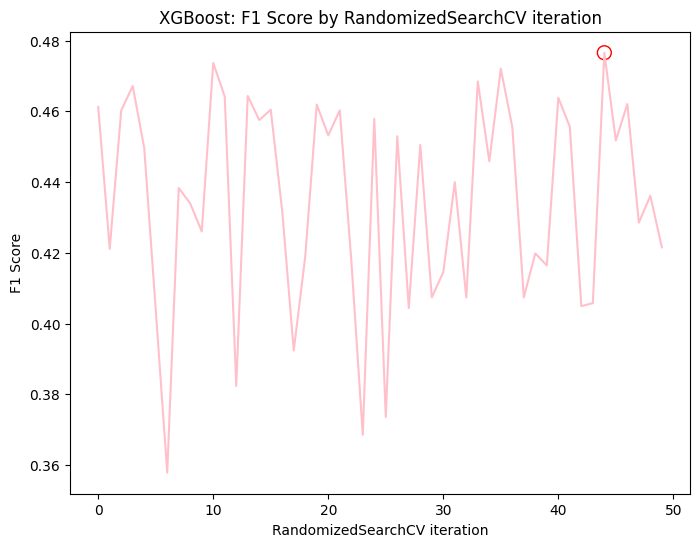

Best F1 score: 0.4766 found on RandomizedSearchCV iteration 45 of 50, with these Decision Tree Ensemble XGBoost model parameters:
{'subsample': 0.9, 'scale_pos_weight': np.float64(3.079935555830958), 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}


In [ ]:
# Access the GridSearch results and convert it to a pandas df
xgb_results_df = pd.DataFrame(xgb_cv.cv_results_)

# Create a line plot of F1 score by RandomizedSearchCV iteration
plt.figure(figsize=(8, 6))
sns.lineplot(data=xgb_results_df, x=xgb_results_df.index, y='mean_test_f1', color='Pink')
plt.title('XGBoost: F1 Score by RandomizedSearchCV iteration')
plt.xlabel('RandomizedSearchCV iteration')
plt.ylabel('F1 Score')
best_iter = xgb_results_df['mean_test_f1'].idxmax()
best_score = xgb_results_df.loc[best_iter, 'mean_test_f1']
plt.scatter(best_iter, best_score, s=100, facecolors='none', edgecolors='Red', color='pink', linewidths=1)

# Save to file
plt.savefig("xgboost-f1_score_by_iteration.png", dpi=300)

# Show the plot
plt.show()

# Display results
print(
    f"Best F1 score: {xgb_cv.best_score_:.4f} found on RandomizedSearchCV iteration {best_iter + 1} "
    f"of {xgb_results_df.shape[0]}, with these Decision Tree Ensemble XGBoost model parameters:"
)
print(xgb_cv.best_params_)

### 7.4 Initial Feature Importance Exploration

We conduct a comparative feature importance analysis using the *feature_importances_* attribute from the *scikit-learn* library. This analysis is applied to both tree-based models: the baseline Single Decision Tree and the XGBoost ensemble, enabling us to identify the most predictive features based on structural learning within each model.

In [ ]:
# Feature importance analysis for Decision Tree
importances_sdt = dt_cv.best_estimator_.feature_importances_
rf_importances_sdt = pd.Series(importances_sdt, index=X_train_sdt_df.columns)
top_importances_sdt = rf_importances_sdt.sort_values(ascending=False).head(15)
top_importances_sorted_sdt = top_importances_sdt.sort_values(ascending=True)


In [ ]:
# Feature importance analysis for XGBoost
importances_xgb = xgb_cv.best_estimator_.feature_importances_
rf_importances_xgb = pd.Series(importances_xgb, index=X_train_xgb.columns)
top_importances_xgb = rf_importances_xgb.sort_values(ascending=False).head(15)
top_importances_sorted_xgb = top_importances_xgb.sort_values(ascending=True)


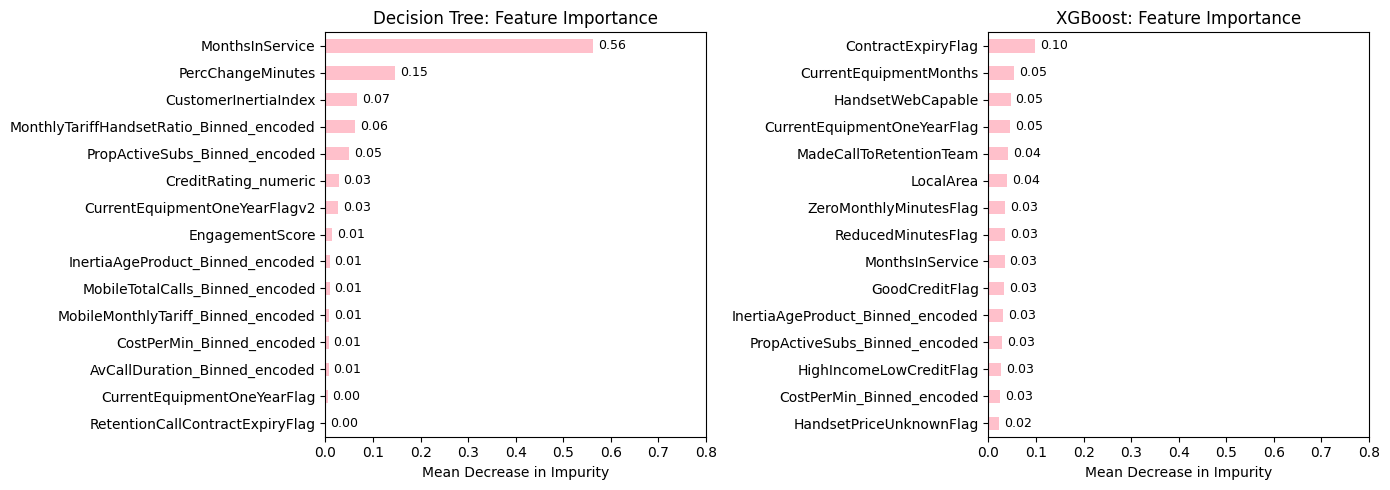

In [ ]:
# Create a side-by-side horizontal bar chart comparison
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

top_importances_sorted_sdt.plot.barh(
    ax=ax1,
    color='pink',
    legend=False
)
ax1.set_xlim(0, 0.8)
ax1.set_title('Decision Tree: Feature Importance')
ax1.set_xlabel('Mean Decrease in Impurity')
for i, (feature, importance) in enumerate(top_importances_sorted_sdt.items()):
    ax1.text(importance + 0.01, i, f"{importance:.2f}", va='center', fontsize=9)

top_importances_sorted_xgb.plot.barh(
    ax=ax2,
    color='pink',
    legend=False
)
ax2.set_xlim(0, 0.8)
ax2.set_title('XGBoost: Feature Importance')
ax2.set_xlabel('Mean Decrease in Impurity')
for i, (feature, importance) in enumerate(top_importances_sorted_xgb.items()):
    ax2.text(importance + 0.01, i, f"{importance:.2f}", va='center', fontsize=9)

fig.tight_layout()
plt.savefig("model_feature_importance_comparison.png", dpi=300)
plt.show()

### 7.5 Feature Selection for Neural Network Model

We select the 20 most predictive features based on feature importance rankings derived from our Decision Tree and XGBoost models. These selections reflect patterns captured by ensemble and rule-based learners, forming a well-informed foundation for the neural network architecture.


| Category              | Feature                                  | Type      | Source      | Encoding Status             | Churn Gap | SDT | XGB |
|-----------------------|------------------------------------------|-----------|-------------|-----------------------------|-----------|-----|-----|
| **Service Plan**      | `HandsetWebCapable`                      | binary    | base        | —                           | 9.4%      | x   | x   |
|                       | `ContractExpiryFlag`                     | binary    | engineered  | —                           | 16.0%     | x   | x   |
|                       | `CurrentEquipmentOneYearFlag`            | binary    | engineered  | —                           | 15.7%     | x   | x   |
|                       | `CurrentEquipmentMonths`                 | discrete  | engineered  | —                           | —         |     | x   |
|                       | `HandsetPriceUnknownFlag`               | binary    | engineered  | —                           | 3.3%      |     | x   |
| **Usage Pattern**     | `ZeroMonthlyMinutesFlag`                 | binary    | engineered  | —                           | 31.4%     | x   | x   |
|                       | `ReducedMinutesFlag`                     | binary    | engineered  | —                           | 4.4%      |     | x   |
|                       | `PropActiveSubs_Binned_encoded`          | ordinal   | engineered  | encoded                     | 10.6%     | x   | x   |
|                       | `MonthlyTariffHandsetRatio_Binned_encoded`| ordinal | engineered  | encoded                     | 6.2%      | x   | x   |
|                       | `PercChangeMinutes`                      | continuous| base        | —                           | —         | x   | x   |
| **Billing and Payments**| `CostPerMin_Binned_encoded`            | ordinal   | engineered  | encoded                     | 7.6%      | x   | x   |
|                       | `CostPerOverageMin_Binned_encoded`       | ordinal   | engineered  | encoded                     | 5.1%      | x   | x   |
| **Customer Interactions**| `MadeCallToRetentionTeam`             | binary    | base        | —                           | 15.7%     | x   | x   |
| **Customer Demographics**| `LocalArea`                            | nominal   | engineered  | pending (model-specific)  | —         |     | x   |
|                       | `GoodCreditFlag`                         | binary    | engineered  | —                           | 5.9%      | x   | x   |
|                       | `HighIncomeLowCreditFlag`                | binary    | engineered  | —                           | 9.2%      | x   | x   |
|                       | `CreditRating_numeric`                   | ordinal   | engineered  | encoded                     | 8.9%      | x   | x   |
|                       | `CustomerInertiaIndex`                   | discrete  | engineered  | —                           | 15.1%     | x   | x   |
|                       | `InertiaAgeProduct_Binned_encoded`       | ordinal   | engineered  | encoded                     | 9.9%      | x   | x   |
|                       | `MonthsInService`                        | discrete  | base        | —                           | —         | x   | x   |

In [ ]:
# List all model-ready features for neural network training
top_features = [
    # Single Decision Tree
    'MonthsInService', 'PercChangeMinutes', 'CustomerInertiaIndex', 'MonthlyTariffHandsetRatio_Binned_encoded',
    'PropActiveSubs_Binned_encoded', 'CreditRating_numeric',
    # XGBoost
    'ContractExpiryFlag', 'CurrentEquipmentMonths', 'HandsetWebCapable', 'CurrentEquipmentOneYearFlag', 'MadeCallToRetentionTeam',
    'LocalArea', 'ZeroMonthlyMinutesFlag', 'ReducedMinutesFlag', 'GoodCreditFlag', 'InertiaAgeProduct_Binned_encoded',
    'HighIncomeLowCreditFlag', 'CostPerMin_Binned_encoded', 'HandsetPriceUnknownFlag', 'CostPerOverageMin_Binned_encoded'
    ]


In [ ]:
# Apply revised feature set to training and validation splits
X_train_reduced = X_train_xgb[top_features]
X_val_reduced   = X_val_xgb[top_features]

X_train_reduced = X_train_reduced.copy()
X_val_reduced = X_val_reduced.copy()

To enable effective learning from the high-cardinality nominal feature `LocalArea`, we encode it as integer indices. This prepares the feature for transformation via an embedding layer within the neural network.

In [ ]:
# Encode LocalArea for embedding input
le = LabelEncoder()
X_train_reduced['LocalArea_enc'] = le.fit_transform(X_train_reduced['LocalArea'])
X_val_reduced['LocalArea_enc'] = le.fit_transform(X_val_reduced['LocalArea'])


In [ ]:
# Prepare model input arrays
X_train_localarea = X_train_reduced['LocalArea_enc'].values.reshape(-1, 1).astype('int32')
X_train_numeric = X_train_reduced.drop(columns=['LocalArea', 'LocalArea_enc']).values

X_val_localarea = X_val_reduced['LocalArea_enc'].values.reshape(-1, 1).astype('int32')
X_val_numeric   = X_val_reduced.drop(columns=['LocalArea', 'LocalArea_enc']).values

### 7.6 Neural Network Model Training

We implement a TensorFlow neural network using the Keras API to perform binary classification on the refined training dataset. The architecture comprises fully connected layers with ReLU activations and a sigmoid output node, specifically designed for churn prediction. Input features are scaled to support effective gradient descent, and dropout regularization is applied to mitigate overfitting. Key hyperparameters—such as layer width, dropout rate, and batch size—are tuned via randomized cross-validation, with model selection based on the highest cross-validated $F_1$ score.

In [ ]:
# Set random seed
tf.random.set_seed(1234)

# Define input layers
numeric_input = tf.keras.Input(shape=(19,), name="numeric_features")
local_area_input = tf.keras.Input(shape=(1,), dtype='int32', name="local_area")

# Create and adapt normalization layer to numeric input
normalization_layer = tf.keras.layers.Normalization(axis=-1)
normalization_layer.adapt(X_train_numeric)

# Apply normalization to numeric features
normalized_numeric = normalization_layer(numeric_input)

# Embed high-cardinality LocalArea feature
embedding = tf.keras.layers.Embedding(input_dim=500, output_dim=8)(local_area_input)
embedding_flat = tf.keras.layers.Flatten()(embedding)

# Assemble layers
x = tf.keras.layers.Concatenate()([normalized_numeric, embedding_flat])
x = tf.keras.layers.Dense(64, activation='relu', name='layer1')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu', name='layer2')(x)
x = tf.keras.layers.Dense(16, activation='relu', name='layer3')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid', name='layer4')(x)

# Assemble model
model = tf.keras.Model(inputs=[numeric_input, local_area_input], outputs=output, name="my_model")

In [ ]:
# Compile the model
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    )

# Run gradient descent
model.fit(
    [X_train_numeric, X_train_localarea],
    y_train,
    epochs=200
)

Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.5949
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5670
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.5636
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5609
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5570
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.5562
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5532
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5510
Epoch 9/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5498
Epoch 10/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5463
Epoch 11/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5475
Epoch 12/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5442
Epoch 13/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5423
Epoch 14/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5419
Epoch 15/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Access the best fitted neural network model
best_nn = model

In [ ]:
# Predict on training data
y_train_pred_probs = best_nn.predict([X_train_numeric, X_train_localarea])
y_train_preds = (y_train_pred_probs > 0.5).astype("int32")

# Compute F1 score
f1_train_score = f1_score(y_train, y_train_preds)

print(f"Training F1 score: {f1_train_score:.4f}")

900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Training F1 score: 0.5611


In [ ]:
class F1History(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = (self.model.predict(self.validation_data[0]) > 0.5).astype('int32')
        f1 = f1_score(self.validation_data[1], val_predictions)
        self.f1_scores.append(f1)

# Setup callback with training data
f1_tracker = F1History(validation_data=([X_train_numeric, X_train_localarea], y_train))

history = model.fit(
    [X_train_numeric, X_train_localarea],
    y_train,
    epochs=200,
    callbacks=[f1_tracker]
)

Epoch 1/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.4632
Epoch 2/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4653
Epoch 3/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.4636
Epoch 4/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4625
Epoch 5/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4654
Epoch 6/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4653
Epoch 7/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4614
Epoch 8/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.4597
Epoch 9/200
900/900 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
900/900 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4639
Epoch 10/200
900/

In [ ]:
# Create a line plot of F1 score by Gradient Descent iteration
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(f1_tracker.f1_scores) + 1), y=f1_tracker.f1_scores, color='pink')
plt.title('Neural Network: F1 Score by Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score (training data)')

best_epoch = max(enumerate(f1_tracker.f1_scores), key=lambda x: x[1])[0]
best_score = f1_tracker.f1_scores[best_epoch]

plt.scatter(best_epoch + 1, best_score, s=100, facecolors='none', edgecolors='red', linewidths=1)
plt.savefig("neural_network-f1_score_by_epoch.png", dpi=300)
plt.show()

print(
    f"Best F1 score: {best_score:.4f} found on epoch {best_epoch + 1} of {len(f1_tracker.f1_scores)}"
)

Best F1 score: 0.6062 found on epoch 190 of 200


## 8 Model Evaluation

### 8.1 Interpreting Feature Influence with SHAP

To provide a unified interpretability framework across all models, we apply SHapley Additive exPlanations (SHAP) to assess both feature importance and individual prediction contributions. SHAP allows us to quantify how each input feature influences the model’s output, offering consistent insights into the internal decision-making of the Decision Tree, XGBoost, and Neural Network architectures.

In [ ]:
# SHAP feature attribution for Decision Tree
explainer = shap.Explainer(best_sdt, X_train_sdt_df)
shap_values = explainer(X_train_sdt_df)

shap_class1_array = shap_values[..., 1].values

shap_df = pd.DataFrame(shap_class1_array, columns=X_train_sdt_df.columns)

mean_shap = np.abs(shap_df).mean().sort_values(ascending=False)

shap_importance_sdt_df = pd.DataFrame({
    "Feature": mean_shap.index,
    "Mean |SHAP Value|": mean_shap.values
})

In [ ]:
# SHAP feature attribution for XGBoost model
X_shap = X_train_xgb.copy()

for col in ['PrizmCode', 'Occupation', 'MaritalStatus', 'LocalArea']:
    X_shap[col] = X_shap[col].cat.codes

X_shap = X_shap.astype(float)

explainer = shap.TreeExplainer(best_xgb, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_shap)

shap_class1_array = shap_values

shap_df = pd.DataFrame(shap_class1_array, columns=X_shap.columns)

mean_shap = np.abs(shap_df).mean().sort_values(ascending=False)

shap_importance_xgb_df = pd.DataFrame({
    "Feature": mean_shap.index,
    "Mean |SHAP Value|": mean_shap.values
})

In [ ]:
# SHAP feature attribution for Neural Network model
def nn_predict_wrapper(X_flat):
    n_numeric = X_train_numeric.shape[1]
    X_num = X_flat[:, :n_numeric]
    X_cat = X_flat[:, n_numeric:].astype('int32')
    return best_nn.predict([X_num, X_cat])

X_flat = np.hstack([X_train_numeric, X_train_localarea])

background = X_flat[np.random.choice(X_flat.shape[0], size=100, replace=False)]
explainer = shap.KernelExplainer(nn_predict_wrapper, background)

X_eval = X_flat[np.random.choice(X_flat.shape[0], size=100, replace=False)]
shap_values = explainer.shap_values(X_eval, nsamples=100)

shap_array = np.array(shap_values)
shap_array = np.squeeze(shap_array)
feature_names = list(X_train_reduced.drop(columns=["LocalArea"]).columns)
shap_df = pd.DataFrame(shap_array, columns=feature_names)

mean_shap = np.abs(shap_df).mean().sort_values(ascending=False)

shap_importance_nn_df = pd.DataFrame({
    "Feature": mean_shap.index,
    "Mean |SHAP Value|": mean_shap.values
})


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━

In [ ]:
# Plot top 10 features
top_n = 10
sdt = shap_importance_sdt_df.head(top_n).set_index("Feature").sort_values("Mean |SHAP Value|")
xgb = shap_importance_xgb_df.head(top_n).set_index("Feature").sort_values("Mean |SHAP Value|")
nn  = shap_importance_nn_df.head(top_n).set_index("Feature").sort_values("Mean |SHAP Value|")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), sharex=False)

# Plot SDT SHAP
sdt["Mean |SHAP Value|"].plot.barh(
    ax=axes[0],
    color="lightblue",
    legend=False
)
axes[0].set_title("SDT: SHAP Feature Attribution")
axes[0].set_xlabel("Mean |SHAP Value|")
for i, (feature, value) in enumerate(sdt["Mean |SHAP Value|"].items()):
    axes[0].text(value + 0.001, i, f"{value:.3f}", va="center", fontsize=8)

# Plot XGBoost SHAP
xgb["Mean |SHAP Value|"].plot.barh(
    ax=axes[1],
    color="lightcoral",
    legend=False
)
axes[1].set_title("XGBoost: SHAP Feature Attribution")
axes[1].set_xlabel("Mean |SHAP Value|")
for i, (feature, value) in enumerate(xgb["Mean |SHAP Value|"].items()):
    axes[1].text(value + 0.001, i, f"{value:.3f}", va="center", fontsize=8)

# Plot NeuralNet SHAP
nn["Mean |SHAP Value|"].plot.barh(
    ax=axes[2],
    color="lightgreen",
    legend=False
)
axes[2].set_title("NeuralNet: SHAP Feature Attribution")
axes[2].set_xlabel("Mean |SHAP Value|")
for i, (feature, value) in enumerate(nn["Mean |SHAP Value|"].items()):
    axes[2].text(value + 0.001, i, f"{value:.3f}", va="center", fontsize=8)

for ax in axes:
    ax.set_ylabel("")
    ax.set_xlim(0,0.3)
fig.tight_layout()
plt.savefig("shap_feature_comparison.png", dpi=300)
plt.show()

### 8.2 Model Selection

We evaluate the three models on the validation set using standard classification metrics: accuracy, precision, recall, and $F_1$ score.


> $A = \frac{\text{True Positives} + \text{True Negatives}}{\text{True Positives} + \text{False Positives} + \text{True Negatives} + \text{False Negatives}}$
>
> $P = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}$
>
> $R = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$
>
> $F_1 = 2 \cdot \frac{P \cdot R}{P + R}$

In [ ]:
# Function to calculate evaluation metrics
def get_model_metrics(model, X_data, y_data):
    y_pred = model.predict(X_data)

    # Handle probabilities from neural networks
    if y_pred.ndim > 1 or np.max(y_pred) <= 1.0:
        y_pred = (y_pred > 0.5).astype(int)

    accuracy = accuracy_score(y_data, y_pred)
    precision = precision_score(y_data, y_pred, zero_division=0)
    recall = recall_score(y_data, y_pred, zero_division=0)
    f1 = f1_score(y_data, y_pred, zero_division=0)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
        }
    return metrics


In [ ]:
# Create a dictionary of model names and their input data
model_inputs = {
    "SDT": (best_sdt, X_val_sdt),
    "XGBoost": (best_xgb, X_val_xgb),
    "NeuralNet": (best_nn, [X_val_numeric, X_val_localarea])
}

# Collect metrics
metrics_list = []

for model_name, (model, X_val) in model_inputs.items():
    scores = get_model_metrics(model, X_val, y_val)
    scores["Model"] = model_name
    metrics_list.append(scores)

# Create summary DataFrame
metrics_df = pd.DataFrame(metrics_list).set_index("Model")


300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
metrics_df

Accuracy  Precision    Recall  F1 Score
Model                                             
SDT        0.522256   0.354003  0.724294  0.475569
XGBoost    0.541436   0.369052  0.751481  0.495006
NeuralNet  0.644845   0.363728  0.250261  0.296510

XGBoost consistently leads across nearly evaluation metrics, with a standout recall of **0.751** — capturing the majority of churners — and a solid $F_1$ score of **0.495**. These results position it as the most effective model in this analysis.

### 8.3 Champion Model Evaluation

We evaluate the XGBoost ensemble model using the test datatset.

In [ ]:
# Create a dictionary of model names and their input data
model_inputs = {
    "XGBoost": (best_xgb, X_test_xgb),
}

# Collect metrics
metrics_list = []

for model_name, (model, X_test) in model_inputs.items():
    scores = get_model_metrics(model, X_test, y_test)
    scores["Model"] = model_name
    metrics_list.append(scores)

# Create summary DataFrame
metrics_eval_df = pd.DataFrame(metrics_list).set_index("Model")

metrics_eval_df

Accuracy  Precision    Recall  F1 Score
Model                                           
XGBoost  0.533306   0.349113  0.744493  0.475331

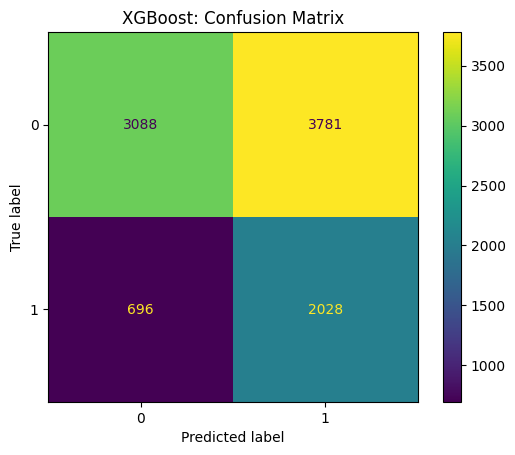

In [ ]:
# Calculate predictions on the test dataset
y_pred = best_xgb.predict(X_test_xgb)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = best_xgb.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = best_xgb.classes_)
disp.plot()
plt.title('XGBoost: Confusion Matrix')

# Save to file
plt.savefig("xgboost-confusion_matrix.png", dpi=300)

# Show the plot
plt.show()

XGBoost maintains strong generalization, with test recall closely mirroring validation performance (**74.4%** vs. **75.1%**), and a stable $F_1$ score — reinforcing its position as the most effective model in this study. The confusion matrix highlights its strength in capturing churners, a critical business goal, though this comes with increased false positives, misclassifying a substantial number of loyal users.

### 8.4 Retrain Champion Model

To maximise predictive performance, we retrain the XGBoost ensemble model on the entire dataset using the optimal hyperparameters identified earlier.

In [ ]:
# Prepare dataset
X = X.copy()
X[nominal_features_xgb] = X[nominal_features_xgb].astype("category")

In [ ]:
%%time
# Instantiate the champion model with best parameters
xgb_final = XGBClassifier(
    **xgb_cv.best_params_,
    enable_categorical=True,
    tree_method="hist",
    random_state=0,
    eval_metric="logloss"
)

# Fit to the full dataset
xgb_final.fit(X, y)

CPU times: user 4.12 s, sys: 33.1 ms, total: 4.16 s
Wall time: 2.24 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

In [ ]:
# Pickle the final model
with open('xgb_final.pickle', 'wb') as to_write:
  pickle.dump(xgb_final, to_write)

In [ ]:
# Download plots
files.download('decision_tree-f1_score_by_iteration.png')
files.download('xgboost-f1_score_by_iteration.png')
files.download('model_feature_importance_comparison.png')
files.download('neural_network-f1_score_by_epoch.png')
files.download('shap_feature_comparison.png')
files.download('xgboost-confusion_matrix.png')
files.download('xgb_final.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9 Conclusion

This project successfully developed and evaluated a range of machine learning models for predicting customer churn. Of the models tested, the XGBoost ensemble emerged as the most effective, consistently outperforming others across key evaluation metrics, including recall (**0.751** on the validation set) and a stable $F_1$ score (**0.475** on the test set), indicating reliable identification of churners under unseen conditions.

Feature attribution via SHAP confirmed meaningful contributions from several behavioral and demographic predictors, with alignment to native categorical splits further enhancing interpretability. Although the neural network showed higher accuracy during validation, its diminished recall and $F_1$ score suggested overfitting and poor generalization to churn cases.

These findings highlight XGBoost's robustness and generalization strength for deployment-oriented churn analysis. Future work may include tuning the precision-recall trade-off through threshold calibration, analyzing false positives for strategic targeting, and exploring hybrid ensemble techniques to capture additional signal from diverse model architectures.

## 10 References
 [1] Neslin, S., Siang, S., Gupta, S., Kamakura, W., Lu, J., Mason, C. (2002). "Churn Modeling Tournament" Teradata Center for Customer Relationship Management at Duke University.

 [2] Neslin, S. A., Gupta, S., Kamakura, W., Lu, J. and C. H. Mason (2006). “Defection detection: Measuring and understanding the predictive accuracy of customer churn models.” Journal of Marketing Research 43 (2), 204–211.

 [3] Shaikhsurab, M. A., Magadum, P. (2024). "Enhancing Customer Churn Prediction in Telecommunications: An Adaptive Ensemble Learning Approach." arXiv preprint [arXiv:2408.16284](https://arxiv.org/abs/2408.16284)

 [4] Sikri, A., Jameel, R., Idrees, S.M., Kaur, H. (2024) "Enhancing customer retention in telecom industry with machine learning driven churn prediction." [Sci Rep 14, 13097](https://www.nature.com/articles/s41598-024-63750-0#citeas)

 [5] Poudel, S.S., Pokharel, S., Timilsina, M. (2024) "Explaining customer churn prediction in telecom industry using tabular machine learning models"

 [6] Chang, V., Hall, K., Xu, Q.A., Amao, F.O., Ganatra, M.A., Benson, V. (2024) "Prediction of Customer Churn Behavior in the Telecommunication Industry Using Machine Learning Models." Algorithms, 17, 231

 [7] Sam, G., Asuquo, P., Stephen, B. (2024) “Customer Churn Prediction Using Machine Learning Models”. Journal of Engineering Research and Reports 26 (2):181-93.
